### <font color='cyan'> Sections in this notebook: <font>
I. Prerequisites 
    
    I.1. Importing modules, load data
    I.2. Cache necessary information about the data up front

II. Data understanding and cleaning

    II.1. Addressing missing data
        II.1.1. Let's get a feel for the missing data in the df first
        II.1.2. Special cases
    II.2. Format Conversion for certain columns
    II.3. Quasi-Constant Variables
        II.3.1 Numeric
        II.3.2. For all other columns
        II.3.3. Special cases
    II.4. Object type columns
    II.5. Deriving new columns 
    II.6. Data imputation
    II.7. Correlation
    II.8. Outlier Detection
        II.7.1 Box Plots
        II.7.2. IQR Analysis
    
III. Data Analysis:

    III.1. Univariate Analysis
        III.1.1. Box Plots contd.
        III.1.2. Probability Distribution 
    III.2. Bivariate analysis
        III.2.1. Categorical columns with a keen focus on loan_status
            III.2.1.1. Grade
            III.2.1.2. Home Ownership
            III.2.1.3. Verification Status
            III.2.1.4. Purpose
            III.2.1.5. Employee Experience
            III.2.1.6. Annual Income
            III.2.1.7. Funded Amount
            III.2.1.8. Rate of Interest
            III.2.1.9. Public records
            III.2.1.10. Number of inquiries in the last 6 months
            III.2.1.11. State Address
            III.2.1.12. Loan Term
            III.2.1.13. Delta_bins
        III.2.1. In between rest of the columns(minus loan_status)
    
IV. Conclusion

# <font color='goldenrod'> I. Prerequisites </font>

### <font color='skyblue'>  I.1. Importing modules, load data<font>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import VarianceThreshold

##### *1.1. Optional settings used for debugging.*

In [4]:
#pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
#pd.set_option('display.min_rows', 100)
#pd.set_option('display.expand_frame_repr', True)
pd.get_option("display.max_rows")

200

##### *1.2. Load data*

In [5]:
df = pd.read_csv("loan.csv", dtype={"next_pymnt_d": "string"}) # Explicitly specificying dtype for
                                                               # next_pymnt_d column, just to avoid pd warning

### <font color='skyblue'>  I.2. Cache necessary information about the data up front

 <font color="asparagus"> Cache the following info: 
 1. df dimension, will be used for different percentage based calculations
 2. df itself in a separate variable

In [6]:
df_loan = pd.read_csv("loan.csv", dtype={"next_pymnt_d": "string"})  # Caching original df, may be need it later for quick comparison

In [7]:
nDfShape = df.shape
nNoOfRows = nDfShape[0]
nNoOfCols = nDfShape[1]

# <font color='goldenrod'> II. Data understanding and cleaning </font>

### <font color='skyblue'>  II.1. Addressing missing data

#### II.1.1.  Let's get a feel for the missing data in the df first <br>
$\Rightarrow$ Instead of manually tackling each column, we will try to automate as much as possible

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(23), string(1)
memory usage: 33.6+ MB


$\Rightarrow$ <font color="asparagus"> The following function returns the #NaNs and #unique values in one column"

In [9]:
def get_columnInfo(df, column):
    return [df[column].isna().sum(), df[column].nunique()]

$\Rightarrow$ <font color="asparagus"> Store this information in a dictionary

In [10]:
columnInfo = {}
for col in df.columns:
    columnInfo[col] = get_columnInfo(df,col)

$\Rightarrow$ <font color="asparagus"> If a column has 60% missing values, we can drop it. This number can be smaller, but for this dataset 60% works

In [11]:
nNanThreshold = 0.6 

In [12]:
droppedCols = []
for col in df.columns:
    if (columnInfo[col][0]/nNoOfRows) >= nNanThreshold:
        print("Column ", col, end=" ")
        print("missing: ", round(100*columnInfo[col][0]/nNoOfRows,2), "%")
        droppedCols.append(col)

Column  mths_since_last_delinq missing:  64.66 %
Column  mths_since_last_record missing:  92.99 %
Column  next_pymnt_d missing:  97.13 %
Column  mths_since_last_major_derog missing:  100.0 %
Column  annual_inc_joint missing:  100.0 %
Column  dti_joint missing:  100.0 %
Column  verification_status_joint missing:  100.0 %
Column  tot_coll_amt missing:  100.0 %
Column  tot_cur_bal missing:  100.0 %
Column  open_acc_6m missing:  100.0 %
Column  open_il_6m missing:  100.0 %
Column  open_il_12m missing:  100.0 %
Column  open_il_24m missing:  100.0 %
Column  mths_since_rcnt_il missing:  100.0 %
Column  total_bal_il missing:  100.0 %
Column  il_util missing:  100.0 %
Column  open_rv_12m missing:  100.0 %
Column  open_rv_24m missing:  100.0 %
Column  max_bal_bc missing:  100.0 %
Column  all_util missing:  100.0 %
Column  total_rev_hi_lim missing:  100.0 %
Column  inq_fi missing:  100.0 %
Column  total_cu_tl missing:  100.0 %
Column  inq_last_12m missing:  100.0 %
Column  acc_open_past_24mths mi

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ From the stdout above, **2** columns have 64.66% and 92.99% missing, while the remaining **54** have 100% missing data.<br> (We can just use dropna() but I like this approach, we can drop things above a threshold at the same time.) <br>
$\Rightarrow$ I have cached this in droppedCols. Let's further analyze and drop all these columns at once at the end right before k-variate analysis

#### II.1.2. Special cases: id, member_id and url are not features! <br>
#### <font color="asparagus"> *Each entry will be unique, whose description from the data dictionary supplied to us is as follows:*<font>
- member_id: A unique LC assigned Id for the borrower member.
- id: A unique LC assigned ID for the loan listing.
- url: URL for the LC page with listing data.<br>
<font color="asparagus"> $\Rightarrow$ *Side note*:<font>
    
- Even if all of *id* was not unique and there was repetition,  keeping *url* will still not make sense, since it only contains id information. 
Eg: For id: 1077501, the url is https://lendingclub.com/browse/loanDetail.action?loan_id=1077501. Really doesn't make sense to keep url.
- Add these three columns to the list of columns to be dropped
    

In [13]:
df.id.nunique(), df.member_id.nunique(), df.url.nunique() # Proving that the values are unique : ) 

(39717, 39717, 39717)

In [14]:
droppedCols.append("id")
droppedCols.append("member_id")
droppedCols.append("url")

### <font color='skyblue'>  II.1. Format Conversion for certain columns<font>
- term
- int_rate
- emp_length
- revol_util

##### <font color="asparagus"> $\Rightarrow$ 1. *term*:<font>

In [15]:
df.term.describe(), df.term.unique()

(count          39717
 unique             2
 top        36 months
 freq           29096
 Name: term, dtype: object,
 array([' 36 months', ' 60 months'], dtype=object))

##### <font color="asparagus"> $\Rightarrow$ *Makes sense removing the string " months" and storing it as an int*<font>

In [16]:
df.term = df.term.str.replace(" months", "")
df.term = df.term.astype(int)

In [17]:
df.term.unique()

array([36, 60])

##### <font color="asparagus"> $\Rightarrow$ *Converting months to years* <font>

In [18]:
df.term = df.term//12

In [19]:
df.term.unique()

array([3, 5])

##### <font color="asparagus"> $\Rightarrow$ 2. *int_rate*:<font> 

In [20]:
df.int_rate.describe()

count      39717
unique       371
top       10.99%
freq         956
Name: int_rate, dtype: object

##### <font color="asparagus"> $\Rightarrow$ *We can get rid of the %* <font>

In [21]:
df.int_rate = df.int_rate.str.replace("%","")

In [22]:
df.int_rate = df.int_rate.astype(float)

##### <font color="asparagus"> $\Rightarrow$ 3. *emp_length* <font>

In [23]:
df.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

##### <font color="asparagus"> $\Rightarrow$ *We can get rid of "year" & "years"* <font>

In [24]:
df.emp_length = df.emp_length.str.replace(" years","")
df.emp_length = df.emp_length.str.replace(" year", "")
df.emp_length = df.emp_length.str.replace("+","")
df.emp_length = df.emp_length.str.replace("< ","")
df.emp_length = df.emp_length.str.replace("10","11")

C:\Users\santo\AppData\Local\Temp/ipykernel_18396/104995927.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.emp_length = df.emp_length.str.replace("+","")


In [25]:
df.emp_length.value_counts()

11    8879
1     7823
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

#### <font color="asparagus"> *Comments*:<font> 
$\Rightarrow$ I think it will be more meaningful to categorize this column into bins: Something like: 0-2, 2-4, 4-6, 6-8, 8-10 and >10

$\Rightarrow$ But before that let's handle the null values first. I'm just gonna fill it up with the mode value, since missing values % = 1075/39717, isn't much. 

In [26]:
df.emp_length.isna().sum()

1075

In [27]:
df.emp_length = df.emp_length.fillna(df.emp_length.mode()[0])

In [28]:
df.emp_length = df.emp_length.astype(int)

In [29]:
emp_length_categories_list = [0, 2, 4, 6, 8, 10, 12]
emp_length_labels_list = ["0-2", "2-4", "4-6", "6-8", "8-10", "> 10"]
df["emp_length_bins"] = pd.cut(df.emp_length, bins=emp_length_categories_list,
                              labels=emp_length_labels_list)

In [30]:
df.emp_length_bins.value_counts()

0-2     12211
> 10     9954
2-4      7531
4-6      5511
6-8      3252
8-10     1258
Name: emp_length_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 3. *revol_util* <font>

In [31]:
df.revol_util.describe()

count     39667
unique     1089
top          0%
freq        977
Name: revol_util, dtype: object

In [32]:
df.revol_util = df.revol_util.str.replace("%","") # Getting rid of "%"
df.revol_util= df.revol_util.astype("float")

### <font color='skyblue'> II.3. Quasi-Constant Variables
* Inspired by [Towards Data Science blog on this topic](https://towardsdatascience.com/how-to-detect-constant-quasi-constant-features-in-your-dataset-a1ab7aea34b4)
* Check out [sklearn.feature_selection.VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) for more info!

####  II.3.1. Numeric data <font>
#### <font color="asparagus"> $\Rightarrow$ Let's drop quasi-constant features where 95% of the values are similar or constant on all the numeric columns <font>

In [33]:
df_numeric = df.select_dtypes(include=np.number)

In [34]:
df_numeric.shape[1]

91

In [35]:
sel = VarianceThreshold(threshold=0.05)

sel.fit(df_numeric.iloc[:,:])


D:\Anaconda\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.05)

#### <font color="asparagus"> *Comments*:<font>
$\Rightarrow$ Once it is fit, the support of the vector, sel will give me all the retained features.<br>
$\Rightarrow$ Therefore anything that does not appear in df.columns[support()] are *quasi-constant*
    

In [36]:
quasi_constant_features_list = [x for x in df_numeric.columns if x not in df_numeric.columns[sel.get_support()]]


In [37]:
len(quasi_constant_features_list), quasi_constant_features_list

(61,
 ['collections_12_mths_ex_med',
  'mths_since_last_major_derog',
  'policy_code',
  'annual_inc_joint',
  'dti_joint',
  'verification_status_joint',
  'acc_now_delinq',
  'tot_coll_amt',
  'tot_cur_bal',
  'open_acc_6m',
  'open_il_6m',
  'open_il_12m',
  'open_il_24m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'il_util',
  'open_rv_12m',
  'open_rv_24m',
  'max_bal_bc',
  'all_util',
  'total_rev_hi_lim',
  'inq_fi',
  'total_cu_tl',
  'inq_last_12m',
  'acc_open_past_24mths',
  'avg_cur_bal',
  'bc_open_to_buy',
  'bc_util',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'mo_sin_old_il_acct',
  'mo_sin_old_rev_tl_op',
  'mo_sin_rcnt_rev_tl_op',
  'mo_sin_rcnt_tl',
  'mort_acc',
  'mths_since_recent_bc',
  'mths_since_recent_bc_dlq',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'num_actv_bc_tl',
  'num_actv_rev_tl',
  'num_bc_sats',
  'num_bc_tl',
  'num_il_tl',
  'num_op_rev_tl',
  'num_rev_accts',
  'num_rev_tl_bal_gt_0',
  'n

#### <font color="asparagus"> $\Rightarrow$ Remember, we already have identified many columns to be dropped, so there might be an overlap. So let's check the newly identified columns

In [38]:
newly_identified_cols = [col for col in quasi_constant_features_list if col not in droppedCols]

#### <font color="asparagus"> $\Rightarrow$ The names of the newly identified columns are:

In [39]:
newly_identified_cols

['collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

#### <font color="asparagus"> $\Rightarrow$ If you look at the unique values of these newly identified columns, you would find that besides pub_rec_bankruptcies, the others are straight up constants and not just quasi-constant.<br><font><br>$\Rightarrow$ But I think we should not drop pub_rec_bankruptcies altogther. This seems like an important variable to analyze against loan status(we will do this in bivariate analysis)
#### <font color="asparagus"> $\Rightarrow$ Either way, it makes sense to drop these columns too

In [40]:
newly_identified_cols.pop(-2) # popping pub_rec_bankruptcies at index -2

'pub_rec_bankruptcies'

In [41]:
newly_identified_cols

['collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [42]:
[df[col].nunique() for col in newly_identified_cols]
    

[1, 1, 1, 1, 1, 1]

In [43]:
[droppedCols.append(col) for col in newly_identified_cols]

[None, None, None, None, None, None]

#### II.3.2 For all other columns

#### <font color="asparagus"> $\Rightarrow$ columnInfo already has the number of unique values for each column, we had cached it earlier.<font>
#### <font color="asparagus"> $\Rightarrow$ Now is the time to add any column that has only **one** unique to the list of columns to be dropped : ) <font>

In [44]:
# [droppedCols.append(col) if (df[col].nunique() == 1 & col not in droppedCols) for col in columnInfo] List comprehension to do this..
print("The following columns have only 1 value throughout the data")
for col in columnInfo:
    if (df[col].nunique() == 1) & (col not in droppedCols):
        print(f"col: {col} ")
        droppedCols.append(col)

The following columns have only 1 value throughout the data
col: pymnt_plan 
col: initial_list_status 
col: application_type 


#### II.3.3. Special Cases
#### <font color="asparagus"> $\Rightarrow$ It's important to note that *desc* column is pointless to have. It contains sentences and words that the borrower filled out when asking for a loan. Now we already have a column called *purpose* which as the name implies holds the purpose for which the loan was taken.<font>
#### <font color="asparagus"> $\Rightarrow$It has 7 unique values, so we will stick with *purpose* column and drop *desc* altogether, unless we want to do sentiment analysis : )<font>

In [45]:
df.desc.unique() # Just an example of the contents of desc column

array(['  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>',
       '  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>',
       nan, ...,
       'Our current gutter system on our home is old and in need of repair.    We will be using the borrowed funds to replace the gutter system on our home.',
       'The rate of interest and fees incurred by carrying a balance on my credit card are so outrageous at this point that continuing

In [46]:
droppedCols.append("desc")

#### <font color="asparagus"> *Comments*: <br> $\Rightarrow$ Finally, let's drop all the columns we have accumulated so far <font>

In [47]:
nNoOfCols = df.shape[1]
print(nNoOfCols)

112


In [48]:
print(f"Number of columns to be dropped {len(set(droppedCols))}, Remainder: {nNoOfCols - len(set(droppedCols))}")

Number of columns to be dropped 70, Remainder: 42


In [49]:
df.drop(droppedCols,axis=1, inplace=True)

In [50]:
nNoOfCols = df.shape[1] # Updating nNoOfCols

In [51]:
nNoOfCols

42

### <font color='skyblue'>  II.4. Object type columns <font>

#### <font color="asparagus"> *I generally do not like to leave object type columns as is. There could be some inconsistencies in the way data is filled.*<font> 
#### <font color="asparagus"> $\Rightarrow$ Let's sanitize them and explicitly convert them to appropriate formats <font>

In [52]:
df_object = df.select_dtypes(include="object")

#### <font color="asparagus"> Just checking what kind of values they take

In [53]:
for col in df_object.columns:
    print("col :", col, end=" ")
    print(columnInfo[col])

col : grade [0, 7]
col : sub_grade [0, 35]
col : emp_title [2459, 28820]
col : home_ownership [0, 5]
col : verification_status [0, 3]
col : issue_d [0, 55]
col : loan_status [0, 3]
col : purpose [0, 14]
col : title [11, 19615]
col : zip_code [0, 823]
col : addr_state [0, 50]
col : earliest_cr_line [0, 526]
col : last_pymnt_d [71, 101]
col : last_credit_pull_d [2, 106]


#### <font color="asparagus"> Don't want to flood stdout, just printing the unique values for columns with less than 16 unique values <font>

In [54]:
for col in df_object.columns:
    if columnInfo[col][1] <= 15:
        print("col :", col, end=" ")
        print(df[col].unique())

col : grade ['B' 'C' 'A' 'E' 'F' 'D' 'G']
col : home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
col : verification_status ['Verified' 'Source Verified' 'Not Verified']
col : loan_status ['Fully Paid' 'Charged Off' 'Current']
col : purpose ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']


#### <font color="asparagus"> All of these columns can first be converted to string type, since none of them have any other problems <font>

In [55]:
for col in df_object.columns:
    df[col] = df[col].astype("string")

### <font color='skyblue'>  II.6. Deriving new columns
    

##### <font color="asparagus"> We've already converted term in months to years. Now let's look at other columns. Starting with: <font>
##### <font color="asparagus"> $\Rightarrow$ 1. *annual_inc*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column into bins of 20000 dollars. 

In [56]:
df.annual_inc.describe()

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

##### <font color="asparagus"> $\Rightarrow$ Just checking few things about the annual_inc column <font>

In [57]:
np.quantile(df.annual_inc,0.99) ## 99% of the borrowers have annual inc < $234,000

234999.36

In [58]:
len(df[(df.annual_inc > np.quantile(df.annual_inc,0.99))])

398

##### <font color="asparagus"> $\Rightarrow$ There are still 43 borrowers(out of 398) whose income is in the top 1%, yet they defaulted. > 10%

In [59]:
len(df[(df.annual_inc > np.quantile(df.annual_inc,0.99)) & (df.loan_status == "Charged Off")])

43

In [60]:
annual_inc_categories_list = [0, 20000, 40000, 60000, 80000, 100000, 6000000]
annual_inc_labels_list = ["0-20", "20-40", "40-60", "60-80", "80-100", "> 100"]
df["annual_inc_bins"] = pd.cut(df.annual_inc, bins=annual_inc_categories_list,
                              labels=annual_inc_labels_list)

In [61]:
df.annual_inc_bins.value_counts()

40-60     11608
20-40      8688
60-80      7861
> 100      5687
80-100     4684
0-20       1189
Name: annual_inc_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 2. *funded_amnt*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column as well.(bins of 5,000)

In [62]:
df.funded_amnt.describe()

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

In [63]:
funded_amnt_categories_list = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
funded_amnt_labels_list = ["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-35", "35-40"]
df['funded_amnt_bins'] = pd.cut(df.funded_amnt, bins=funded_amnt_categories_list,
                              labels=funded_amnt_labels_list)

In [64]:
df.funded_amnt_bins.value_counts()

5-10     13161
0-5       9651
10-15     8178
15-20     4597
20-25     2719
25-30      725
30-35      686
35-40        0
Name: funded_amnt_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 3. *int_rate*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column as well.

In [65]:
int_rate_range_list = [0, 8, 10, 12, 14, 16, 30]
int_rate_labels_list = ["0-8", "8-10", "10-12", "12-14", "14-16", ">16"]
df["int_rate_bins"] = pd.cut(df["int_rate"], bins=int_rate_range_list, labels=int_rate_labels_list)

In [66]:
df["int_rate_bins"].value_counts()

10-12    8576
0-8      8233
12-14    7469
>16      5869
14-16    5410
8-10     4160
Name: int_rate_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 4. *issue_year and last_payment_year*:<font>
<font color="asparagus"> I think if we extract the issue year and last_payment_year, we can do some sort of analysis 

In [67]:
mapper ={"Jan": 1, "Feb" : 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, 
         "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}

In [68]:
df["issue_year"] = df.issue_d.str.extract(r"\w+\-(\d+)", expand=True)
df["issue_month"] = df.issue_d.str.extract(r"(\w+)\-\d+", expand=True)
df["issue_month"] = df["issue_month"].apply(lambda x: mapper[x])
df["issue_month"] = df["issue_month"].astype(float)
df["issue_year"] = df["issue_year"].astype(float)

In [69]:
df["issue_year"] = round(df["issue_year"] + df["issue_month"]/12,2)

##### <font color="asparagus"> $\Rightarrow$ last_payment_year <font> 
last_payment_year and last_payment_month first. They both have 71 missing entries

In [70]:
df["last_payment_year"] = df.last_pymnt_d.str.extract(r"\w+\-(\d+)", expand=True)
df["last_payment_month"] = df.last_pymnt_d.str.extract(r"(\w+)\-\d+", expand=True)

In [71]:
df["last_payment_year"].fillna(df.last_payment_year.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ Fill last_payment_month with the most common entry for the year 2013(the most common year and the one that we just filled the missing values in last_payment_year with <font> 

In [72]:
df[df.last_payment_year == df.last_payment_year.mode()[0]]["last_payment_month"].value_counts()

Mar    1026
May     907
Feb     869
Apr     851
Jan     784
Dec     780
Jul     776
Aug     727
Oct     692
Jun     691
Sep     684
Nov     671
Name: last_payment_month, dtype: int64

In [73]:
df["last_payment_year"] = df.last_pymnt_d.str.extract(r"\w+\-(\d+)", expand=True)
df["last_payment_year"].fillna(df.last_payment_year.mode()[0], inplace=True)
df["last_payment_month"] = df.last_pymnt_d.str.extract(r"(\w+)\-\d+", expand=True)
df["last_payment_month"] = df["last_payment_month"].fillna("Mar")


df["last_payment_month"] =df["last_payment_month"].apply(lambda x: mapper[x])
df["last_payment_month"] = df["last_payment_month"].astype(float)
df["last_payment_year"] = df["last_payment_year"].astype(float)

In [74]:
df["last_payment_year"] = round(df["last_payment_year"] + df["last_payment_month"]/12,2)

In [75]:
df["delta"] = round(df["last_payment_year"] - df["issue_year"],2)

In [76]:
delta_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
delta_labels_list = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8"]
df["delta_bins"] = pd.cut(df.delta, bins=delta_list,
                              labels=delta_labels_list)

In [77]:
df["delta_bins"].value_counts()

2-3    14295
1-2     8184
3-4     7506
0-1     6053
4-5     3079
5-6      600
6-7        0
7-8        0
Name: delta_bins, dtype: int64

### <font color='skyblue'>  II.6. Data Imputation for missing rows

In [78]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

#### <font color="asparagus"> Low hanging fruits: <font>
1. title 
2. revol_util
3. last_pymnt_d
4. last_credit_pull_d
5. emp_length
6. pub_rec_bankruptcies

##### <font color="asparagus"> $\Rightarrow$ 1. *title*<font> 
- Only 11/39717 have missing values, we can impute using value of mode 

In [79]:
df.title.fillna(df.title.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 2. *revol_util*<font> 
- Only 50/39717 have missing values, we can impute using value of mode 

In [80]:
df.revol_util.fillna(df.revol_util.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 3. *last_pymnt_d*<font> 
- Only 71/39717 have missing values, we can impute using value of mode 

In [81]:
df.last_pymnt_d.fillna(df.last_pymnt_d.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 4. *last_credit_pull_d*<font> 
- Only 2/39717 have missing values, we can impute using value of mode 

In [82]:
df.last_credit_pull_d.fillna(df.last_credit_pull_d.mode()[0], inplace=True)

In [83]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

##### <font color="asparagus"> $\Rightarrow$ 5. *emp_length* <font>
- Though it has more missing values than the above ones we just discussed 1075/39717, isn't much. This column is categorical, plus it seems the company has more 10+ experience borrowers. We can fill with mode

##### <font color="asparagus"> $\Rightarrow$ 6. *pub_rec_bankruptcies* <font>

In [84]:
df["pub_rec_bankruptcies"].value_counts()

0.0    37339
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [85]:
df["pub_rec_bankruptcies"].fillna(df["pub_rec_bankruptcies"].mode()[0], inplace=True)

In [86]:
df["pub_rec_bankruptcies"].isna().sum()

0

### <font color='skyblue'>  II.6. Correlation<font>

#### <font color="asparagus"> *Need to create a heatmap of all the retained numeric variables and check the relationship* <font>

In [87]:
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

In [88]:
df_numeric = df.select_dtypes(include=np.number)

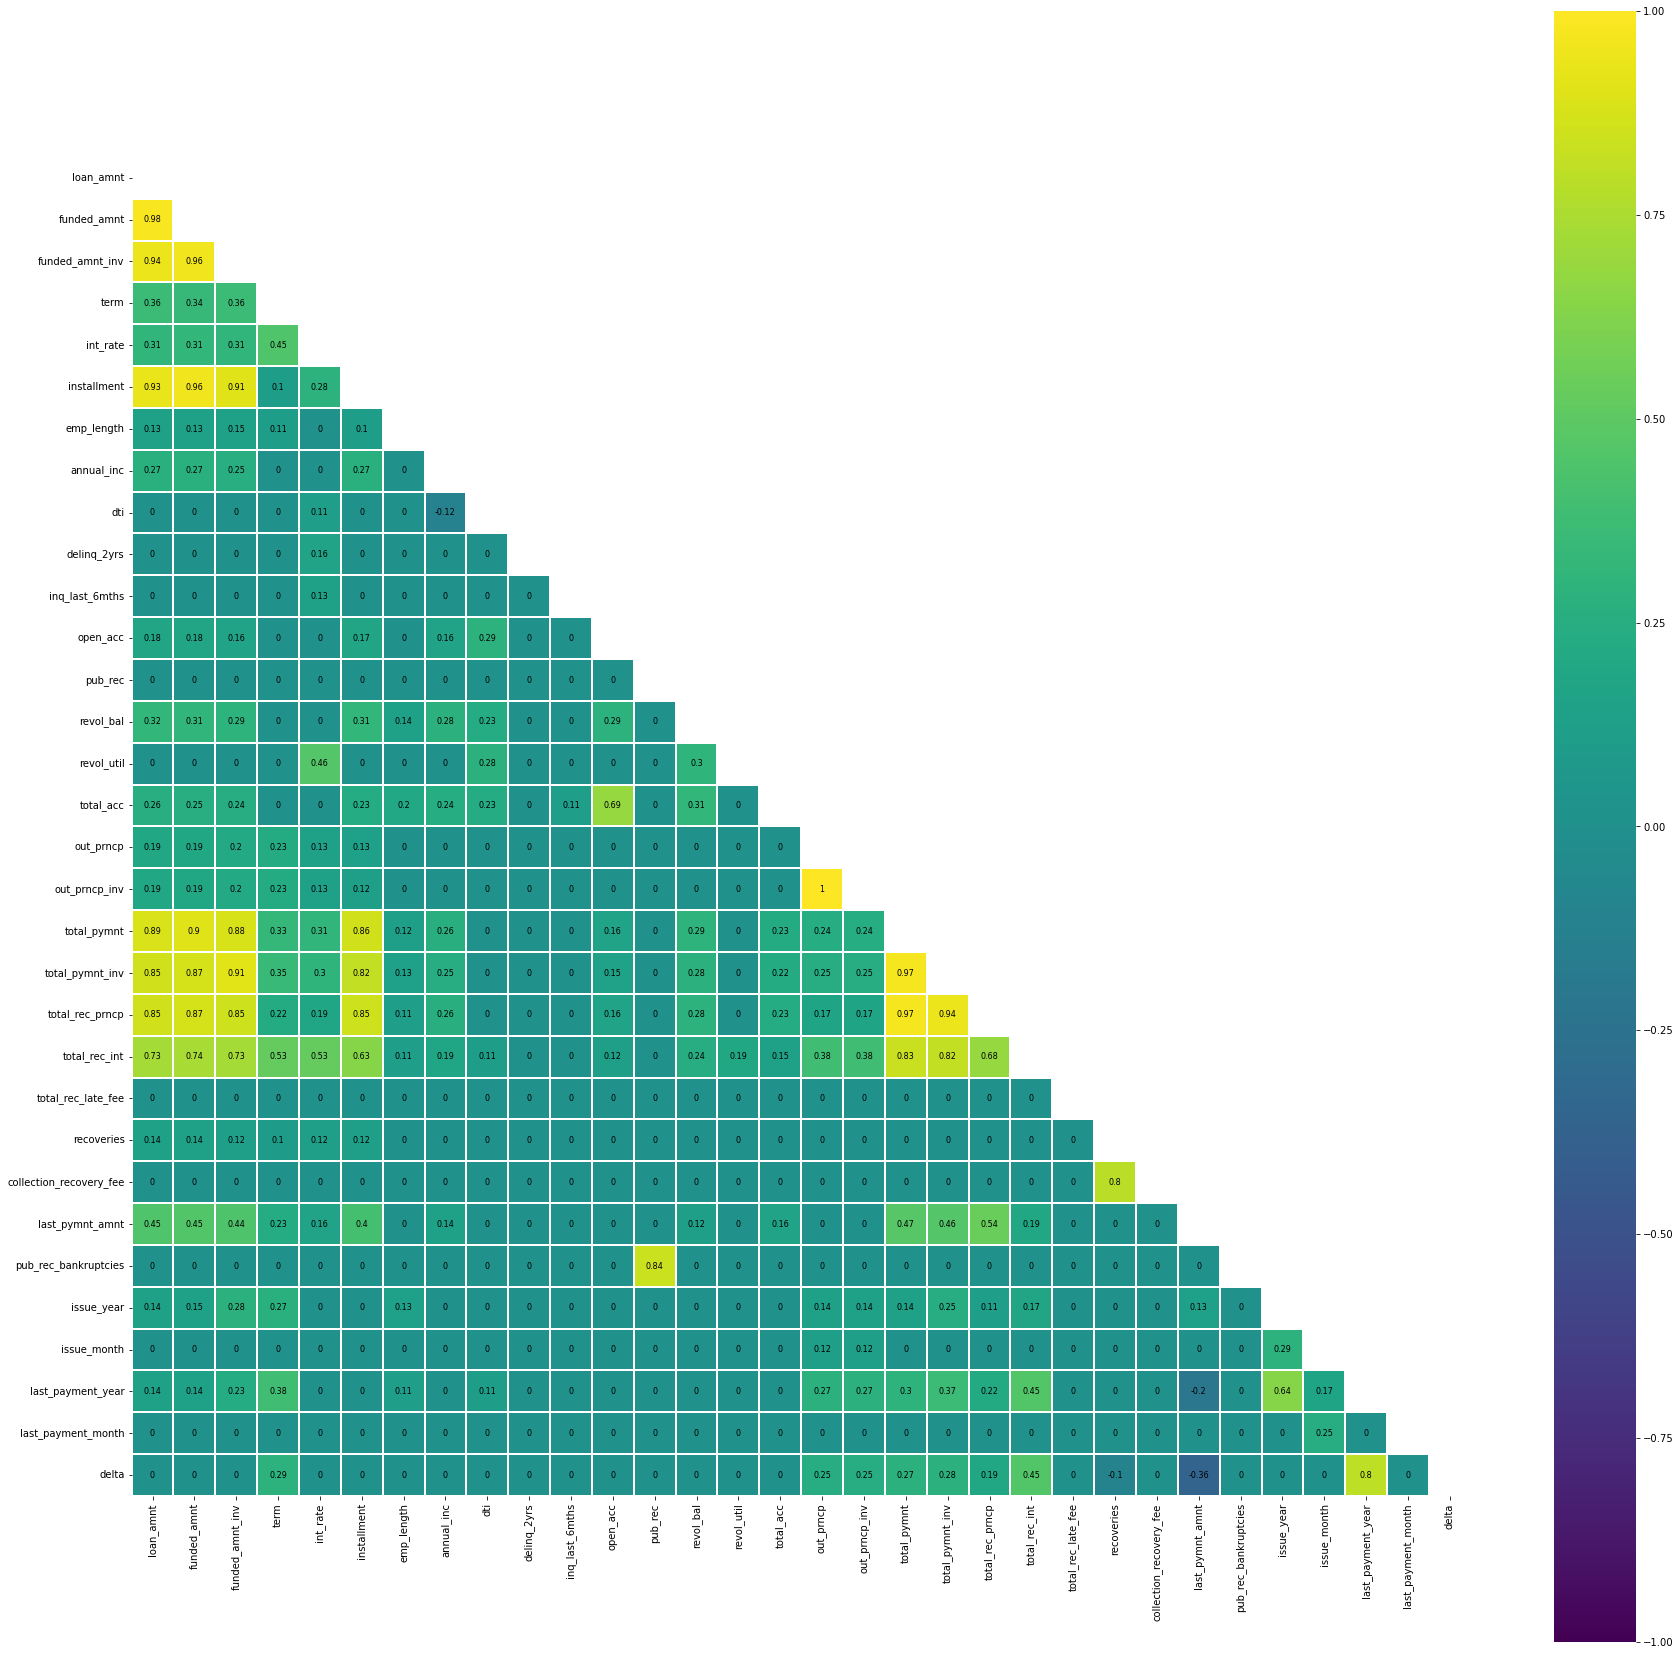

<Figure size 432x288 with 0 Axes>

In [89]:
corr_mat = df_numeric.corr()

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Choose the color map
cmap = "viridis"

corr_mat[(corr_mat < 0.1) & (corr_mat > -0.1)] = 0 # Easier to view, don't really care obout weak correlations
# plot the heatmap
plt.figure(figsize=(30,30))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 8, "color": "black"}, square=True, cmap=cmap, annot=True)
plt.show()
plt.tight_layout()

#### <font color="asparagus"> 1. We need to make a decision on these highly correlation variables.<font> 
#### <font color="asparagus"> 2. No need to keep them all, rather, we can discard all but one and continue <font>

##### Strengh of relationship

* |r| < 0.3 $\Rightarrow$ None or Very Weak
* 0.3 < |r| < 0.5 $\Rightarrow$ Weak
* 0.5 < |r| < 0.7 $\Rightarrow$ Moderate
* |r| > 0.7 $\Rightarrow$ Strong

In [90]:
colsToDrop_fromCorr = [] # New list to maintain the columns we want to drop

#### <font color="asparagus"> $\Rightarrow$ *Focusing on funded_amount, loan_amount, funded_amount_inv first* <font>
1. loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. funded_amnt: The total amount committed to that loan at that point in time.
3. funded_amnt_inv: The total amount committed by investors for that loan at that point in time.<br>
The correlation factor, r, is almost 1 for these guys
    
In short, a borrower approaches the company to ask for an amount, *loan_amnt*. The company agrees for a certain amount, *funded_amnt*. *funded_amnt_inv*: Sometimes, the lending club themselves step in and fund the amount. This is that. <br>
$\Rightarrow$ Conclusion: We can just keep *funded_amnt* and discard the rest. <br>Because *loan_amnt* will satisfy the condition:
    *funded_amnt* <= *loan_amnt* 

    

In [91]:
colsToDrop_fromCorr.append("loan_amnt")
colsToDrop_fromCorr.append("funded_amnt_inv")

#### <font color="asparagus"> $\Rightarrow$ *Commenting on installment* <font>

#### *installment* is the monthly payment owed by the borrower if the loan originates as per the data dictionary. <br>
#### Again, r >0.9 with "loan_amnt", "funded_amnt", "funded_amnt_inv". <br>
#### Therefore, *installment* can be dropped as well.

In [92]:
colsToDrop_fromCorr.append("installment")

#### <font color="asparagus"> $\Rightarrow$ *Commenting on total_xx columns* <font>

#### <font color="asparagus"> 1. total_pymnt: Payments received to date for total amount funded<font>
#### <font color="asparagus"> 2. total_pymnt_inv: Payments received to date for portion of total amount funded by investors<font>
#### <font color="asparagus"> 3. total_rec_prncp: Principal received to date<font>
#### <font color="asparagus"> 4. total_rec_int: Interest received to date<font> 
##### <font color="asparagus"> $\Rightarrow$ We cannot drop total_pymnt, but as it stands, it does not give us good information about the borrower's current status of payment(how much left, how much paid). They are just raw numbers. <br>
##### <font color="asparagus"> $\Rightarrow$ What we can do instead is add a new column: Percentage of funded amount paid.
If a borrower pays the entire amount, the percentage will 100%. Formula: <br>(total_pymnt - total_rec_int - total_rec_late_fee)/funded_amnt.<br> 
#### *Side note*: These columns also show a high correlation with *"loan_amnt", "funded_amnt", "funded_amnt_inv"* (~0.75)<br>

**Conclusion**: We can hold on to *total_pymnt* and discard remaining. By the way, *funded_amnt* is highly correlated with *total_pymnt* as well
    

In [93]:
df["Pct_Payment_Received"] = round(100 * (df.total_pymnt - df.total_rec_int - df.total_rec_late_fee)/df.funded_amnt,2) 

In [94]:
colsToDrop_fromCorr.append("total_pymnt_inv")
colsToDrop_fromCorr.append("total_rec_prncp")
colsToDrop_fromCorr.append("total_rec_int")

In [95]:
colsToDrop_fromCorr


['loan_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int']

#### <font color="asparagus"> $\Rightarrow$ *Commenting on (total_acc, open_acc): r = 0.69 and (collection_recovery_fee, recoveries)*: r = 0.8 <font>

#### 1. total_acc: The total number of credit lines currently in the borrower's credit file
#### 2. open_acc: The number of open credit lines in the borrower's credit file.

$\Rightarrow$ Makes sense that they are highly correlated. I think we can just **keep the number of open credit lines** and **drop the total**, because **total will include open and closed**. **We are only interested in the ones that are currently running**(this is where we can find whether the borrower is about to default or not)

In [96]:
colsToDrop_fromCorr.append("total_acc")

#### 1. recoveries: post charge off gross recovery
#### 2. collection_recovery_fee: post charge off collection fee<br>
$\Rightarrow$ Both of these quantities are concerned with post charge off scenarios. Most of the values are 0 for both of them as well. I think it is safe to drop recoveries

In [97]:
colsToDrop_fromCorr.append("recoveries")

In [98]:
colsToDrop_fromCorr

['loan_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_acc',
 'recoveries']

In [99]:
df.drop(colsToDrop_fromCorr,axis=1,inplace=True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   funded_amnt              39717 non-null  int64   
 1   term                     39717 non-null  int32   
 2   int_rate                 39717 non-null  float64 
 3   grade                    39717 non-null  string  
 4   sub_grade                39717 non-null  string  
 5   emp_title                37258 non-null  string  
 6   emp_length               39717 non-null  int32   
 7   home_ownership           39717 non-null  string  
 8   annual_inc               39717 non-null  float64 
 9   verification_status      39717 non-null  string  
 10  issue_d                  39717 non-null  string  
 11  loan_status              39717 non-null  string  
 12  purpose                  39717 non-null  string  
 13  title                    39717 non-null  string  
 14  zip_co

In [101]:
nNoOfCols = df.shape[1]

In [102]:
nNoOfCols

44

### <font color='skyblue'>  II.7. Outlier Detection<font>
1. Box Plots<br>
2. Mahalanobis Distance

When describing relationship between two variables, correlations is necessary, but not sufficient. More plots will help

#### <font color="asparagus"> *Sequence*:<font>
$\Rightarrow$ <font color="asparagus"> Boxplot first then  
$\Rightarrow$ <font color="asparagus">  I'm gonnna calculate the IQRs for every column and store the locations of every row that lies outside the 1.5IQR range

### <font color='skyblue'>  II.7.1. Box Plots<font>

In [103]:
df_numeric = df.select_dtypes(include=np.number)

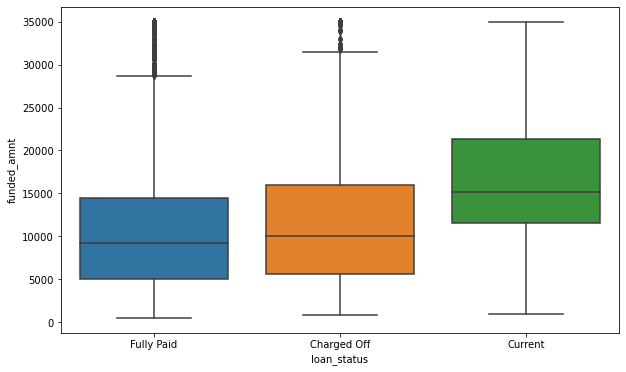

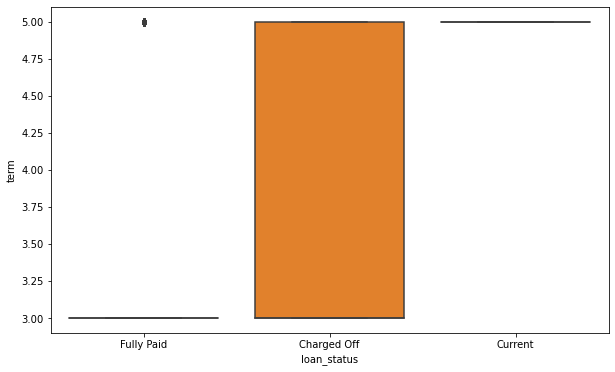

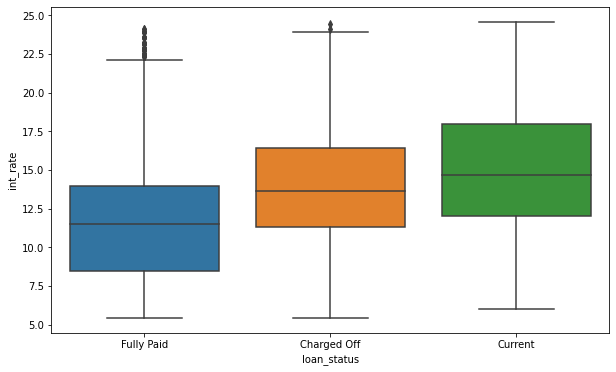

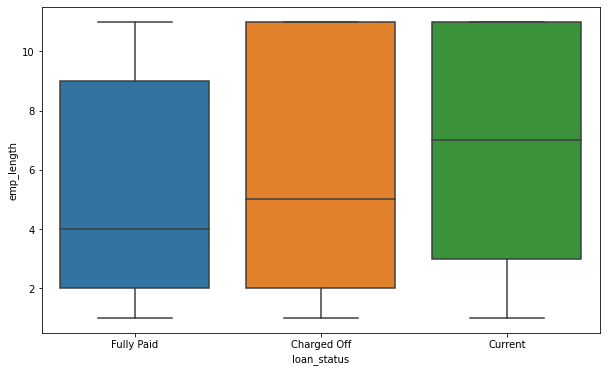

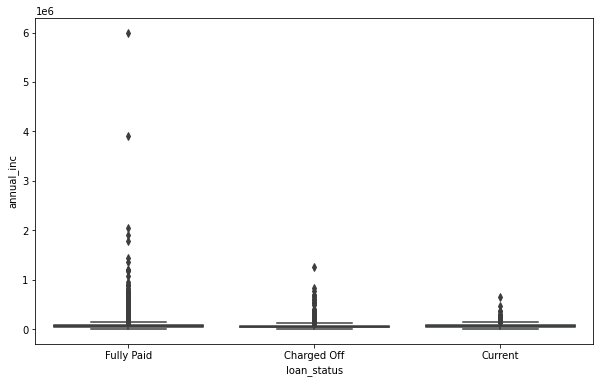

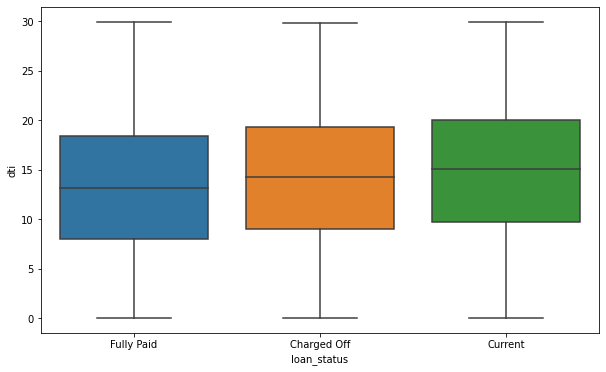

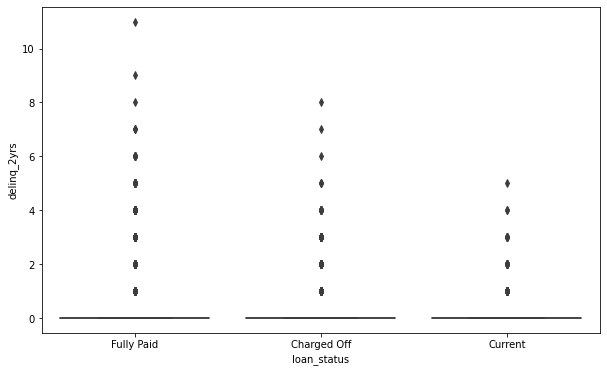

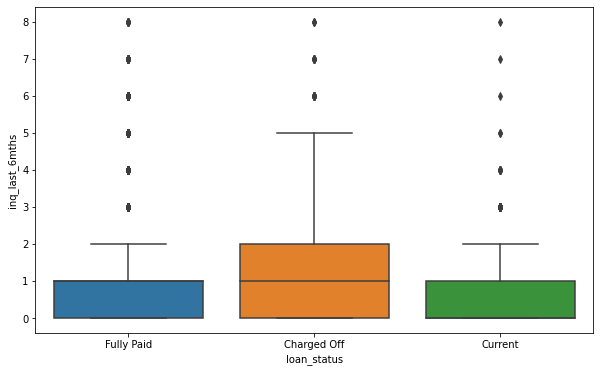

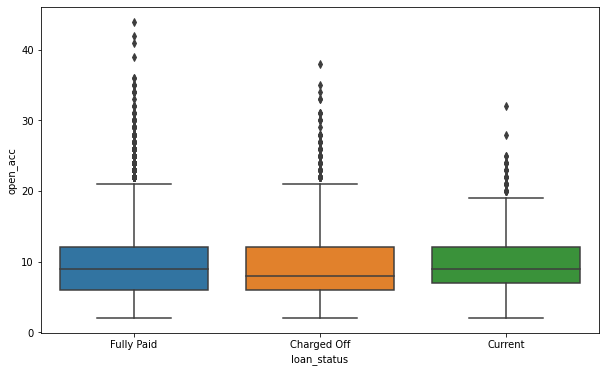

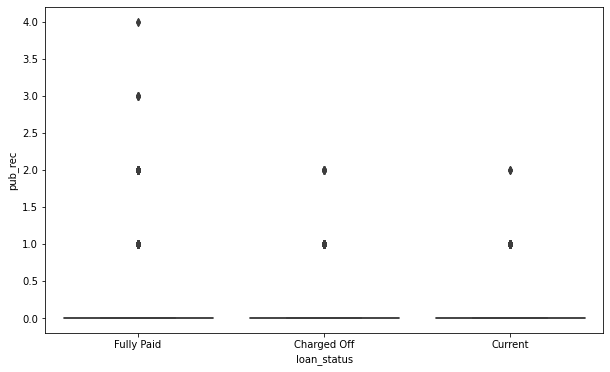

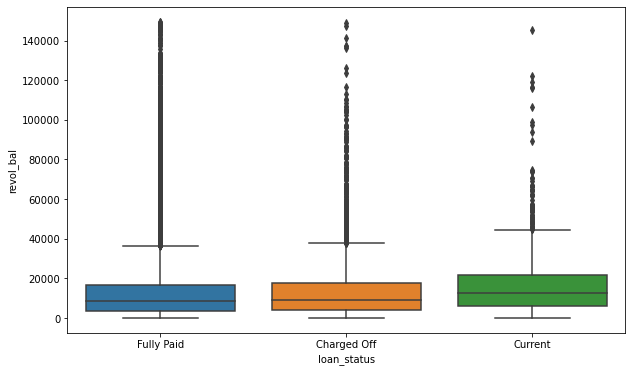

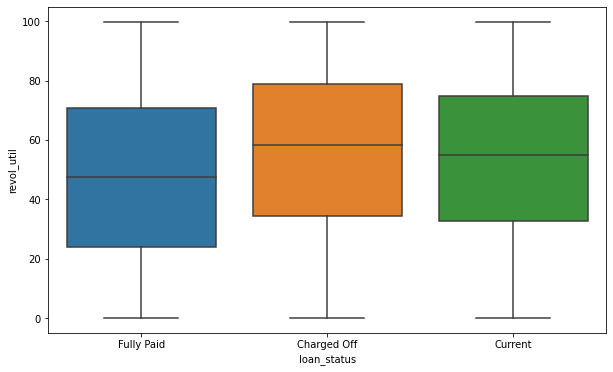

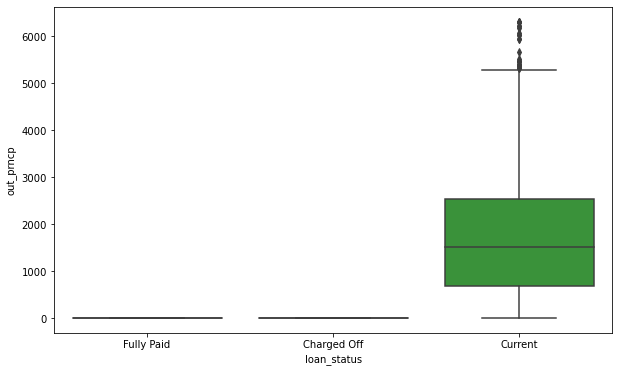

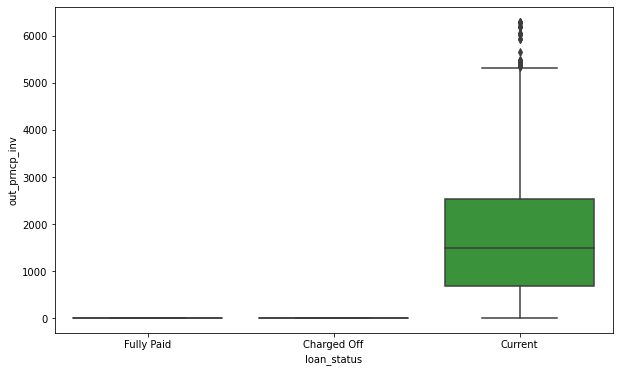

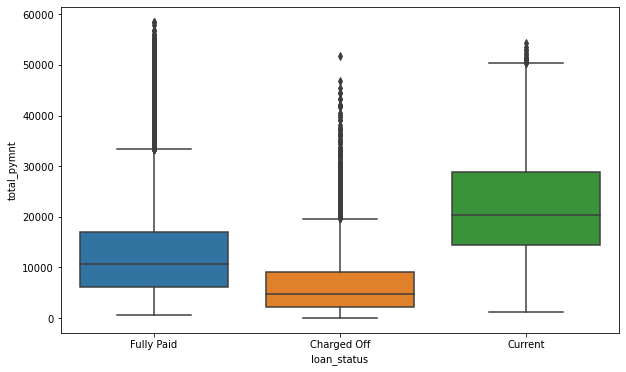

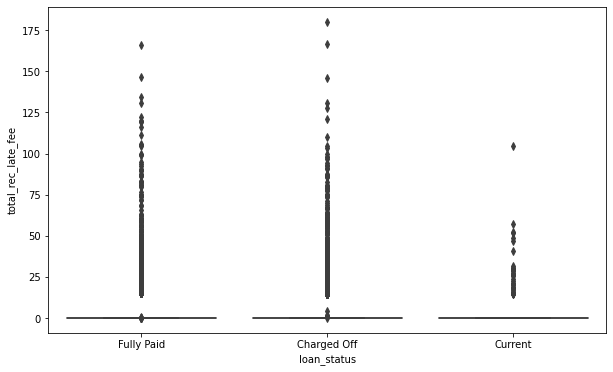

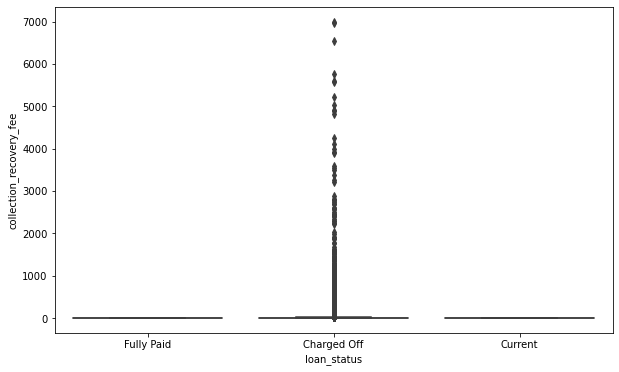

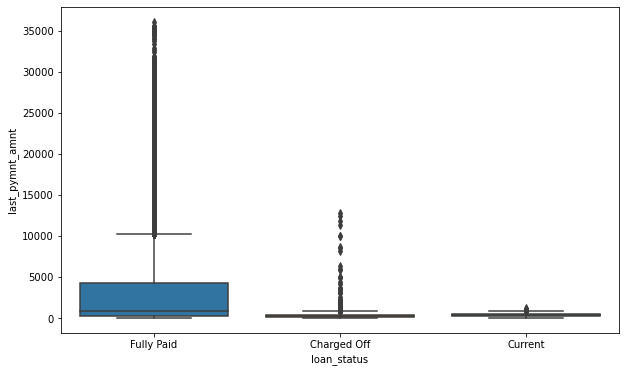

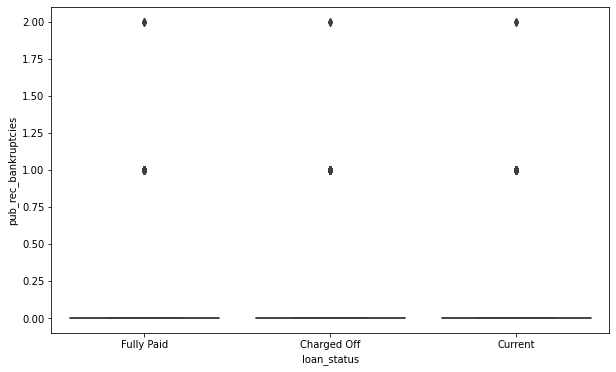

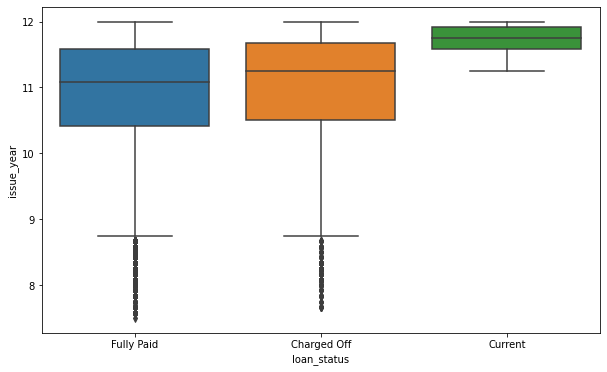

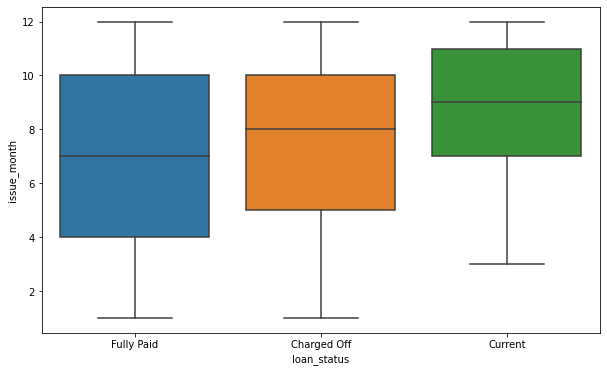

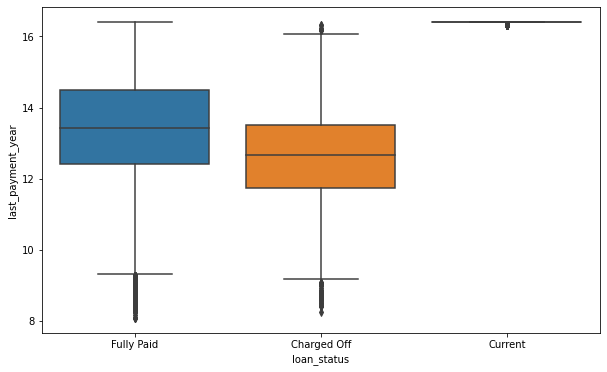

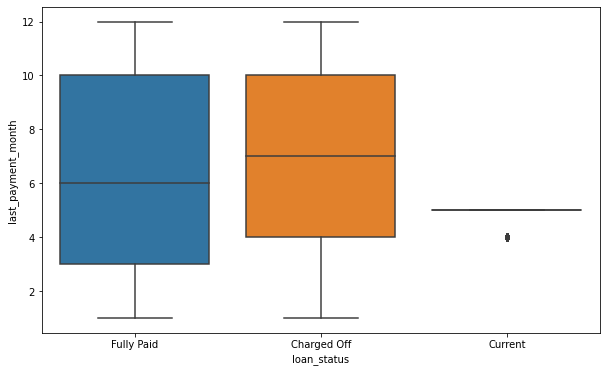

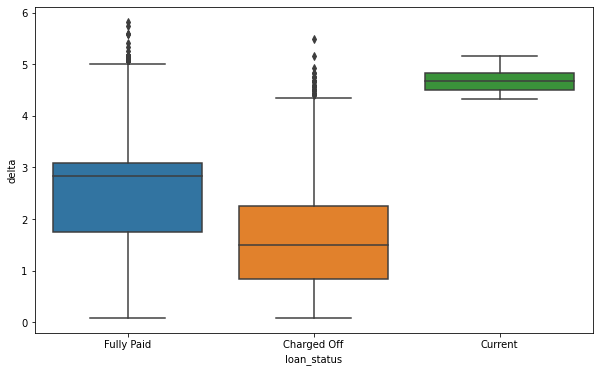

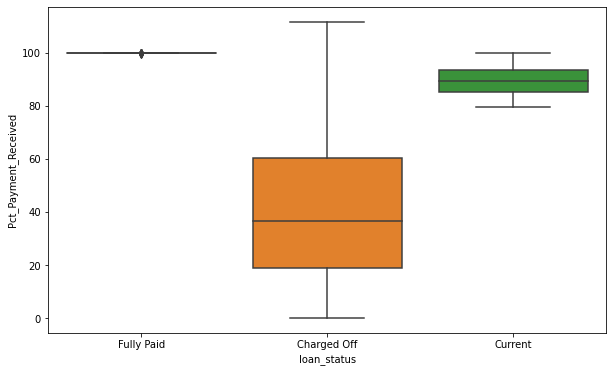

In [104]:
#fig, axes = plt.subplots(7,2,figsize=(20,30))
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="loan_status", y=col,
                data=df)
    plt.show()
    

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Looking at the box plot, it looks like the median(and range) of percentage_payment_received is the lowest for "Charged Off" borrowers. This is a good indicator for borrowers who are likely to default. <br> **You will see later in Bivariate analysis how this has influence on *delta_bins* variable as well**

In [105]:
indicators = []
indicators.append("Pct_Payment_Received")

In [106]:
indicators

['Pct_Payment_Received']

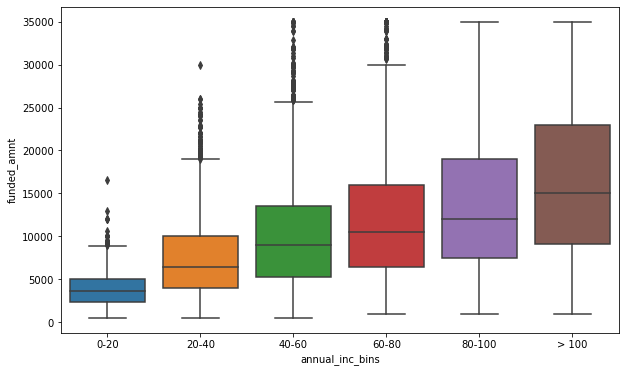

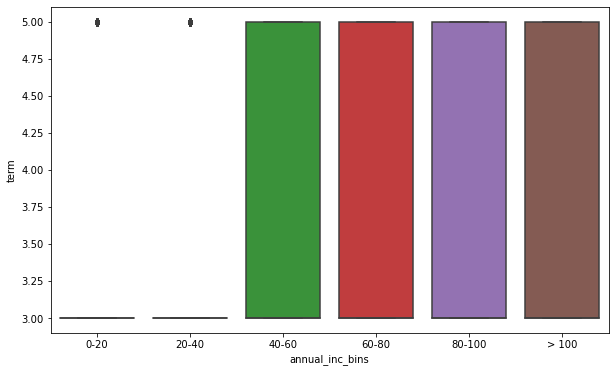

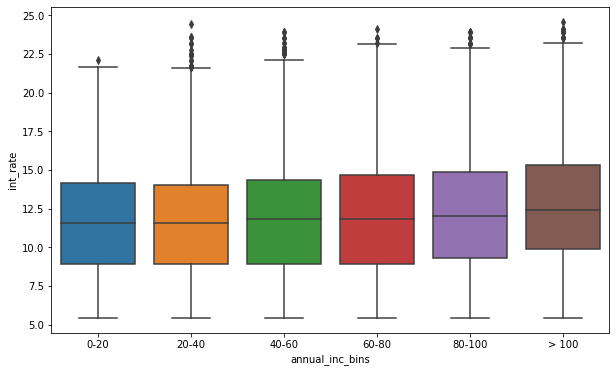

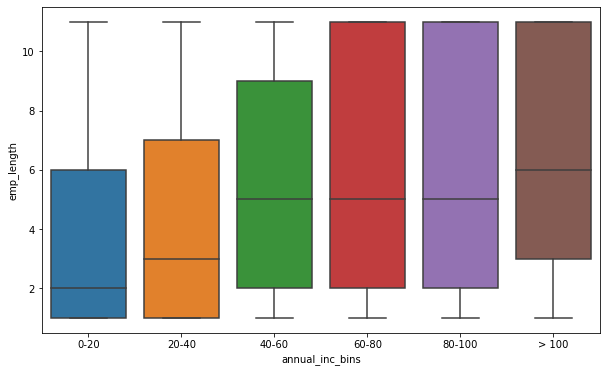

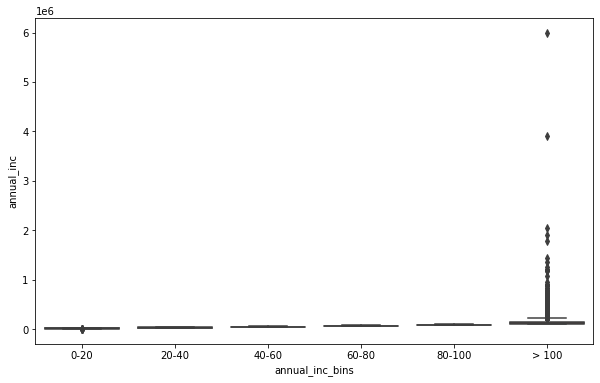

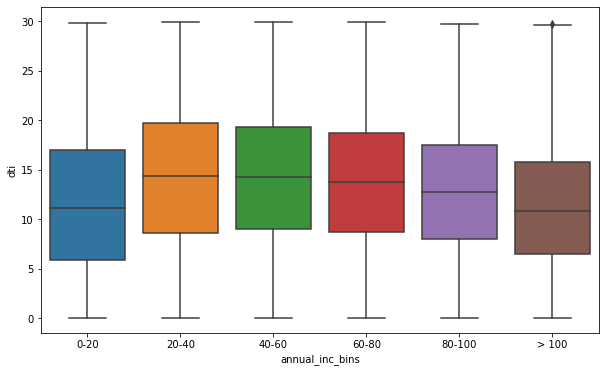

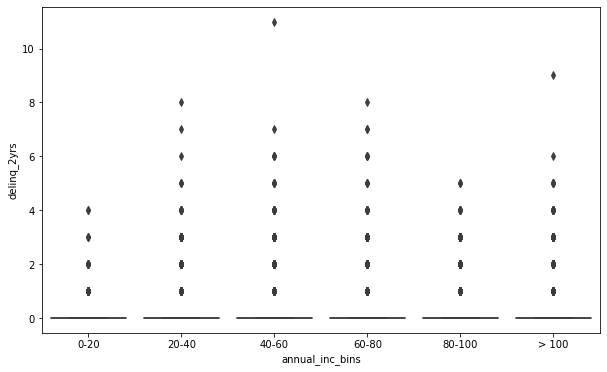

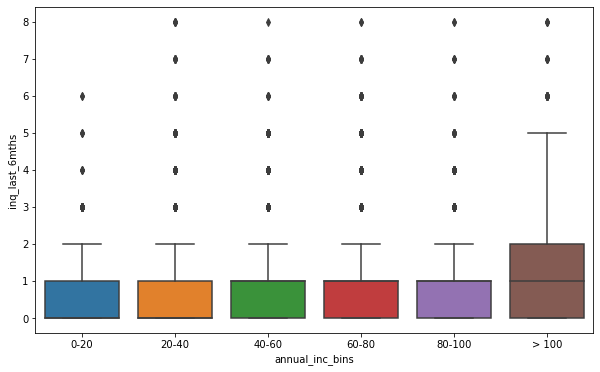

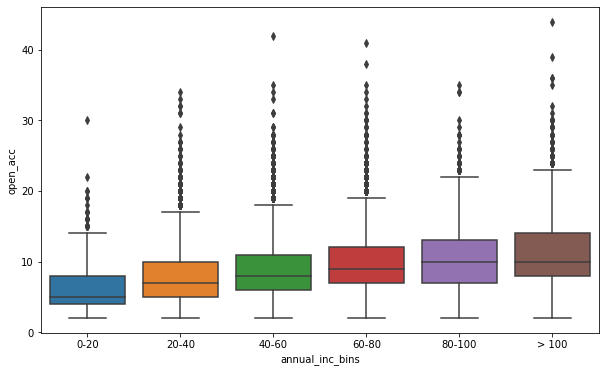

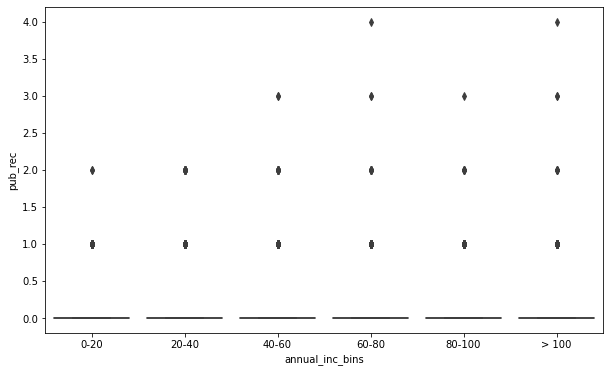

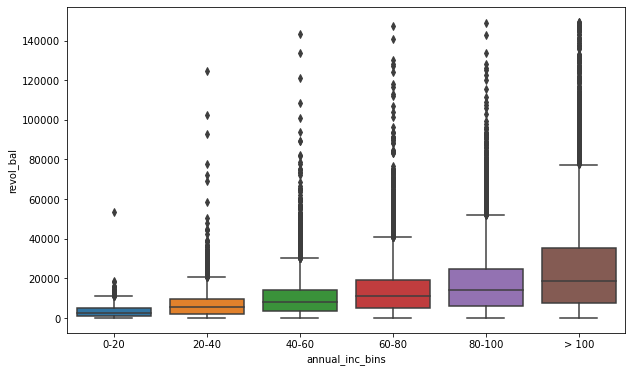

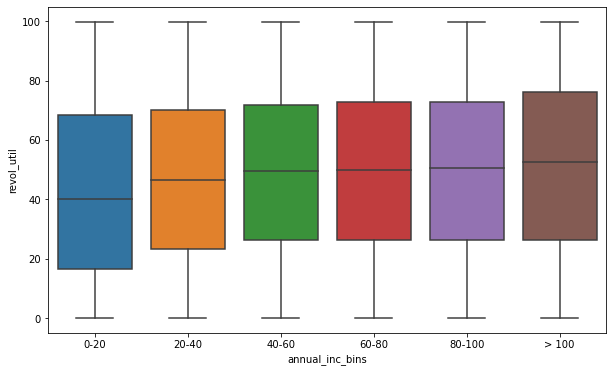

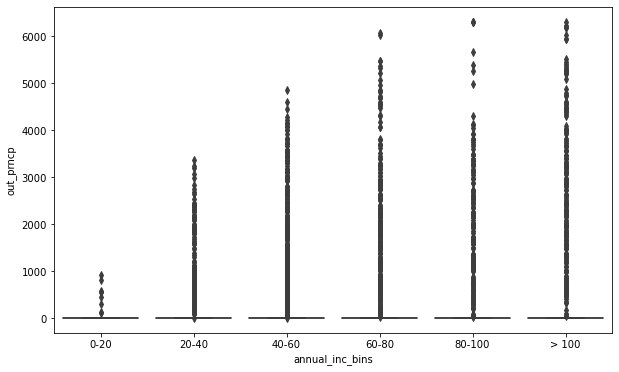

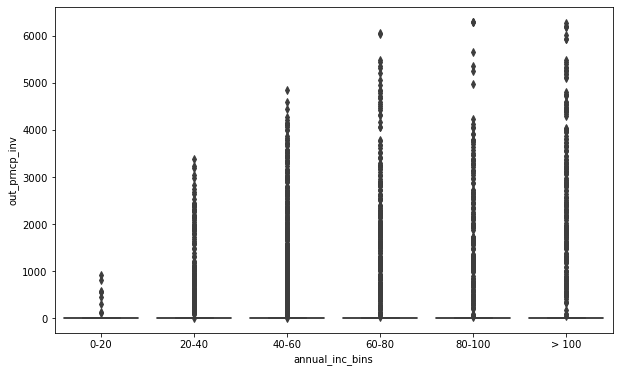

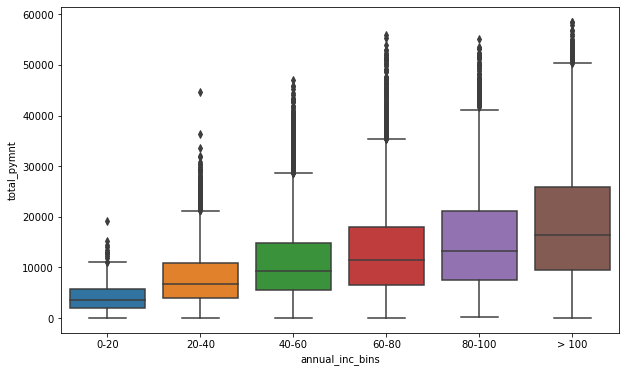

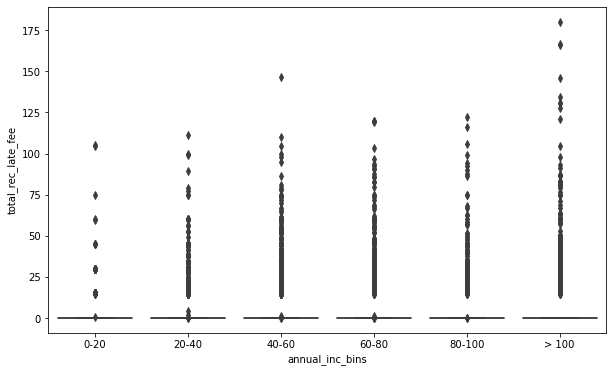

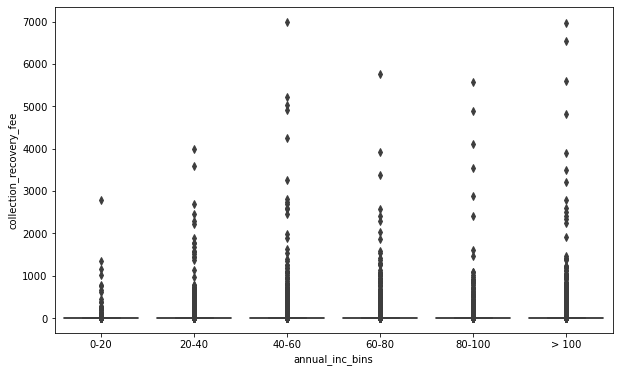

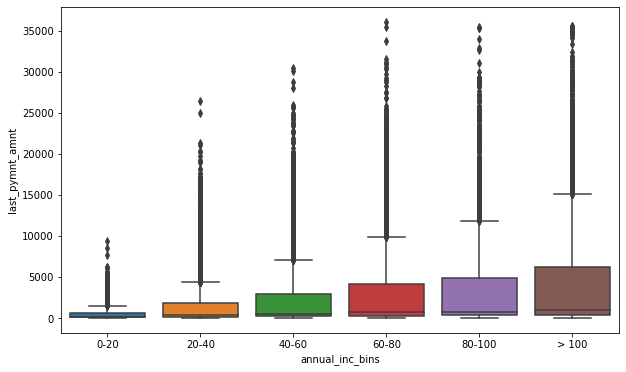

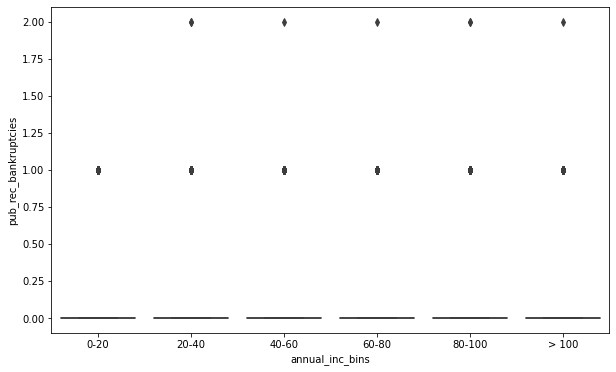

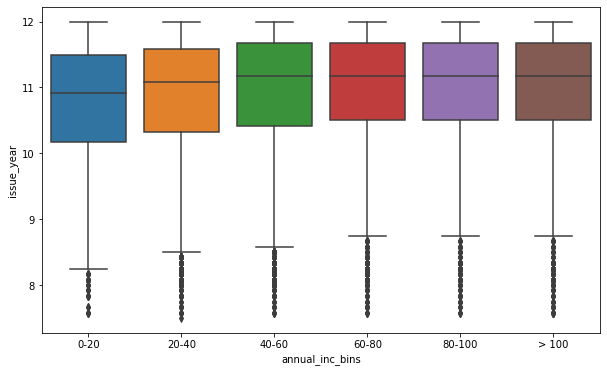

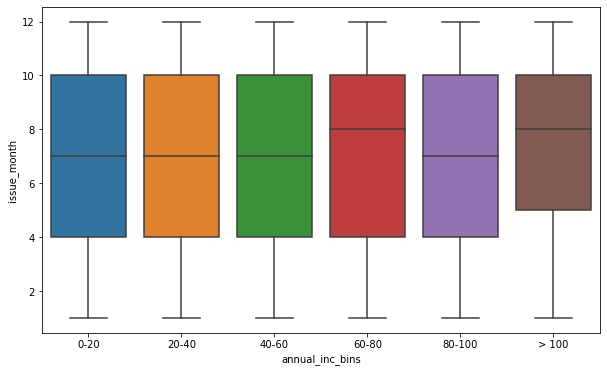

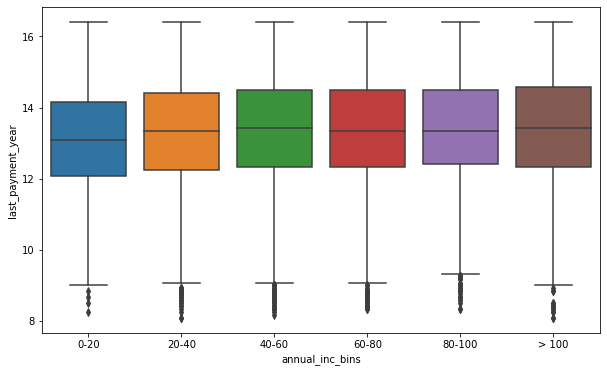

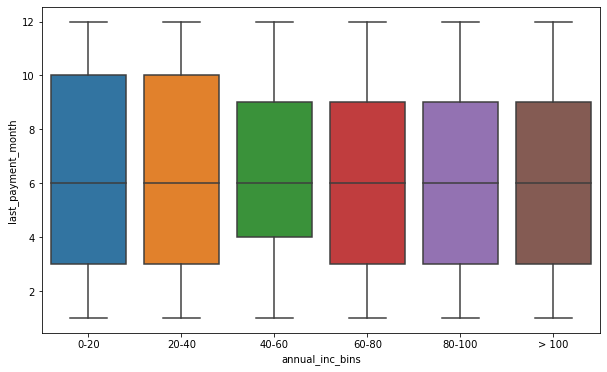

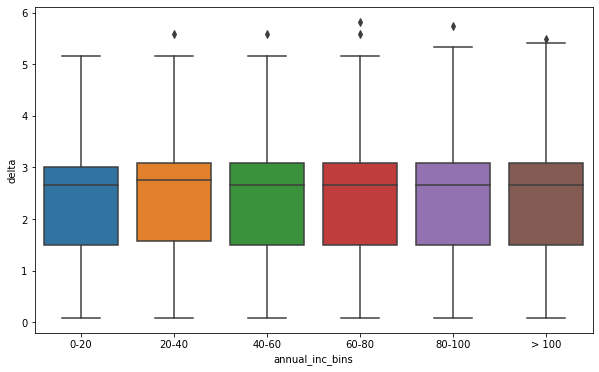

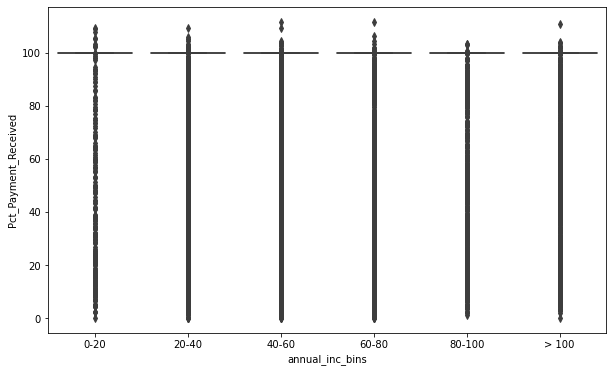

In [107]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="annual_inc_bins", y=col,
                data=df)
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Borrowers with high income borrow the higest amount. They also have made more inquiries in the past 6 months as compared to others. They have a lot more open accounts than borrowers with lower income than them. <br> $\Rightarrow$ Since they tend to borrow more, the total payment received is also more. <font><br>

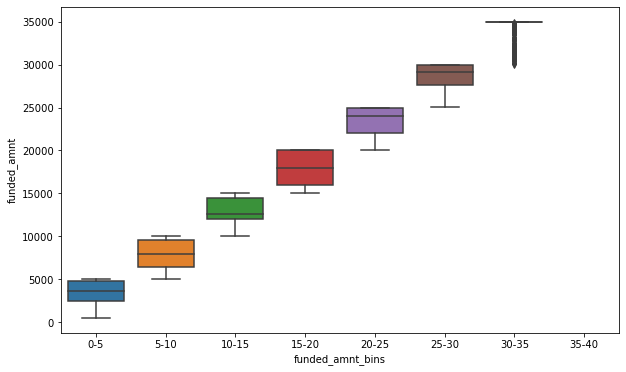

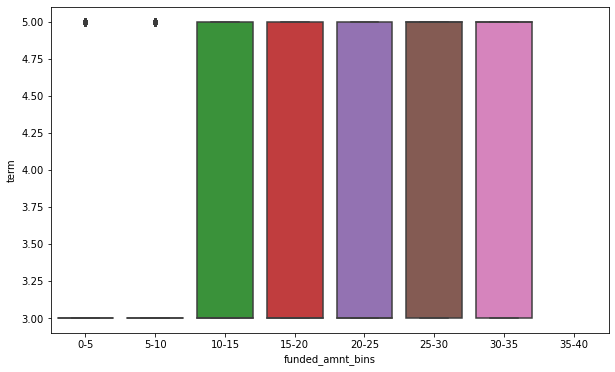

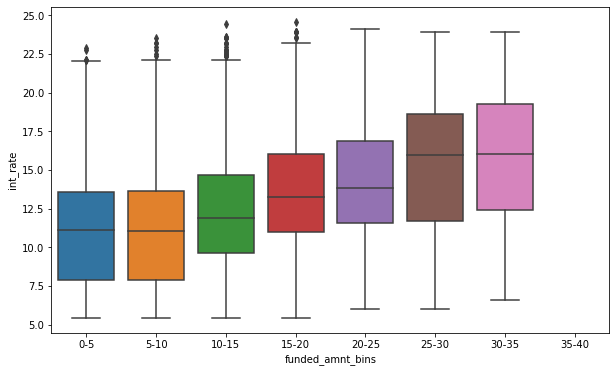

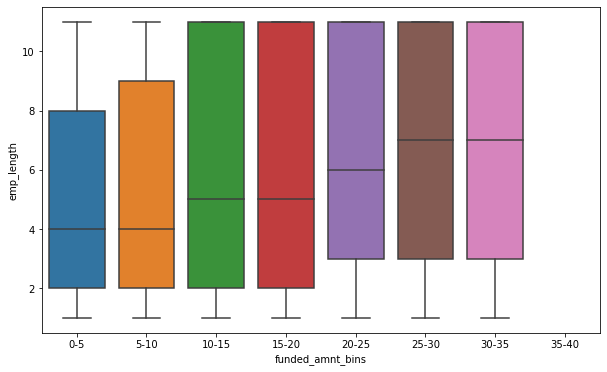

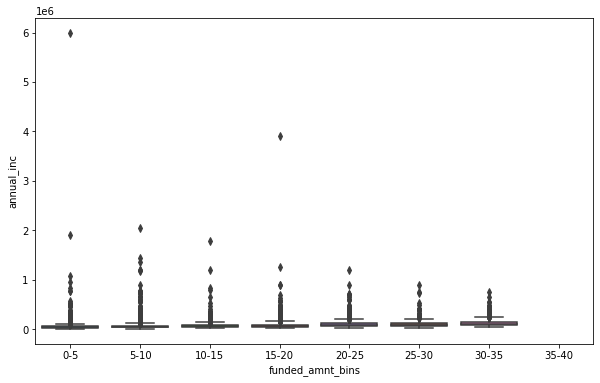

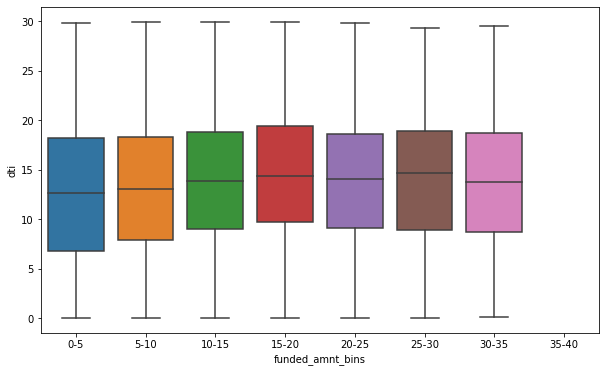

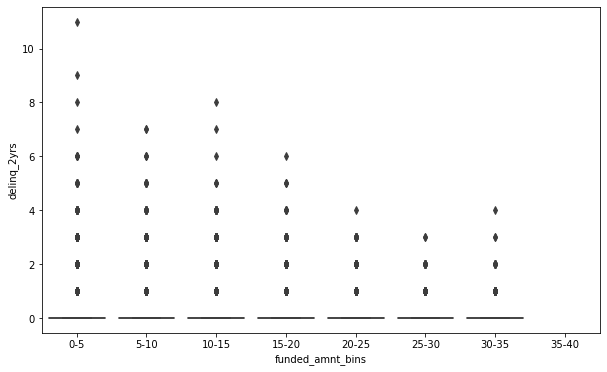

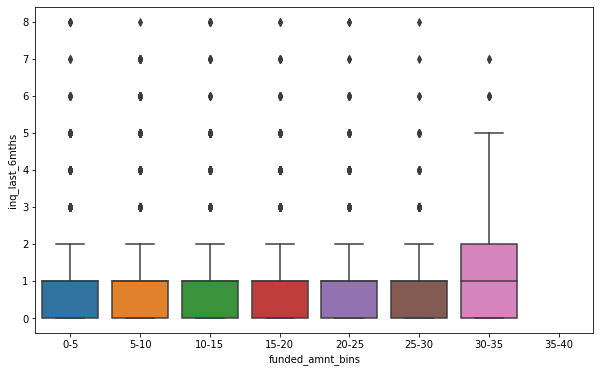

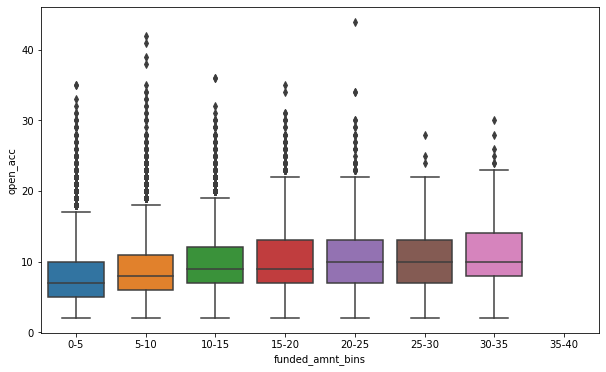

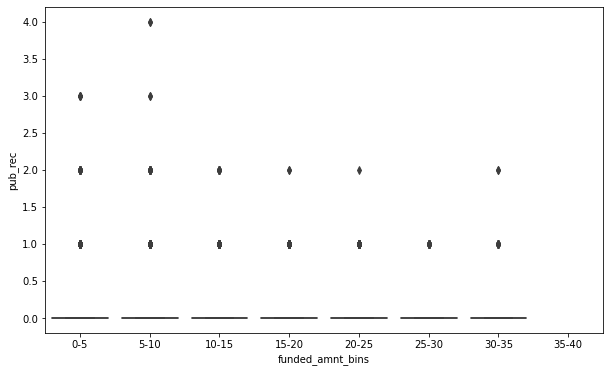

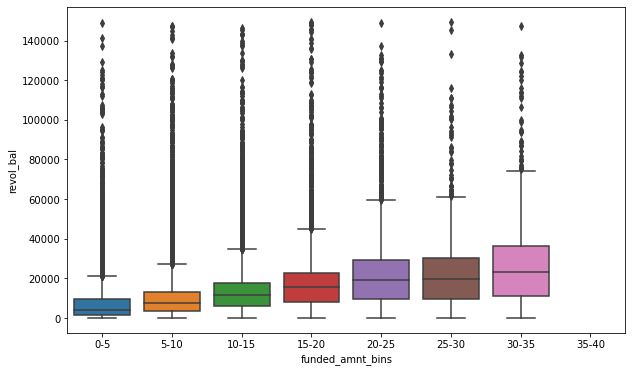

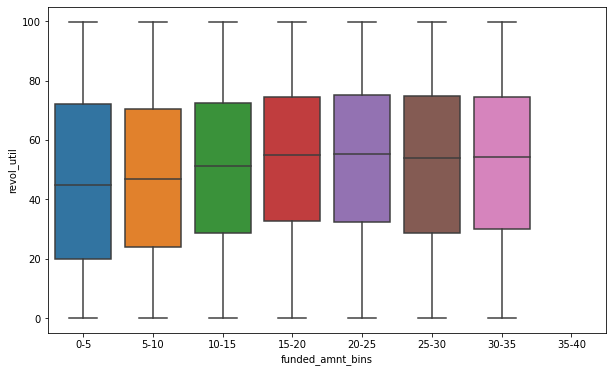

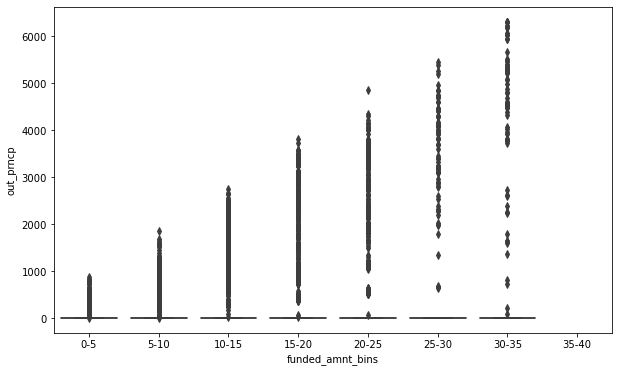

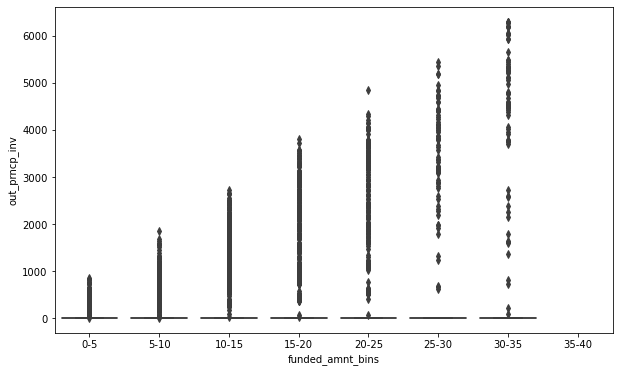

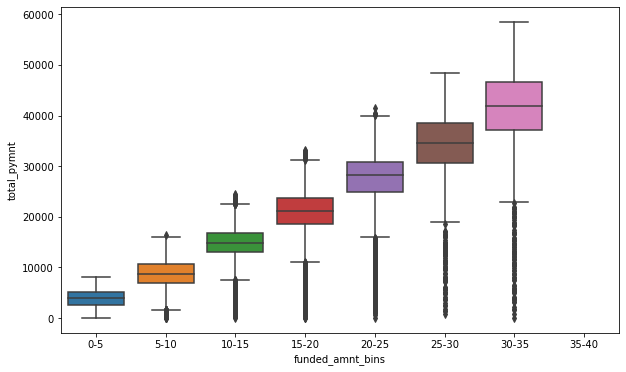

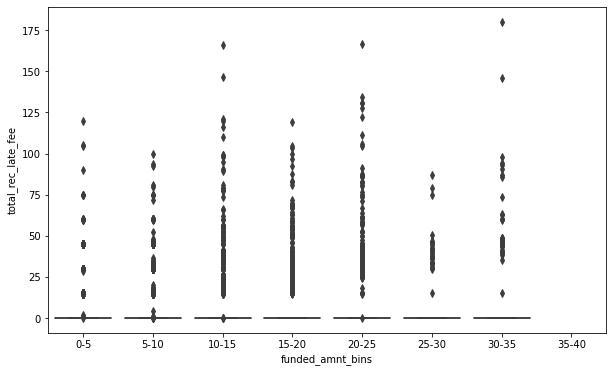

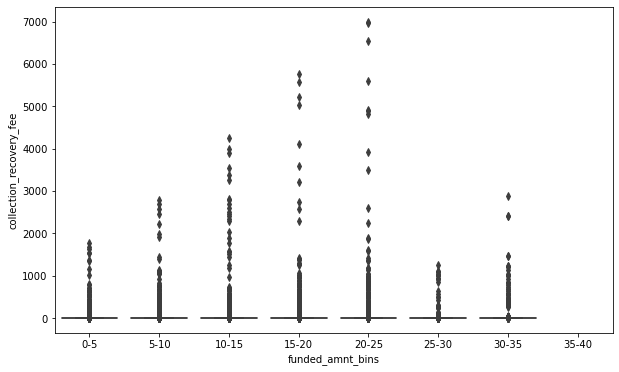

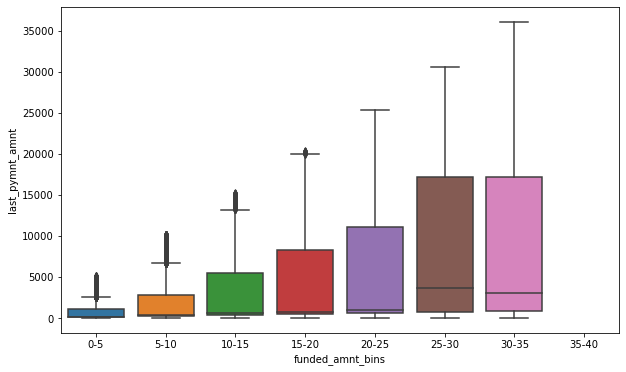

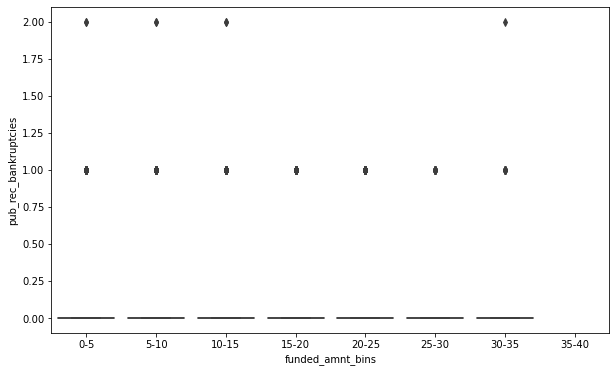

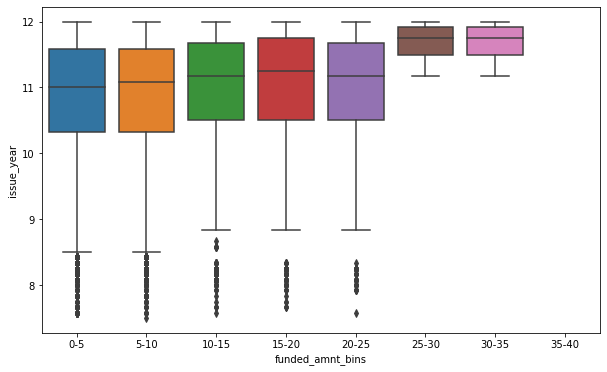

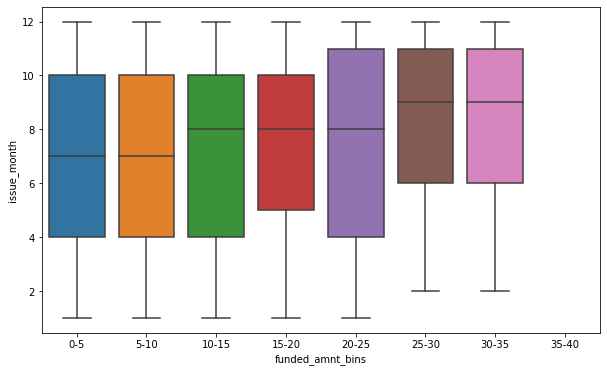

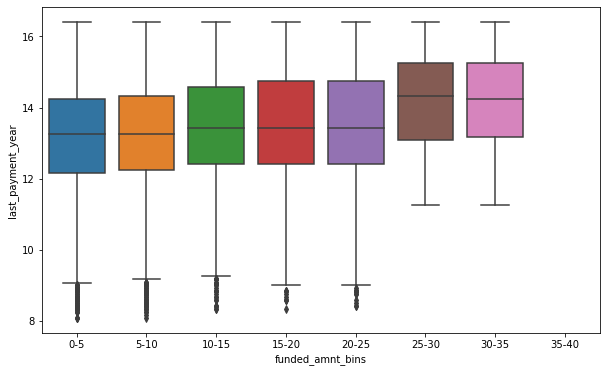

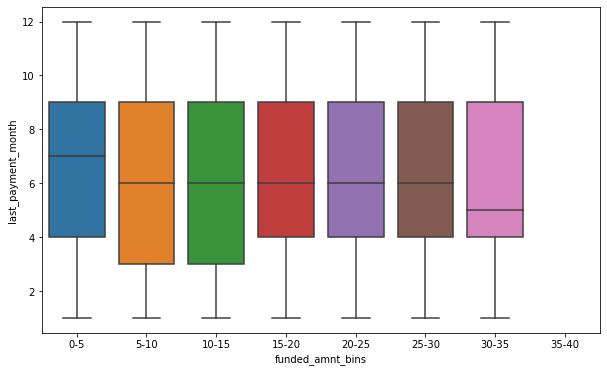

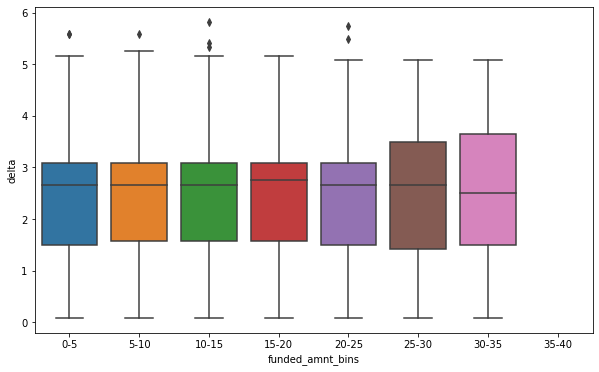

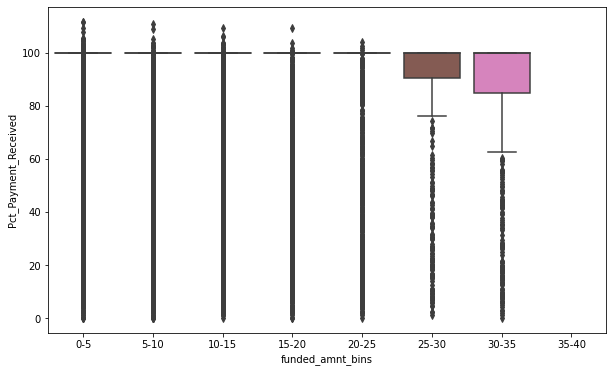

In [108]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="funded_amnt_bins", y=col,
                data=df)
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Higher the funded amount, higher is the interest rate as well.<br>$\Rightarrow$ When we look at the inquiries made in the last 6 months vs funded_amnt_bins, 30000-35000 categories have only one outlier. Borrowers in the range 35000-40000 have not made any inquiries.<br>$\Rightarrow$ People that borow a high amount, tend to have more open accounts too.<font><br>

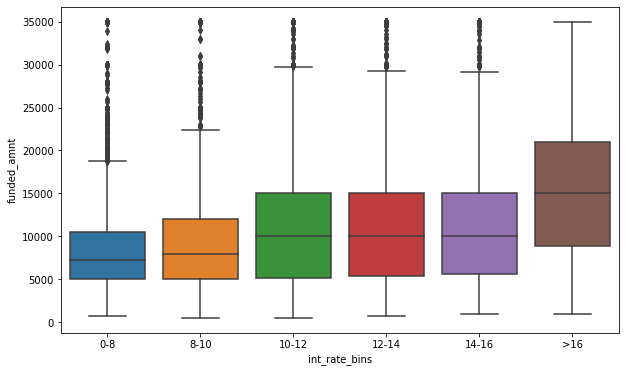

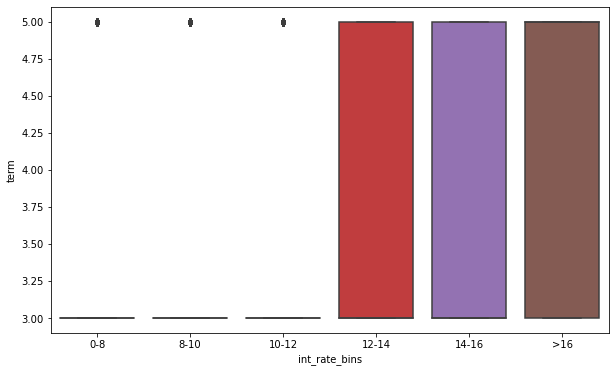

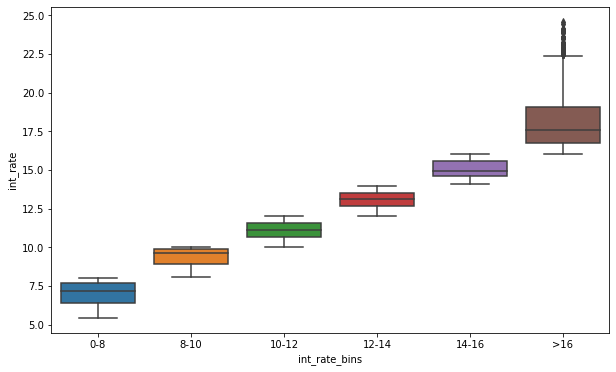

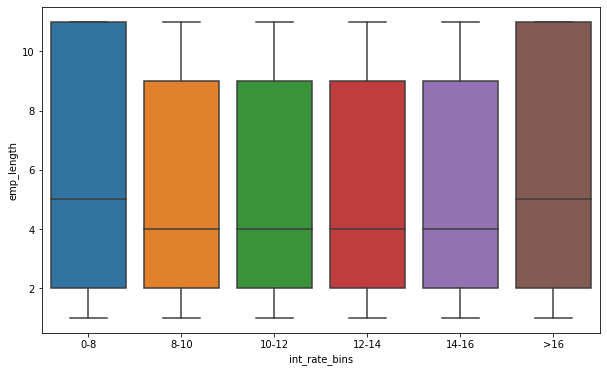

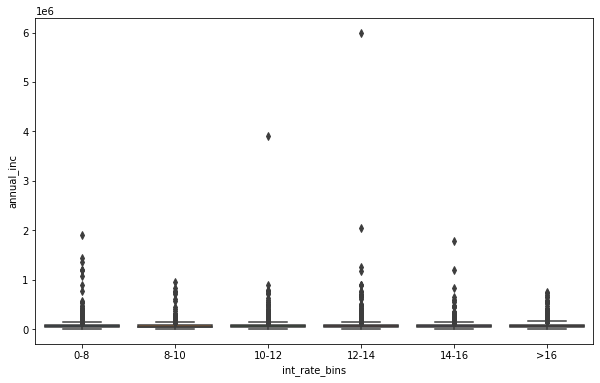

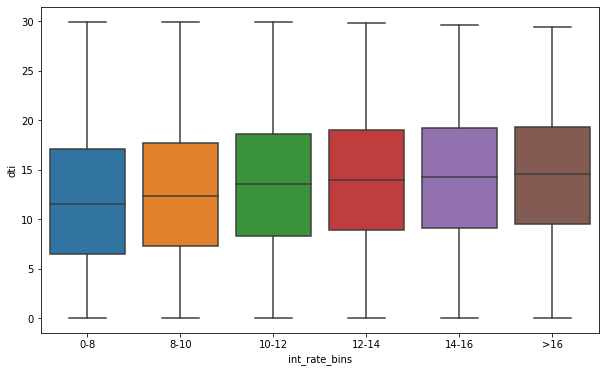

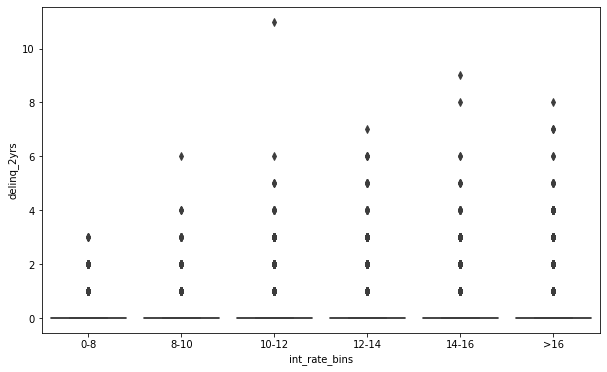

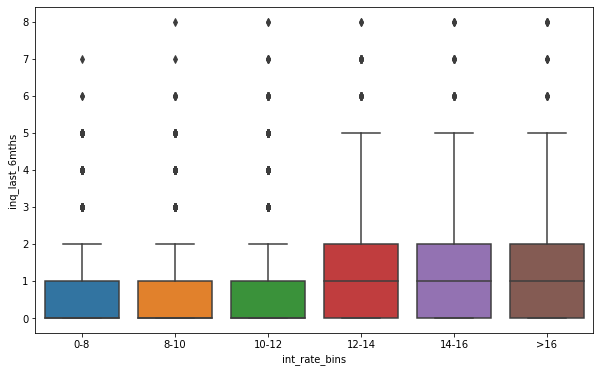

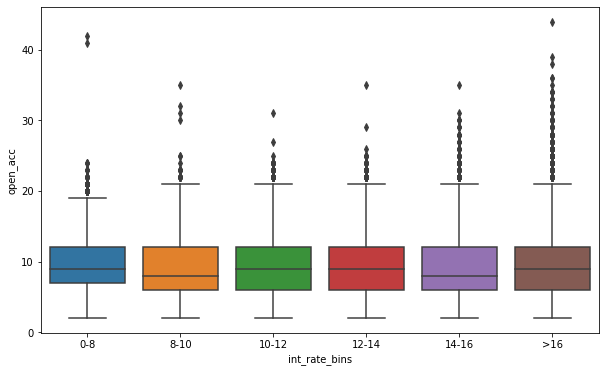

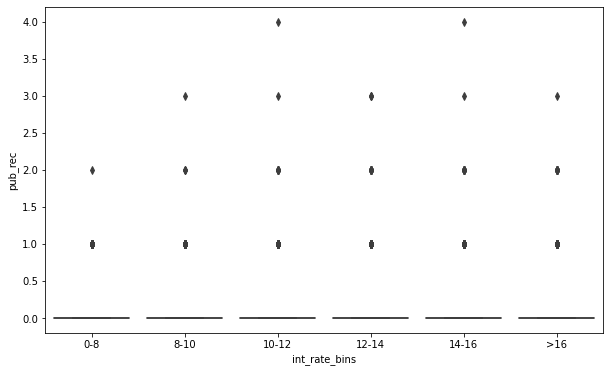

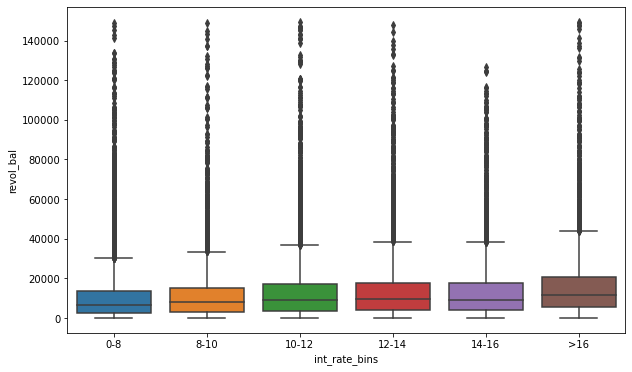

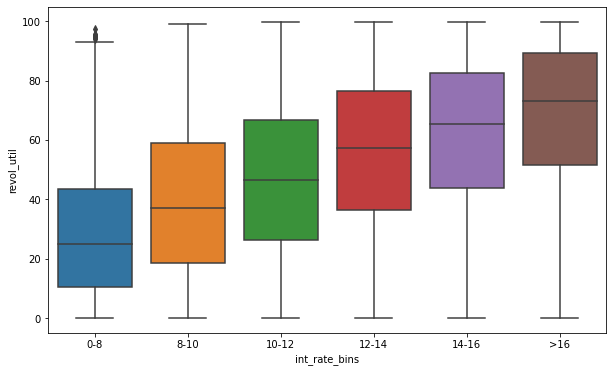

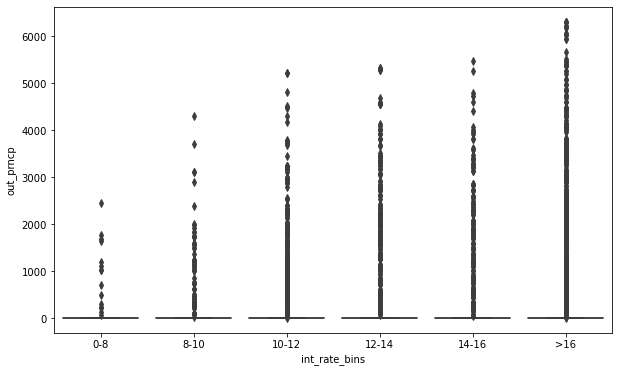

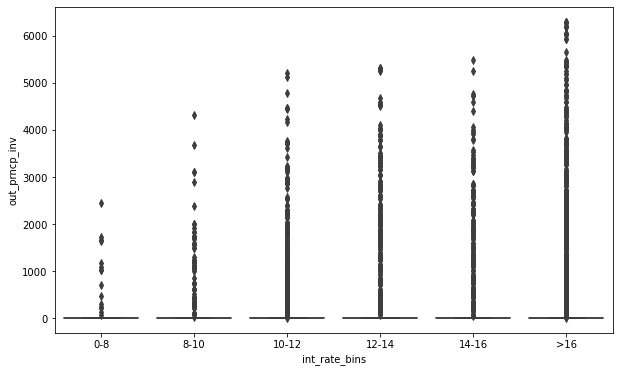

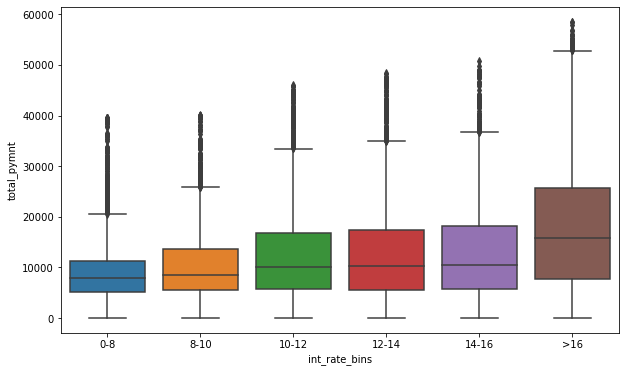

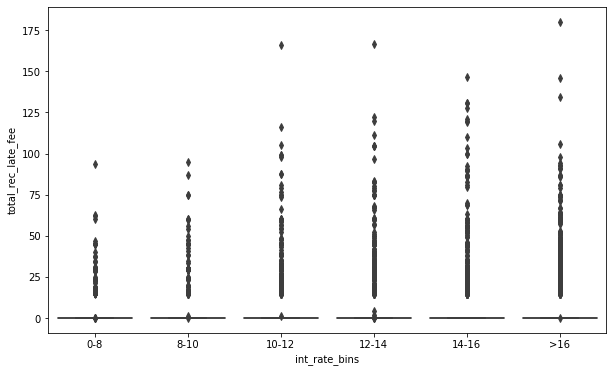

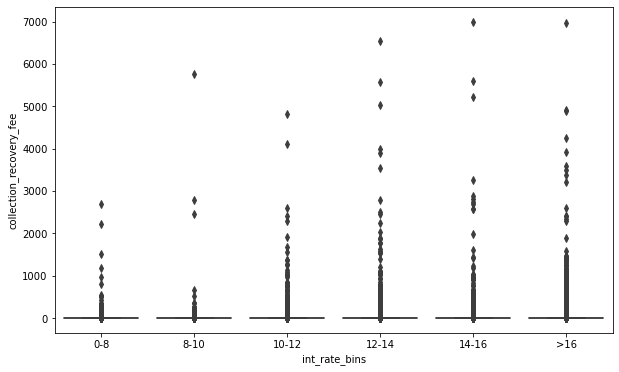

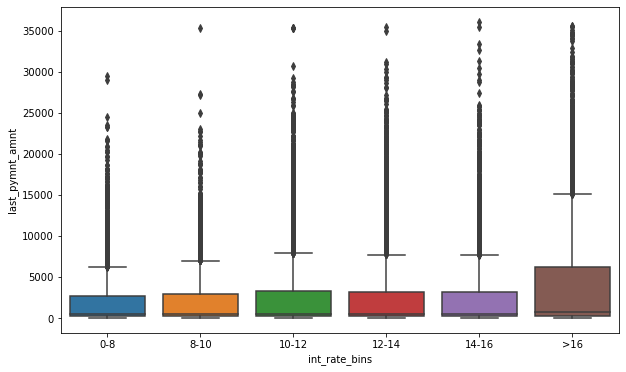

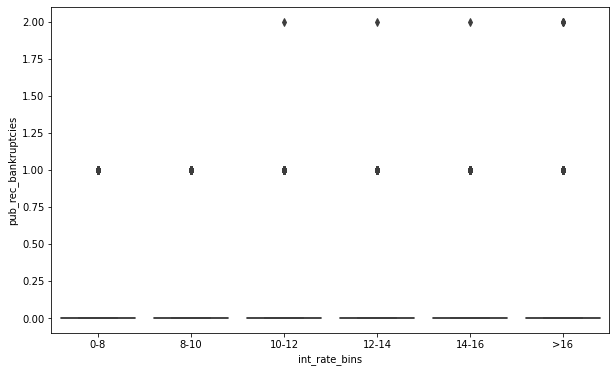

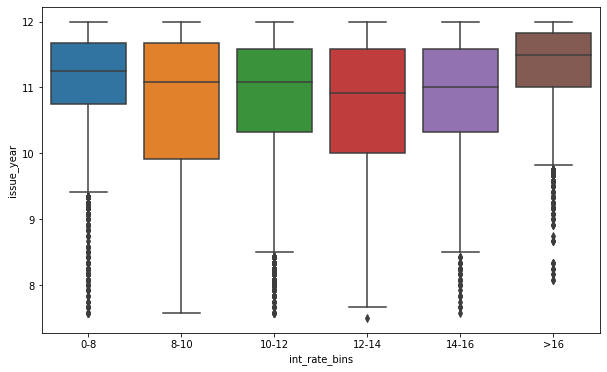

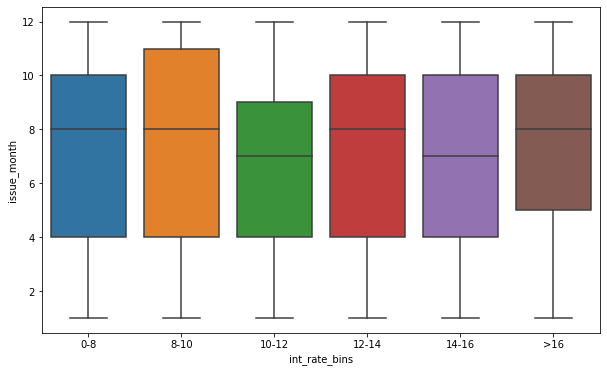

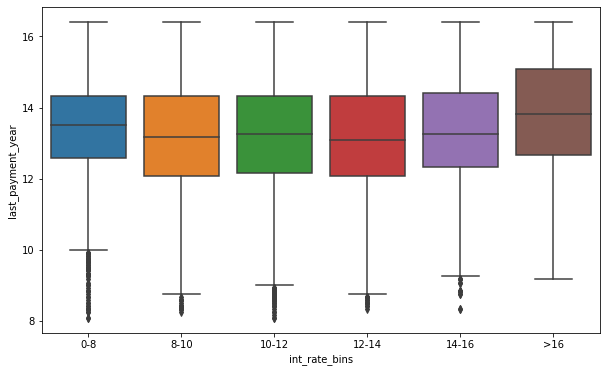

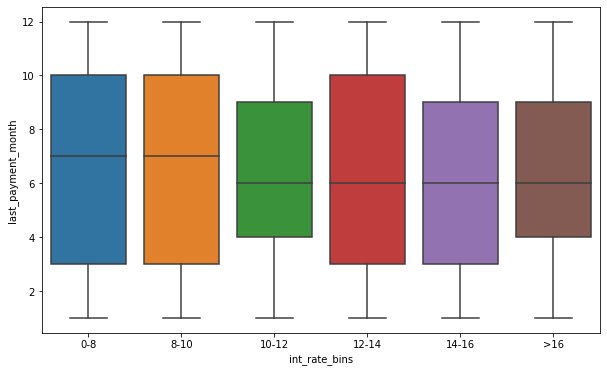

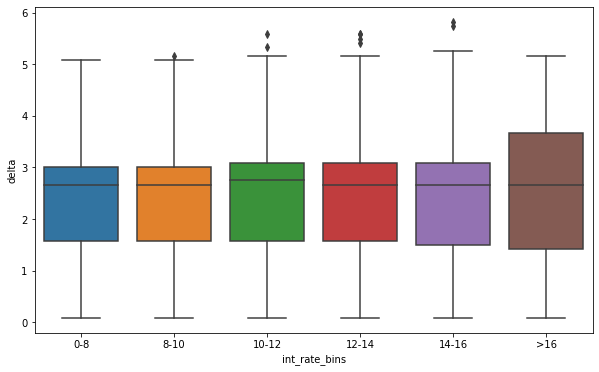

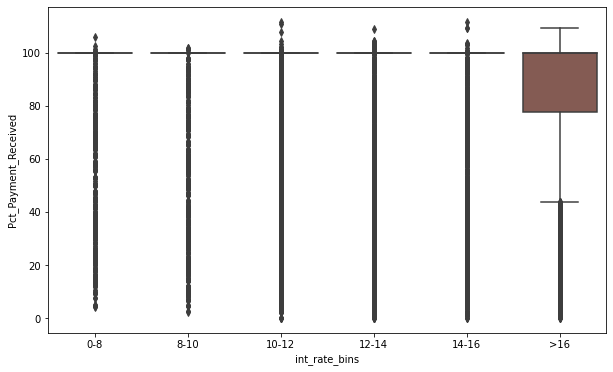

In [109]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="int_rate_bins", y=col,
                data=df)
    plt.show()

$\Rightarrow$ <font color="asparagus"> There are quite a few columns that seem to be heavily skewed towards one value. Eg: total_rec_late_fee, pub_rec, delinq_2yrs, annual_inc<br>
$\Rightarrow$ <font color="asparagus"> An IQR analysis will help us get a sense of the number of outliers 

### <font color='skyblue'>  II.7.2. IQR Analysis<font>

In [110]:
column_quantile_info ={}
for col in df_numeric.columns:
    Q1 = np.quantile(df[col], 0.25)
    Q2 = np.quantile(df[col], 0.5)
    Q3 = np.quantile(df[col], 0.75)
    Q4 = np.quantile(df[col], 0.99)
    Q5 = np.quantile(df[col], 0.01)
    IQR = Q3 - Q1
    column_quantile_info[col] = [Q1, Q2, Q3, IQR, Q3 + 1.5*IQR, Q1 - 1.5*IQR, Q4, Q5]

$\Rightarrow$ <font color="asparagus"> Let's just say outliers are those that are in the top 1% or bottom 1 %

In [111]:
upper_outlier_in_every_column = {}

In [112]:
for col in df_numeric.columns:
    #print((np.where(df[col] > column_quantile_info[col][6])))
    upper_outlier_in_every_column[col] = np.where(df[col] > column_quantile_info[col][6])

In [113]:
for col in df_numeric.columns:
    print(len(upper_outlier_in_every_column[col][0]))

0
0
390
0
398
396
322
260
372
60
398
398
398
398
398
398
398
398
7
0
0
0
0
237
79


$\Rightarrow$ <font color="asparagus"> That's a lot of outliers in every column. Let's try to see if there are any common rows among all columns <font>

In [114]:
common = np.intersect1d(upper_outlier_in_every_column["int_rate"], upper_outlier_in_every_column["last_pymnt_amnt"])

In [115]:
for col in df_numeric.columns:
    if len(upper_outlier_in_every_column[col][0]) > 300:
        common = np.intersect1d(common, upper_outlier_in_every_column[col][0])
        print(col, ": ", common)

int_rate :  [ 1156  1372  1482  1715  1799  1839  2157  2282  2654  2775  3308  3374
  3783  3901  4728  4817  4875  5168  5310  5432  5785  5966  6338  6456
  6485  6993  7764  7910 10146 10703 11582 14131 18893]
annual_inc :  [3783 3901 5168]
dti :  []
delinq_2yrs :  []
open_acc :  []
revol_bal :  []
revol_util :  []
out_prncp :  []
out_prncp_inv :  []
total_pymnt :  []
total_rec_late_fee :  []
collection_recovery_fee :  []
last_pymnt_amnt :  []


In [116]:
common

array([], dtype=int64)

In [117]:
lower_outlier_in_every_column = {}

In [118]:
for col in df_numeric.columns:
    #print((np.where(df[col] > column_quantile_info[col][6])))
    lower_outlier_in_every_column[col] = np.where(df[col] < column_quantile_info[col][7])

In [119]:
for col in df_numeric.columns:
    print(len(lower_outlier_in_every_column[col][0]))

328
0
0
0
328
392
0
0
0
0
0
0
0
0
398
0
0
398
0
251
0
396
0
302
398


In [120]:
lower_common = lower_outlier_in_every_column["funded_amnt"][0]

In [121]:
for col in df_numeric.columns:
    if len(lower_outlier_in_every_column[col][0]) > 300:
        lower_common = np.intersect1d(lower_common, lower_outlier_in_every_column[col][0])
        print(col, ": ", lower_common)

funded_amnt :  [   15   422   799  1390  1456  1675  1831  1880  1924  2140  2352  2691
  2740  2748  2842  2880  2944  3214  3668  3743  3822  3878  3950  4405
  4479  4535  4720  4890  4894  5487  5983  6017  6026  6062  6327  6391
  6392  6472  6635  6759  7089  7408  7434  7548  7984  7992  8008  8017
  8217  8308  8337  8806  9139  9245  9718  9973 10422 10452 10793 10816
 10839 11333 11421 11450 11572 11742 11991 12111 12238 12282 12318 12339
 12390 12454 12563 12957 12964 13187 13330 13379 13380 13629 13665 13721
 13726 13854 13956 13962 14113 14256 14261 14436 14442 14466 14500 14623
 14638 14698 14839 14949 15056 15085 15131 15206 15299 15517 15859 15902
 16034 16093 16277 16329 16485 16582 16790 16832 16858 16879 16894 16944
 17064 17137 17219 17330 17357 17513 18087 18303 18315 18389 18818 19035
 19721 19751 19951 20017 20209 20342 20350 20729 20772 20781 20960 21136
 21145 21171 21245 21285 21296 21535 22079 22202 22246 22337 22412 22593
 22596 22720 23006 23081 23232 23314

In [122]:
lower_common

array([], dtype=int64)

$\Rightarrow$ <font color="asparagus"> There are no common rows among all these columns. Let us leave them in because dropping so many columns will shrink the data drastically <font>

# <font color='goldenrod'> III. Data Analysis </font>

### <font color='skyblue'>  III.1. Univariate analysis<font>

#### <font color="asparagus"> *Observations and Comments*:<font><br>
$\Rightarrow$ <font color="asparagus">Previously when we looked at box plots in *II.7.1*, we were mainly focused on the outliers. Let's look at them now to get some details about the variables.<br> $\Rightarrow$ We will also look at the distribution plots for some numeric columns too. <font>

#### <font color="asparagus"> *Segregating the columns into categorical and numerical explicitly* <font> 

In [123]:
cat_cols = ["grade", "sub_grade", "term", "home_ownership", 
            "verification_status", "loan_status", 
            "purpose", "zip_code", "addr_state", "annual_inc_bins", 
            "funded_amnt_bins", "int_rate_bins", "emp_length_bins", 
            "delta", "delta_bins", "Pct_Payment_bins"]

In [124]:
not_cat_cols = [col for col in df.columns if col not in cat_cols]

In [125]:
df_numeric = df.select_dtypes(include=np.number)

In [126]:
cont_cols = df_numeric.columns.to_list()

In [127]:
cont_cols

['funded_amnt',
 'term',
 'int_rate',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_rec_late_fee',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'pub_rec_bankruptcies',
 'issue_year',
 'issue_month',
 'last_payment_year',
 'last_payment_month',
 'delta',
 'Pct_Payment_Received']

### <font color='skyblue'>  III.1.1. Box Plots<font>

In [128]:
list(df.loan_status.unique())

['Fully Paid', 'Charged Off', 'Current']

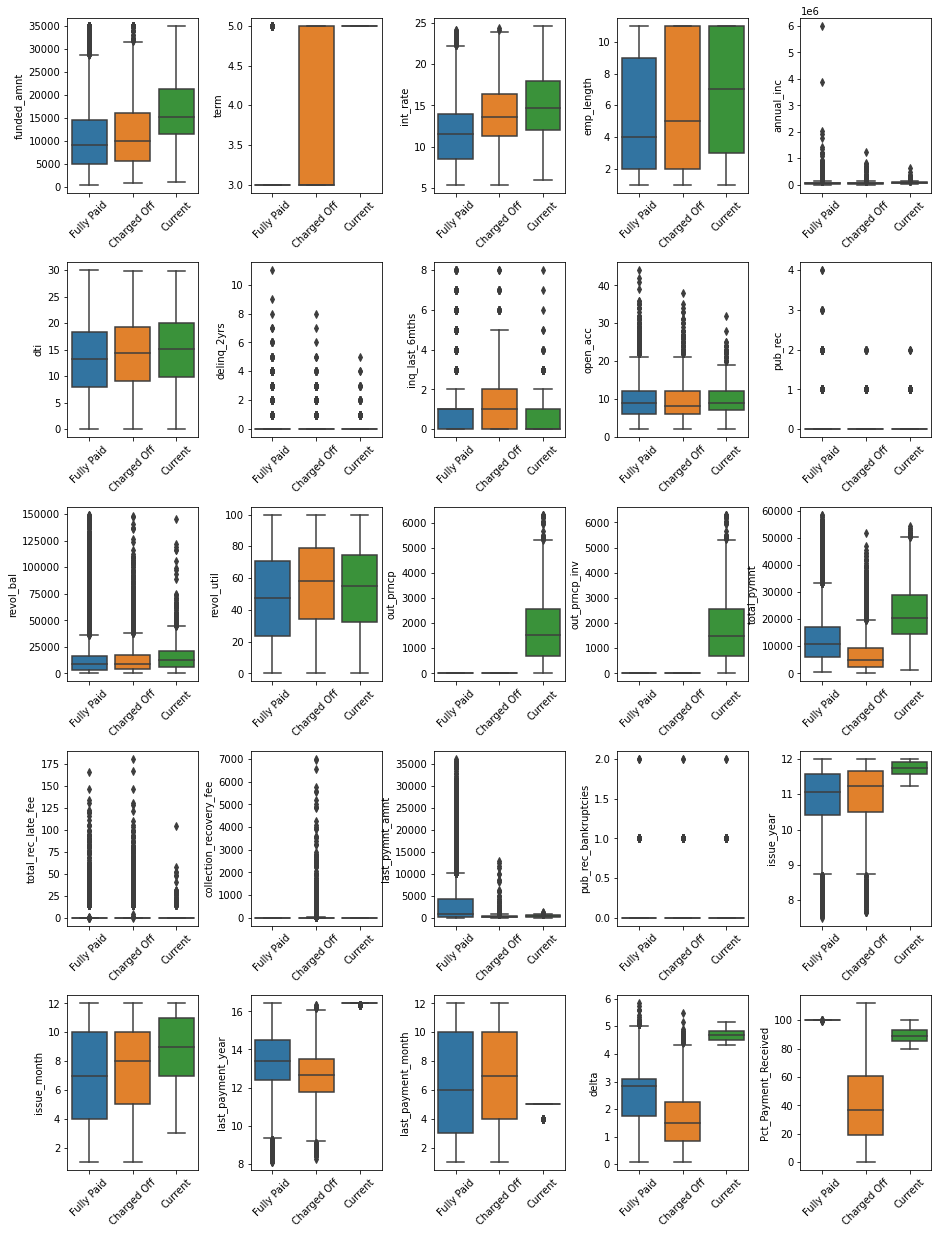

In [129]:
fig, axes = plt.subplots(5,5, figsize=(15,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for col, ax in zip(cont_cols, axes.flatten()):
    sns.boxplot(y=col, x= "loan_status", data=df, orient='v', ax=ax)
    ax.tick_params(colors="black", which="both")
    ax.set_xticklabels(['Fully Paid', 'Charged Off', 'Current'], rotation=45,color="black")
    ax.set(xlabel=None)
plt.show()


#### <font color="asparagus"> *Observations and Comments*:<font><br>
#### I am restricting to variables that might give us some insight about the data. If it is not revealing a lot, I will skip it in the comments below.
    
$\Rightarrow$ <font color="asparagus"> funded_amnt: <font>
    
For the loans that are currently running, the median of the funded amount lies around 15000 dollars. Charged off and Fully Paid loans hover around 10,000 dollars.
    
$\Rightarrow$ <font color="asparagus"> term: <font>
    
Currently running loans are borrowers that took 5 year loans, whereas *Charged Off* and *Fully Paid* loans have both 3 and 5 year loans.

$\Rightarrow$ <font color="asparagus"> int_rate: <font>
    
Interest rate is high for currently running loans, *fully paid* loans have the lowest interest rates. This indicates that higher interest rate attracts more defaults.

$\Rightarrow$ <font color="asparagus"> emp_length: <font>
    
Employees with an experience of around 4 years seem to successfully pay off their loans, whereas the defaulters seem to have close to 5 years of experience. Currently running loans have more than 7 years of experience.

$\Rightarrow$ <font color="asparagus"> annual_inc: <font>
    
The ones with a lower annual income are more likely to defualt on their loans. When we look at the box plot of annual_inc vs *Fully Paid* loans, we see that it has borrowers with very less to really high incomes.

$\Rightarrow$ <font color="asparagus"> dti: <font>
    
dti is around the same for all the loan statuses.    
    
$\Rightarrow$ <font color="asparagus"> inq_last_6mnths: <font>
    
The borrowers who defaulted seem to enquire at least once in a space of 6 months. There are outliers though, so it is hard to conclude a lot from this.        

$\Rightarrow$ <font color="asparagus"> total_payment: <font>
    
As expected, the payment received is th least for the defaulters. Currently running loans seem to be of higher value than the ones that charged off. Again, there are outliers, but my comments are focused on median values across the board.
    

$\Rightarrow$ <font color="asparagus"> Percent Payment received: <font>
    
This column that we derived also indicates the same thing as *total_payment*. *Charged Off* loans are in general paying less. Currently running loans seem to be close to 100% paid for.     

$\Rightarrow$ <font color="asparagus"> Issue year: <font>
    
Most of the *fully paid* and *charged off* loans were issued some time in the year 2011. Currently running loans are close to 2012, late 2011. 
    
$\Rightarrow$ <font color="asparagus"> Delta: <font>
    
This is a column we derived earlier. To recall, it indicates the amount of time passed from issue date to last payment. Most of the *fully paid* loans' last payment was 3 years ago, with some outliers ~ 6 years, indicating that we might have data which includes loans given in the past 6 years. We can see *Charged Off* box plot suggesting that we might have data > 6 years as well(with the outliers). 

### <font color='skyblue'>  III.1.1. Probability Distribution <font>

#### <font color="asparagus"> *Observations and Comments*:<font><br>
From our box plot analysis, I think it makes sense looking at the probablity distribution of funded_amnt, annual income, interest rate, emp_length, percentage payment received just to get a glimpse of the pdf.

In [130]:
distplots_cols = ["funded_amnt", "annual_inc", "int_rate", "Pct_Payment_Received", "emp_length"]

<Figure size 720x504 with 0 Axes>

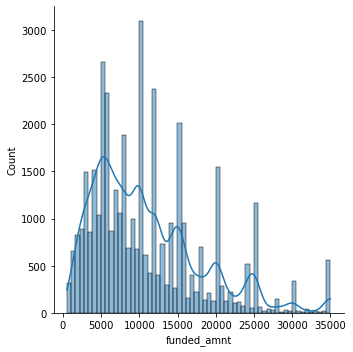

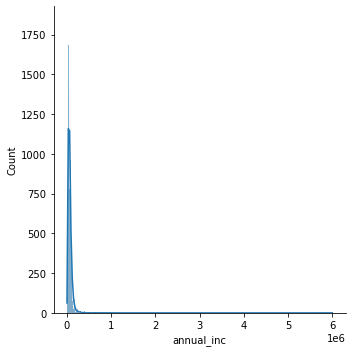

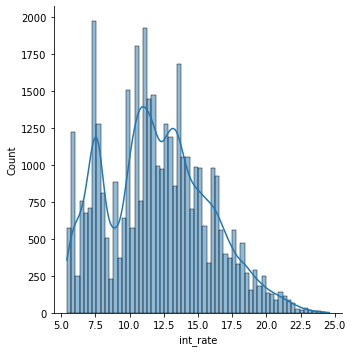

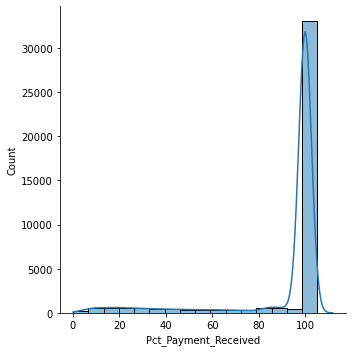

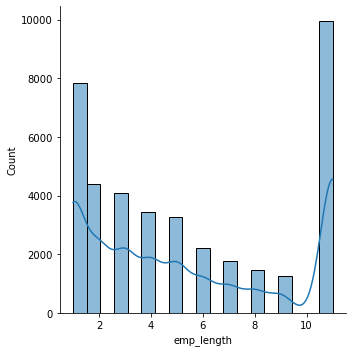

In [131]:
plt.figure(figsize=(10,7))
for idx, col in enumerate(distplots_cols):
    ax = sns.displot(data=df, x=col, kde=True)
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font><br>

$\Rightarrow$ <font color="asparagus"> annual_inc: <font>
    
Seems like most of the borrowers have incomes on the lower end. With the spike somwhere around 50000 to 100,000, calling describe() on annual_inc will give a us a clear picture.

$\Rightarrow$ <font color="asparagus"> int_rate: <font>
    
Most of the interest rate is in the range: 10-12.5%. With the highest spike at 7.5%

$\Rightarrow$ <font color="asparagus"> emp_length: <font>
    
Two spikes, one in the 0-2 years experience range and the other in the >10 years experience. 

In [132]:
df.annual_inc.describe()

count      39,717.00
mean       68,968.93
std        63,793.77
min         4,000.00
25%        40,404.00
50%        59,000.00
75%        82,300.00
max     6,000,000.00
Name: annual_inc, dtype: float64

# <font color='goldenrod'> III.2. Bivariate analysis </font>

#### <font color="asparagus"> *Comments*:<font> 
#### <font color="asparagus"> $\Rightarrow$ We've already studied the relation in between variables in the section *II.7. Correlation*.<br> $\Rightarrow$ We identified strongly correlated variables, removed some redundant columns.<br> $\Rightarrow$ We identified moderately and weakly correlated variables as well.<br> $\Rightarrow$ But now it's time to find some good indicators with groupbys, pivot tables and plots<font> 

### <font color='skyblue'>  III.2.1. Categorical columns with a keen focus on loan_status <font> 

<font color="asparagus"> Here are all the categorical columns. We won't group by all of them, but only ones that give us a good inference

In [133]:
cat_cols

['grade',
 'sub_grade',
 'term',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'zip_code',
 'addr_state',
 'annual_inc_bins',
 'funded_amnt_bins',
 'int_rate_bins',
 'emp_length_bins',
 'delta',
 'delta_bins',
 'Pct_Payment_bins']

##### $\Rightarrow$ <font color="asparagus"> III.2.1.1. Grade <font>

In [134]:
(df.groupby(by=["grade"]).mean())

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,issue_year,issue_month,last_payment_year,last_payment_month,delta,Pct_Payment_Received
grade,,,,,,,,,,,,,,,,,,,,,
A,"8,402.42",3.09,7.34,5.64,"66,648.85",12.05,0.04,0.68,9.44,0.01,...,0.54,3.02,"1,944.03",0.01,10.98,7.27,13.28,6.58,2.29,96.92
B,"10,861.34",3.45,11.02,5.46,"67,639.96",13.43,0.12,0.79,9.18,0.05,...,1.00,6.69,"2,673.27",0.04,10.93,7.21,13.37,6.46,2.44,93.14
C,"10,779.26",3.58,13.55,5.26,"67,939.20",13.89,0.19,1.08,9.16,0.08,...,1.74,15.56,"2,569.73",0.06,10.80,7.12,13.25,6.38,2.46,89.79
D,"12,069.79",3.78,15.72,5.39,"68,524.87",13.96,0.25,0.99,9.13,0.08,...,1.96,18.68,"2,887.00",0.06,10.88,7.01,13.37,6.33,2.49,86.75
E,"15,254.33",4.39,17.71,5.61,"77,989.41",14.09,0.24,0.98,9.52,0.08,...,2.58,28.45,"4,148.67",0.06,11.05,7.13,13.69,6.26,2.64,82.97
F,"17,688.42",4.60,19.75,5.77,"84,602.27",14.12,0.34,1.07,10.13,0.09,...,3.18,55.87,"4,627.52",0.07,11.16,7.12,13.78,6.31,2.63,79.40
G,"19,828.64",4.65,21.40,5.78,"94,386.47",14.01,0.41,0.98,10.66,0.08,...,4.57,54.36,"5,951.92",0.06,11.14,7.20,13.66,6.19,2.52,76.74


In [135]:
(df.groupby(by=["loan_status", "grade"]).mean())

funded_amnt  term  int_rate  emp_length  annual_inc   dti  \
loan_status grade                                                              
Charged Off A         7,625.66  3.12      7.60        5.86   52,510.37 13.35   
            B        10,564.42  3.62     11.12        5.61   59,637.70 13.82   
            C        10,763.21  3.75     13.60        5.62   58,642.15 14.43   
            D        11,914.65  3.96     15.84        5.62   62,356.42 13.97   
            E        15,270.10  4.51     17.86        5.63   73,260.93 14.18   
            F        18,520.53  4.65     19.99        6.09   80,346.77 14.01   
            G        18,283.42  4.58     21.50        5.54   78,869.33 13.80   
Current     A        10,174.38  5.00      8.41        7.08   58,432.60 13.78   
            B        16,742.03  5.00     11.48        7.19   70,308.96 14.99   
            C        16,239.49  5.00     14.13        6.30   74,102.42 15.00   
            D        15,119.03  5.00     17.06        6.26   74,045.06 14.74   
            E        17,424.16  5.00     18.92        6.60   80,940.21 14.98   
            F        20,794.86  5.00     21.16        7.00   99,579.70 12.97   
            G        19,419.12  5.00     22.96        5.76   96,376.71 13.59   
Fully Paid  A         8,444.44  3.08      7.31        5.62   67,584.99 11.96   
            B        10,704.68  3.37     10.99        5.38   68,662.63 13.32   
            C        10,560.38  3.49     13.52        5.14   69,618.87 13.73   
            D        11,942.87  3.66     15.61        5.28   69,954.38 13.91   
            E        15,049.15  4.29     17.55        5.51   79,453.81 13.98   
            F        16,939.23  4.53     19.47        5.48   85,004.33 14.30   
            G        20,652.02  4.65     21.22        5.91  102,130.90 14.15   

                   delinq_2yrs  inq_last_6mths  open_acc  pub_rec  ...  \
loan_status grade                                                  ...   
Charged Off A             0.07            0.86      9.08     0.02  ...   
            B             0.11            0.94      9.16     0.07  ...   
            C             0.16            1.23      9.03     0.10  ...   
            D             0.21            1.14      9.12     0.10  ...   
            E             0.22            0.99      9.17     0.10  ...   
            F             0.34            1.10      9.68     0.11  ...   
            G             0.42            1.05     11.23     0.16  ...   
Current     A             0.00            0.00     11.30     0.00  ...   
            B             0.05            0.46      9.60     0.01  ...   
            C             0.08            1.08      9.85     0.03  ...   
            D             0.19            0.79      9.71     0.08  ...   
            E             0.29            0.99     10.42     0.07  ...   
            F             0.37            1.01     10.22     0.11  ...   
            G             0.12            1.41     11.47     0.00  ...   
Fully Paid  A             0.04            0.67      9.45     0.01  ...   
            B             0.12            0.78      9.17     0.05  ...   
            C             0.20            1.05      9.16     0.07  ...   
            D             0.26            0.95      9.10     0.07  ...   
            E             0.25            0.97      9.56     0.07  ...   
            F             0.33            1.06     10.35     0.08  ...   
            G             0.43            0.91     10.30     0.04  ...   

                   total_rec_late_fee  collection_recovery_fee  \
loan_status grade                                                
Charged Off A                    3.07                    50.66   
            B                    3.26                    56.45   
            C                    4.61                    93.57   
            D                    4.61                    88.66   
            E                    4.83                   113.10   
            F

#### <font color="asparagus"> *Observations and Comments*:<font><br>
$\Rightarrow$ <font color="asparagus">You can see that borrowers with bad credit ratings tend to borrow more money. Let's try some pivot tables and then plot a pie chart. <font>

In [136]:
df.pivot_table(index="grade",columns=["loan_status"], values="funded_amnt", aggfunc="mean")

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,"7,625.66","10,174.38","8,444.44"
B,"10,564.42","16,742.03","10,704.68"
C,"10,763.21","16,239.49","10,560.38"
D,"11,914.65","15,119.03","11,942.87"
E,"15,270.10","17,424.16","15,049.15"
F,"18,520.53","20,794.86","16,939.23"
G,"18,283.42","19,419.12","20,652.02"


#### $\Rightarrow$ <font color="asparagus"> Let's get some numbers<font>
1. How many people of a certain grade borrowed?
2. How many of them defaulted, how many are currently paying/have fully paid?

#### $\Rightarrow$ <font color="asparagus">  Getting the grade-wise percentage for the three loan statuses we have

#### Let's look at the distribution of charged off loans based on grades



In [137]:
df_chargedOff = df[df["loan_status"] == "Charged Off"].groupby(by="grade").size()

In [138]:
df_chargedOff

grade
A     602
B    1425
C    1347
D    1118
E     715
F     319
G     101
dtype: int64

In [139]:
grade_labels = sorted(df.grade.unique())

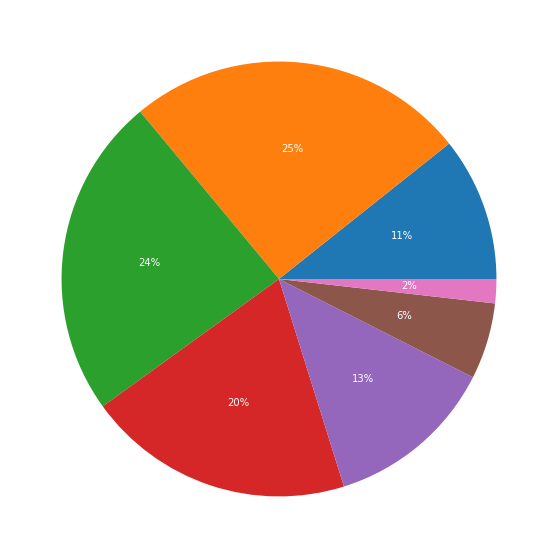

In [140]:
plt.figure(figsize=(10,10))
plt.pie(df_chargedOff,labels=grade_labels,autopct='%.0f%%', textprops={'color':"w"})
plt.show()

#### <font color="asparagus"> $\Rightarrow$ Observation and comments:
1. Looking at this, it seems B,C D are more likely to default. But it kind of goes against our assumption: "people with lower credit score are more likely to default". 
2. It seems to be deceptive. We must see gradewise percent of people that have defaulted. 

#### <font color="asparagus"> $\Rightarrow$  Gradewise distribution

#### <font color="asparagus"> $\Rightarrow$ Before we proceed further, let's define a generic function that returns the percentage of charged Off, current and fully paid borrowers.<br> $\Rightarrow$We must provide the bins across which we want to calucate the aforementioned percentags as an input argument. <br> $\Rightarrow$Finally, we use this to plot pie charts

In [141]:
def calculate_groupwise_loan_status_percentage(bins_list, df, col):
    groupwise_dist ={}
    for curr_bin in bins_list:
        nChargedOff = len(df[(df[col] == curr_bin) & (df["loan_status"] == "Charged Off")])
        nCurrent = len(df[(df[col] == curr_bin) & (df["loan_status"] == "Current")])
        nFullyPaid = len(df[(df[col] == curr_bin) & (df["loan_status"] == "Fully Paid")])
        totalNoOfPeople = len(df[df[col] == curr_bin])
        if totalNoOfPeople > 0:
            groupwise_dist[curr_bin] = [round(100 *nChargedOff/totalNoOfPeople,2), round(100 *nCurrent/totalNoOfPeople,2), round(100 *nFullyPaid/totalNoOfPeople,2)]
        else:
            groupwise_dist[curr_bin] = [0] *3
    return groupwise_dist

#### Defining another function that will return a pivot table, indexed by a particular column. It also also three new columns: pct_chargedOff, pct_current, pct_fullyPaid and return the grouped df. <br> This function will regularly be consumed by other columns too.

In [142]:
def get_grouped_df(df, col):
    df_grouped = df.groupby([col, "loan_status"]).loan_status.count().unstack().fillna(0)
    df_grouped["pct_chargedOff"] = 100 *(df_grouped["Charged Off"]) /( df_grouped["Charged Off"] + df_grouped["Current"] + df_grouped["Fully Paid"])
    df_grouped["pct_current"] = 100 *(df_grouped["Current"]) /( df_grouped["Charged Off"] + df_grouped["Current"] + df_grouped["Fully Paid"])
    df_grouped["pct_fullyPaid"] = 100 *(df_grouped["Fully Paid"]) /( df_grouped["Charged Off"] + df_grouped["Current"] + df_grouped["Fully Paid"])
    return df_grouped

In [143]:
grade_wise_split = calculate_groupwise_loan_status_percentage(grade_labels, df, "grade")

In [144]:
grade_wise_split

{'A': [5.97, 0.4, 93.63],
 'B': [11.86, 2.87, 85.27],
 'C': [16.63, 3.26, 80.11],
 'D': [21.07, 4.18, 74.75],
 'E': [25.16, 6.3, 68.54],
 'F': [30.41, 6.96, 62.63],
 'G': [31.96, 5.38, 62.66]}

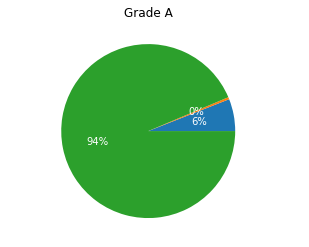

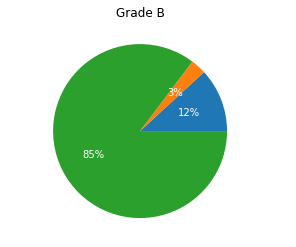

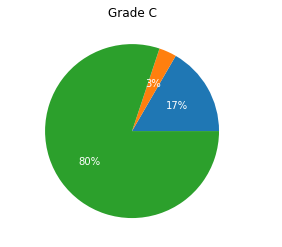

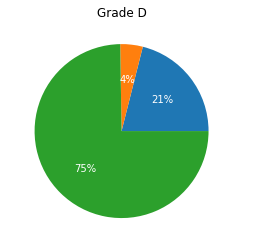

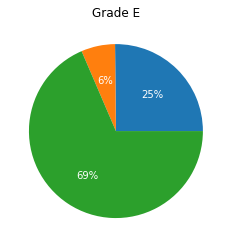

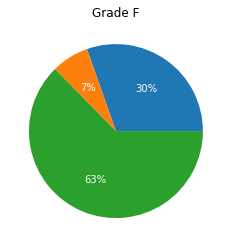

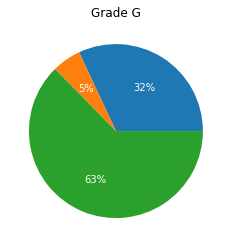

In [145]:
#plt.figure(figsize=(10,15))
for label in grade_labels:
    plt.pie(grade_wise_split[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f"Grade {label}")
    plt.show()


#### <font color="asparagus"> $\Rightarrow$ Observation and comments:
1. Now the above pie charts tell the true story and it is in line with our initial assumption: Bad credit score = More likely to default<br>
2. As you can see Grade A has only 6% charged off loans, and the lower you go the in grade, the higher the percentage. Eg: Grade G: Charged off percentage: 32%

In [146]:
# I can safely append grade to the indicators list based on our analysis above
indicators.append("grade")

##### $\Rightarrow$ <font color="asparagus"> III.2.1.2. Home Ownership <font>

In [147]:
(df.groupby(by=["home_ownership", "loan_status"]).mean())

funded_amnt  term  int_rate  emp_length  \
home_ownership loan_status                                            
MORTGAGE       Charged Off    13,587.24  3.98     13.79        6.56   
               Current        17,878.06  5.00     14.64        7.31   
               Fully Paid     11,880.18  3.53     11.33        6.42   
NONE           Fully Paid      5,600.00  3.00      8.70        2.33   
OTHER          Charged Off    13,326.39  3.11     13.19        4.78   
               Fully Paid      9,433.75  3.00     11.78        4.24   
OWN            Charged Off    10,761.46  3.86     13.70        6.05   
               Current        14,346.39  5.00     14.77        7.12   
               Fully Paid      9,783.97  3.38     11.34        6.00   
RENT           Charged Off    10,395.10  3.75     13.87        4.89   
               Current        14,789.38  5.00     15.69        5.62   
               Fully Paid      9,575.37  3.35     11.92        4.35   

                            annual_inc   dti  delinq_2yrs  inq_last_6mths  \
home_ownership loan_status                                                  
MORTGAGE       Charged Off   75,242.51 14.23         0.18            1.17   
               Current       85,675.50 14.70         0.16            0.77   
               Fully Paid    84,252.90 12.93         0.15            0.93   
NONE           Fully Paid    80,733.33 11.75         0.00            0.67   
OTHER          Charged Off   63,433.06 13.13         0.39            1.28   
               Fully Paid    73,081.96 10.83         0.30            1.04   
OWN            Charged Off   53,908.05 13.79         0.21            1.05   
               Current       57,972.24 14.86         0.11            0.78   
               Fully Paid    59,759.51 13.08         0.15            0.86   
RENT           Charged Off   53,246.22 13.85         0.16            0.97   
               Current       63,289.47 14.80         0.13            0.81   
               Fully Paid    57,960.33 13.37         0.13            0.75   

                            open_acc  pub_rec  ...  total_rec_late_fee  \
home_ownership loan_status                     ...                       
MORTGAGE       Charged Off     10.37     0.10  ...                4.03   
               Current         10.47     0.04  ...                1.19   
               Fully Paid      10.27     0.06  ...                0.69   
NONE           Fully Paid       7.00     0.00  ...                0.00   
OTHER          Charged Off      9.61     0.11  ...                1.99   
               Fully Paid       8.71     0.03  ...                3.99   
OWN            Charged Off      8.66     0.07  ...                4.69   
               Current          9.17     0.05  ...                1.10   
               Fully Paid       9.02     0.05  ...                1.27   
RENT           Charged Off      8.28     0.08  ...                4.46   
               Current          9.28     0.05  ...                1.15   
               Fully Paid       8.42     0.04  ...                0.95   

                            collection_recovery_fee  last_pymnt_amnt  \
home_ownership loan_status                                             
MORTGAGE       Charged Off                   102.88           365.49   
               Current                         0.00           427.92   
               Fully Paid                      0.00         3,755.41   
NONE           Fully Paid                      0.00           177.72   
OTHER          Charged Off                   101.83           376.91   
               Fully Paid                      0.00         2,080.69   
OWN            Charged Off                   103.77           339.21   
               Current                         0.00           348.91   
               Fully Paid                      0.00         3,179.20   
RENT           Charged Off                    72.39           291.29   
               Current                         0.00  

#### <font color="asparagus"> *Observations and comments* <font>
$\Rightarrow$ The table above does not seem to give us a good picture. Can't seem to get a good segragation.<br> $\Rightarrow$ Let's define another function that will return a pivot table, indexed by a particular column. It also adds three new columns: pct_chargedOff, pct_current, pct_fullyPaid and return the grouped df. <br> $\Rightarrow$This function will regularly be consumed by other columns too.


In [148]:
home_owner_group = get_grouped_df(df, "home_ownership")

In [149]:
home_owner_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
home_ownership,,,,,,
MORTGAGE,"2,327.00",638.00,"14,694.00",13.18,3.61,83.21
NONE,0.00,0.00,3.00,0.00,0.00,100.00
OTHER,18.00,0.00,80.00,18.37,0.00,81.63
OWN,443.00,83.00,"2,532.00",14.49,2.71,82.80
RENT,"2,839.00",419.00,"15,641.00",15.02,2.22,82.76


#### <font color="asparagus"> *Observations and comments* <font>
$\Rightarrow$ The above table looks cleaner. But there doesn't seem to be any pattern emerging. I was hoping to see borrowers with mortgage and rent to have more defaults, but that's not the case. *OTHER* has the highest charged off percentage.<br> $\Rightarrow$  Home_ownership is probably not a good indicator for default

##### $\Rightarrow$ <font color="asparagus"> III.2.1.3. Verification Status

 #### <font color="asparagus" > <br> 1. Not verified: Default Percentage: 1266% <br> 2. Source Verified: 14.36% <br> 3. Verified: 16.01% <font>

In [150]:
(df.groupby(by=["verification_status", "loan_status"]).mean())

funded_amnt  term  int_rate  emp_length  \
verification_status loan_status                                            
Not Verified        Charged Off     8,505.72  3.46     12.69        5.30   
                    Current        10,807.05  5.00     13.59        6.74   
                    Fully Paid      8,223.37  3.23     10.95        5.17   
Source Verified     Charged Off    10,396.30  4.00     14.13        5.24   
                    Current        13,733.31  5.00     15.13        5.83   
                    Fully Paid      9,645.29  3.48     11.64        5.08   
Verified            Charged Off    16,094.02  4.16     14.78        6.35   
                    Current        20,038.43  5.00     15.53        7.08   
                    Fully Paid     14,840.74  3.67     12.53        5.99   

                                 annual_inc   dti  delinq_2yrs  \
verification_status loan_status                                  
Not Verified        Charged Off   55,583.20 13.80         0.18   
                    Current       57,811.27 14.95         0.13   
                    Fully Paid    61,908.73 12.88         0.14   
Source Verified     Charged Off   60,708.45 12.89         0.16   
                    Current       74,307.98 12.87         0.16   
                    Fully Paid    69,592.40 12.56         0.15   
Verified            Charged Off   70,776.82 14.99         0.17   
                    Current       82,640.67 15.64         0.13   
                    Fully Paid    81,479.41 14.02         0.15   

                                 inq_last_6mths  open_acc  pub_rec  ...  \
verification_status loan_status                                     ...   
Not Verified        Charged Off            1.08      9.02     0.09  ...   
                    Current                0.78      9.38     0.02  ...   
                    Fully Paid             0.83      9.01     0.05  ...   
Source Verified     Charged Off            1.04      8.70     0.09  ...   
                    Current                0.64      9.71     0.05  ...   
                    Fully Paid             0.83      8.99     0.05  ...   
Verified            Charged Off            1.05      9.68     0.08  ...   
                    Current                0.86     10.26     0.05  ...   
                    Fully Paid             0.86      9.94     0.05  ...   

                                 total_rec_late_fee  collection_recovery_fee  \
verification_status loan_status                                                
Not Verified        Charged Off                4.38                    75.48   
                    Current                    1.39                     0.00   
                    Fully Paid                 0.93                     0.00   
Source Verified     Charged Off                3.73                    53.62   
                    Current                    0.90                     0.00   
                    Fully Paid                 0.69                     0.00   
Verified            Charged Off                4.59                   123.93   
                    Current                    1.23                     0.00   
                    Fully Paid                 0.92                     0.00   

                                 last_pymnt_amnt  pub_rec_bankruptcies  \
verification_status loan_status                                          
Not Verified        Charged Off           266.86                  0.07   
                    Current               250.13                  0.02   
                    Fully Paid          2,084.43                  0.04   
Source Verified     Charged Off           295.21                  0.07   
                    Current               331.96                  0.04   
                    Fully Paid          2,941.83                  0.04   
Verified            Charged Off           409.35                  0.06   
                    Current               486.61                  0.04   
                    Fu

In [151]:
verif_status_group = get_grouped_df(df,"verification_status")

In [152]:
verif_status_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
verification_status,,,,,,
Not Verified,2142,227,14552,12.66,1.34,86.00
Source Verified,1434,310,8243,14.36,3.10,82.54
Verified,2051,603,10155,16.01,4.71,79.28


#### <font color="asparagus"> *Observations and comments* <font>
$\Rightarrow$ No pattern emerging here other. 

##### $\Rightarrow$ <font color="asparagus"> III.2.1.4. Purpose

In [153]:
(df.groupby(by=["purpose"]).mean())

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,issue_year,issue_month,last_payment_year,last_payment_month,delta,Pct_Payment_Received
purpose,,,,,,,,,,,,,,,,,,,,,
car,"6,714.30",3.72,10.53,5.43,"61,842.04",11.16,0.15,0.88,8.61,0.06,...,1.03,4.99,"1,696.72",0.04,10.99,6.66,13.56,6.23,2.56,94.38
credit_card,"11,452.15",3.41,11.70,5.41,"70,439.15",14.61,0.11,0.75,9.82,0.06,...,1.07,11.72,"2,692.51",0.05,10.93,7.42,13.38,6.52,2.45,93.81
debt_consolidation,"12,388.70",3.59,12.49,5.53,"67,322.06",14.48,0.13,0.82,9.68,0.06,...,1.32,13.95,"3,108.17",0.05,10.99,7.26,13.43,6.43,2.44,90.83
educational,"6,692.08",3.10,11.65,4.02,"53,471.37",11.21,0.15,1.11,8.91,0.04,...,2.35,18.67,"1,202.28",0.02,9.61,6.40,11.87,6.62,2.26,90.98
home_improvement,"11,220.45",3.60,11.40,6.39,"89,736.78",11.13,0.18,1.10,9.45,0.07,...,1.25,5.95,"2,981.71",0.05,10.95,7.07,13.43,6.45,2.48,92.83
house,"12,712.60",3.64,12.23,5.41,"76,772.28",10.67,0.17,1.46,8.58,0.05,...,1.58,10.22,"3,573.72",0.04,10.92,7.09,13.17,6.22,2.25,89.99
major_purchase,"7,970.24",3.42,10.84,5.26,"66,391.52",10.82,0.17,0.85,8.23,0.04,...,1.10,7.03,"2,030.70",0.02,10.89,6.79,13.27,6.34,2.38,93.97
medical,"8,103.39",3.48,11.49,5.66,"68,252.86",12.17,0.20,0.92,9.03,0.09,...,1.39,7.16,"1,967.33",0.06,10.94,7.14,13.35,6.48,2.41,90.17
moving,"6,506.95",3.34,11.56,4.28,"61,801.58",11.74,0.16,0.90,8.17,0.05,...,1.77,4.49,"1,460.02",0.04,10.93,7.30,13.31,6.84,2.38,91.13


In [154]:
purpose_grouped = get_grouped_df(df,"purpose")

In [155]:
purpose_grouped

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
purpose,,,,,,
car,160.00,50.00,"1,339.00",10.33,3.23,86.44
credit_card,542.00,103.00,"4,485.00",10.57,2.01,87.43
debt_consolidation,"2,767.00",586.00,"15,288.00",14.84,3.14,82.01
educational,56.00,0.00,269.00,17.23,0.00,82.77
home_improvement,347.00,101.00,"2,528.00",11.66,3.39,84.95
house,59.00,14.00,308.00,15.49,3.67,80.84
major_purchase,222.00,37.00,"1,928.00",10.15,1.69,88.16
medical,106.00,12.00,575.00,15.30,1.73,82.97
moving,92.00,7.00,484.00,15.78,1.20,83.02


#### <font color="asparagus"> *Observations and comments* <font>
Certain purposes pop out. Let's try a pie chart.

In [156]:
purpose_labels = sorted(df.purpose.unique())

In [157]:
purpose_dist = calculate_groupwise_loan_status_percentage(purpose_labels, df, "purpose")

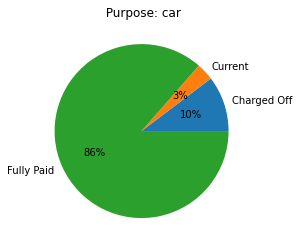

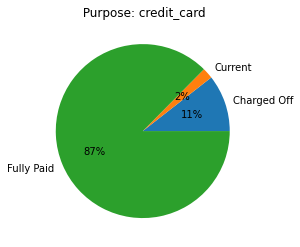

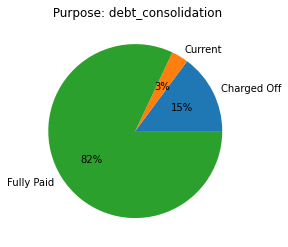

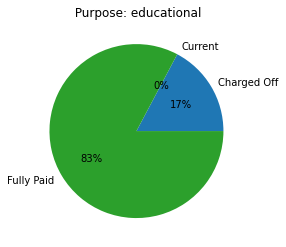

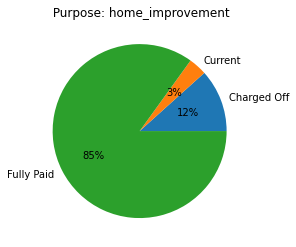

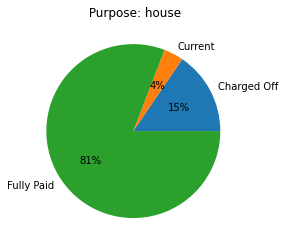

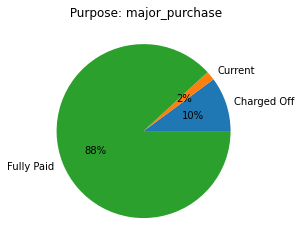

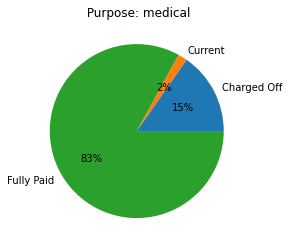

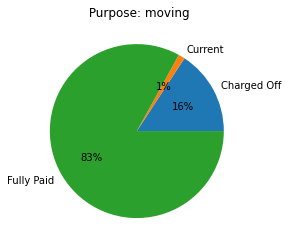

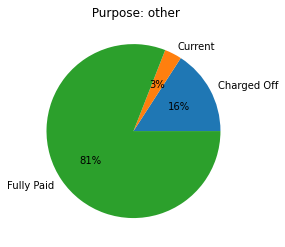

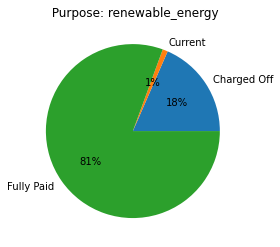

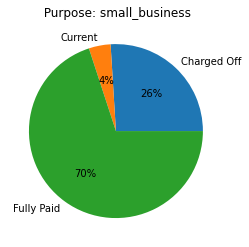

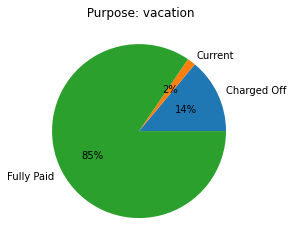

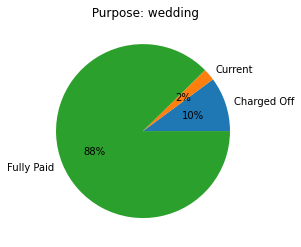

In [158]:
# Plotting pie chart
for label in purpose_labels:
    plt.pie(purpose_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"black"})
    plt.title(f" Purpose: {label}")
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
Small business borrowers seem to default a lot more. $\Rightarrow 26%.<br> The others are fairly even around 80 - 85%.<br> Loans borrowed for wedding seem to have the lowest default percentage
#### <font color="asparagus"> This can also be a good indicator to decide whether the loan is going to be defaulted or not.<font>

In [159]:
# I can safely append purpose to the indicators list based on our analysis above
indicators.append("purpose")

#### <font color="asparagus"> $\Rightarrow$ A stacked bar plot says the same thing. Small businesses have more percent of charged off

In [160]:
loan_labels = ["Charged Off", "Current", "Fully Paid"]
chargedOff = []
for label in purpose_labels:
    chargedOff.append(purpose_dist[label][0])
chargedOff = np.array(chargedOff) 

current = []
for label in purpose_labels:
    current.append(purpose_dist[label][1])
current = np.array(current) 

Fully = []
for label in purpose_labels:
    Fully.append(purpose_dist[label][2])
Fully = np.array(Fully)

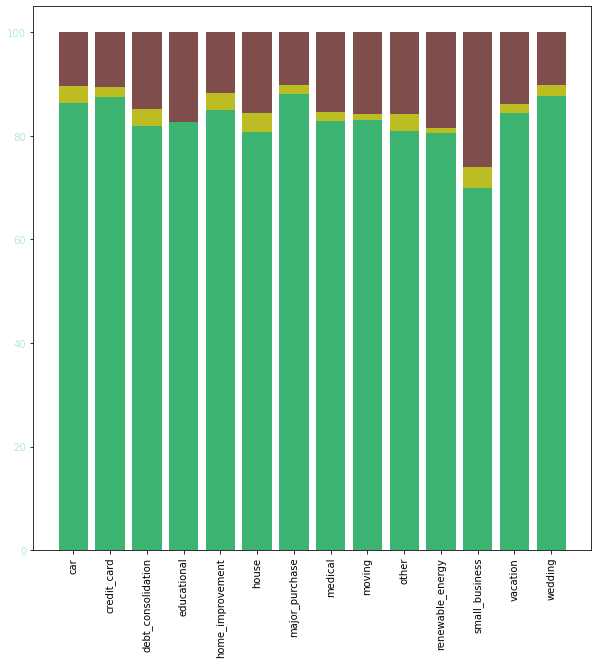

In [161]:
# plot stacked bar
ax = plt.figure(figsize=(10,10))
plt.bar(purpose_labels, Fully, color='mediumseagreen')
plt.bar(purpose_labels, current, bottom=Fully, color='tab:olive')
plt.bar(purpose_labels, chargedOff, bottom=Fully+current, color=(0.5,0.3,0.3))
plt.xticks(rotation="vertical")
plt.yticks(color=(0.7,0.9,0.9))
plt.show()

##### $\Rightarrow$ <font color="asparagus"> III.2.1.5. Employee Experience

In [162]:
df.pivot_table(index=["emp_length_bins"], columns=["loan_status"], values="funded_amnt", aggfunc="mean")

loan_status,Charged Off,Current,Fully Paid
emp_length_bins,,,
0-2,"10,195.47","15,062.76","9,588.96"
2-4,"11,163.27","15,342.80","10,368.21"
4-6,"11,973.50","16,273.99","10,791.22"
6-8,"12,536.21","15,962.74","11,188.63"
8-10,"12,714.72","15,260.94","11,500.89"
> 10,"13,359.80","18,042.84","11,740.44"


#### <font color="asparagus"> $\Rightarrow$ The more experienced borrowers tend to borrow more money <font>

In [163]:
emp_exp_list = sorted(df.emp_length_bins.unique().to_list())

In [164]:
emp_exp_wise_dist = calculate_groupwise_loan_status_percentage(emp_exp_list, df, "emp_length_bins")

In [165]:
emp_exp_wise_dist

{'0-2': [13.61, 1.99, 84.4],
 '2-4': [13.5, 2.35, 84.15],
 '4-6': [13.88, 2.7, 83.41],
 '6-8': [14.33, 3.26, 82.41],
 '8-10': [12.56, 2.54, 84.9],
 '> 10': [15.66, 4.35, 79.99]}

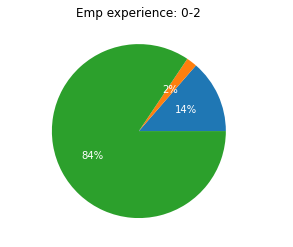

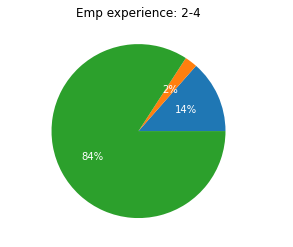

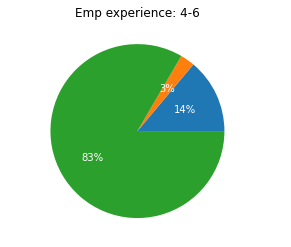

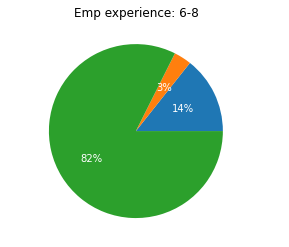

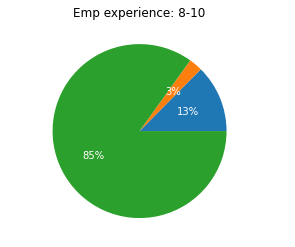

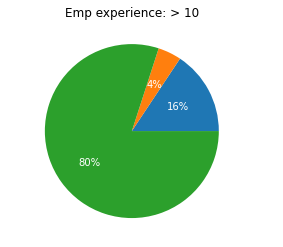

In [166]:
# Plotting pie chart
for label in emp_exp_list:
    plt.pie(emp_exp_wise_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f"Emp experience: {label}")
    plt.show()


#### <font color="asparagus"> Shouldn't people with less experience default more often? But I do not observe any pattern here.<font> <br>

#### <font color="asparagus"> The following cells will help give us better insight

In [167]:
emp_exp_group = get_grouped_df(df,"emp_length_bins")

In [168]:
emp_exp_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
emp_length_bins,,,,,,
0-2,1662,243,10306,13.61,1.99,84.40
2-4,1017,177,6337,13.50,2.35,84.15
4-6,765,149,4597,13.88,2.70,83.41
6-8,466,106,2680,14.33,3.26,82.41
8-10,158,32,1068,12.56,2.54,84.90
> 10,1559,433,7962,15.66,4.35,79.99


In [169]:
emp_exp_group.sort_values(["pct_chargedOff"], ascending=False)

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
emp_length_bins,,,,,,
> 10,1559,433,7962,15.66,4.35,79.99
6-8,466,106,2680,14.33,3.26,82.41
4-6,765,149,4597,13.88,2.70,83.41
0-2,1662,243,10306,13.61,1.99,84.40
2-4,1017,177,6337,13.50,2.35,84.15
8-10,158,32,1068,12.56,2.54,84.90


#### <font color="asparagus"> *Observations and Comments*<br>$\Rightarrow$ I see people with more than 10 years of experience, defaulting more often than people with less experience.<br> $\Rightarrow$ But the increase in percentage is very small. For the most part the percentage is ~ 15%<br> $\Rightarrow$ Can't really put emp_length as a very strong indicator of default.<br> $\Rightarrow$<font color="asparagus"> *Side Note*: Borrowers with 8-10 experience have the lowest percent of default <font>

##### $\Rightarrow$ <font color="asparagus"> III.2.1.6. Annual Income

In [170]:
annual_inc_labels = sorted(df.annual_inc_bins.unique())

In [171]:
annual_inc_wise_dist = calculate_groupwise_loan_status_percentage(annual_inc_labels, df, "annual_inc_bins")

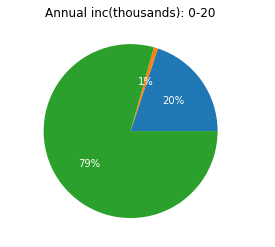

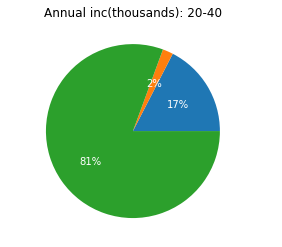

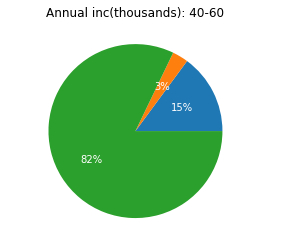

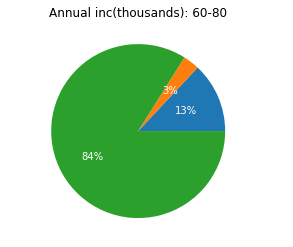

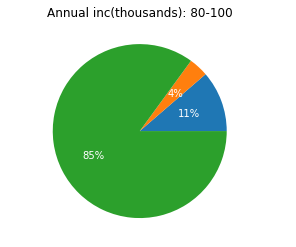

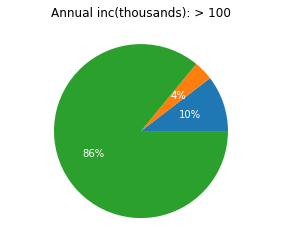

In [172]:
# Plotting pie chart
for label in annual_inc_labels:
    plt.pie(annual_inc_wise_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f"Annual inc(thousands): {label}")
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
The percentage of defaulting borrowers with annual income in between $0-$20k is double that of those make more than 100k dollars. We can further split >100k and potentially observe the same pattern

In [173]:
# I can safely append annual inc to the indicators list based on our analysis above
indicators.append("annual_inc")

In [174]:
indicators

['Pct_Payment_Received', 'grade', 'purpose', 'annual_inc']

##### $\Rightarrow$ <font color="asparagus"> III.2.1.7. Funded Amount

In [175]:
funded_amnt_labels = sorted(df.funded_amnt_bins.unique())

In [176]:
funded_amnt_labels

['0-5', '10-15', '15-20', '20-25', '25-30', '30-35', '5-10']

In [177]:
funded_amnt_dist = calculate_groupwise_loan_status_percentage(funded_amnt_labels, df, "funded_amnt_bins")

In [178]:
funded_amnt_dist

{'0-5': [13.79, 0.99, 85.21],
 '10-15': [13.35, 3.77, 82.88],
 '15-20': [16.92, 5.59, 77.49],
 '20-25': [18.02, 6.33, 75.65],
 '25-30': [16.97, 10.07, 72.97],
 '30-35': [21.72, 10.2, 68.08],
 '5-10': [12.64, 1.25, 86.11]}

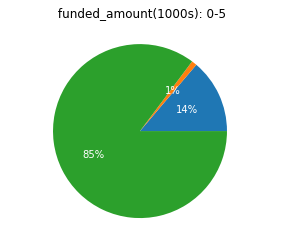

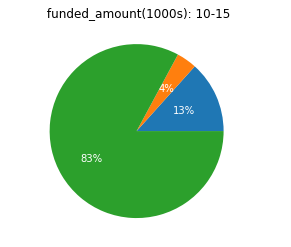

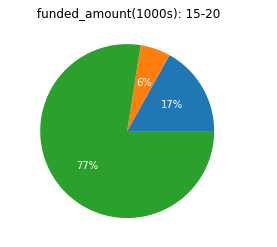

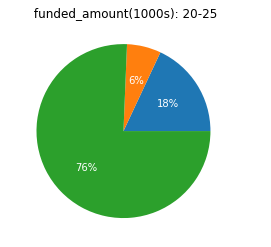

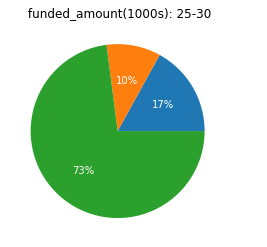

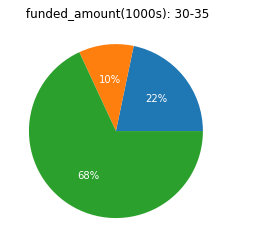

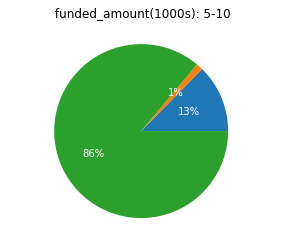

In [179]:
# Plotting pie chart
for label in funded_amnt_labels:
    plt.pie(funded_amnt_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f" funded_amount(1000s): {label}")
    plt.show()

#### <font color="asparagus"> $\Rightarrow$ Observations:
1. Higher the amount, more is the charged off percentage. Eg: In the range 30000-35000: the percentage of borrowers who charged off is 22%
2. Charged off percentage for 0-5000 is 14%.
3. Adding this to the list of indicators

In [180]:
indicators.append("funded_amnt")

In [181]:
indicators

['Pct_Payment_Received', 'grade', 'purpose', 'annual_inc', 'funded_amnt']

##### $\Rightarrow$ <font color="asparagus"> III.2.1.8. Rate of Interest

In [182]:
int_rate_labels = (df.int_rate_bins.unique())

In [183]:
int_rate_dist = calculate_groupwise_loan_status_percentage(int_rate_labels, df, "int_rate_bins")

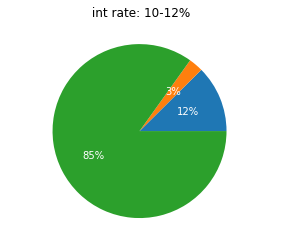

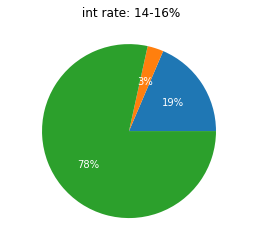

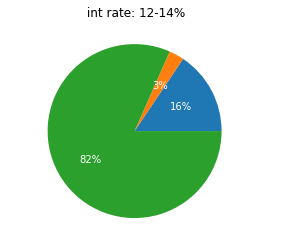

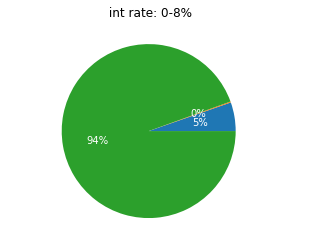

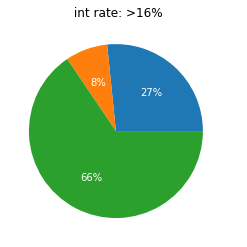

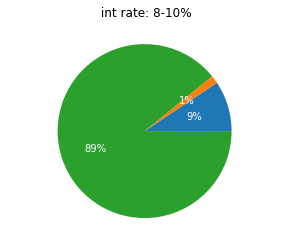

In [184]:
# Plotting pie chart
for label in int_rate_labels:
    plt.pie(int_rate_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f" int rate: {label}%")
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ We can conclude that higher interest rates, attract more defaults. Eg: For int_rate in the range 0-8%, % charged off = 5%<br>$\Rightarrow$ int_rate >16% has % charged Off = 27% <font color="asparagus"> **A huge increase**<font>

In [185]:
# I can safely append int_rate to the indicators list based on our analysis above
indicators.append("int_rate")

In [186]:
indicators

['Pct_Payment_Received',
 'grade',
 'purpose',
 'annual_inc',
 'funded_amnt',
 'int_rate']

##### $\Rightarrow$ <font color="asparagus"> III.2.1.9. Public records

In [187]:
df.pub_rec.value_counts()

0    37601
1     2056
2       51
3        7
4        2
Name: pub_rec, dtype: int64

In [188]:
pub_rec_group = get_grouped_df(df,"pub_rec")

In [189]:
pub_rec_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
pub_rec,,,,,,
0,"5,160.00","1,094.00","31,347.00",13.72,2.91,83.37
1,457.00,43.00,"1,556.00",22.23,2.09,75.68
2,10.00,3.00,38.00,19.61,5.88,74.51
3,0.00,0.00,7.00,0.00,0.00,100.00
4,0.00,0.00,2.00,0.00,0.00,100.00


In [190]:
pub_rec_group.sort_values("pct_chargedOff", ascending=False)

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
pub_rec,,,,,,
1,457.00,43.00,"1,556.00",22.23,2.09,75.68
2,10.00,3.00,38.00,19.61,5.88,74.51
0,"5,160.00","1,094.00","31,347.00",13.72,2.91,83.37
3,0.00,0.00,7.00,0.00,0.00,100.00
4,0.00,0.00,2.00,0.00,0.00,100.00


#### <font color="asparagus"> pub_rec according to the data dictionary:  Number of derogatory public records. <font> 
$\Rightarrow$ We might think that more the derogatory records, higher the defaults. But that's not what we see in this data.<br> $\Rightarrow$ Borrowers with 3 and 4 pub_rec have fully paid, whereas borrowers with only 1 derogatory record have defaulted more often than those with 2 derogatory records
Therefore, I cannot add this as to the list of indicators

##### <font color="asparagus"> $\Rightarrow$ III.2.1.10. Number of inquiries in the last 6 months

In [191]:
inq_6mnths_group = get_grouped_df(df, "inq_last_6mths")

In [192]:
inq_6mnths_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
inq_last_6mths,,,,,,
0,2280,591,16429,11.81,3.06,85.12
1,1677,311,8983,15.29,2.83,81.88
2,943,158,4711,16.23,2.72,81.06
3,619,65,2364,20.31,2.13,77.56
4,51,10,265,15.64,3.07,81.29
5,28,2,116,19.18,1.37,79.45
6,16,1,47,25.00,1.56,73.44
7,10,1,24,28.57,2.86,68.57
8,3,1,11,20.00,6.67,73.33


In [193]:
inq_6mnths_group.sort_values(["pct_chargedOff"], ascending=False)

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
inq_last_6mths,,,,,,
7,10,1,24,28.57,2.86,68.57
6,16,1,47,25.00,1.56,73.44
3,619,65,2364,20.31,2.13,77.56
8,3,1,11,20.00,6.67,73.33
5,28,2,116,19.18,1.37,79.45
2,943,158,4711,16.23,2.72,81.06
4,51,10,265,15.64,3.07,81.29
1,1677,311,8983,15.29,2.83,81.88
0,2280,591,16429,11.81,3.06,85.12


#### <font color="asparagus"> $\Rightarrow$ Now this is a good indicator of default. Borrowers who have inquired more in the past 6 months are more likely to default

In [194]:
indicators.append("inq_last_6mnths")

#### <font color="asparagus"> $\Rightarrow$ III.2.1.11. State Address

In [195]:
addr_state_group = get_grouped_df(df, "addr_state")

In [196]:
addr_state_group.sort_values("pct_chargedOff", ascending=False)

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
addr_state,,,,,,
NE,3.00,0.00,2.00,60.00,0.00,40.00
NV,108.00,18.00,371.00,21.73,3.62,74.65
AK,15.00,2.00,63.00,18.75,2.50,78.75
SD,12.00,2.00,50.00,18.75,3.12,78.12
FL,504.00,85.00,"2,277.00",17.59,2.97,79.45
ID,1.00,0.00,5.00,16.67,0.00,83.33
MO,114.00,16.00,556.00,16.62,2.33,81.05
HI,28.00,8.00,138.00,16.09,4.60,79.31
NM,30.00,6.00,153.00,15.87,3.17,80.95


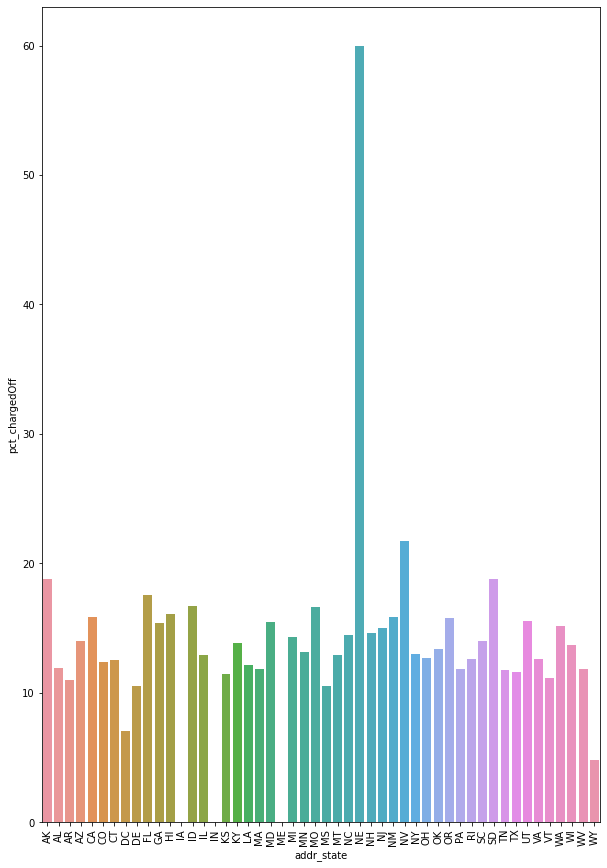

<Figure size 432x288 with 0 Axes>

In [197]:
plt.figure(figsize=(10,15))
sns.barplot(x=addr_state_group.index, y=addr_state_group["pct_chargedOff"])
plt.xticks(rotation="vertical")
# plt.yticks(color="w")
plt.show()
plt.tight_layout()

#### <font color="asparagus"> Borrowers from the state of Nebraska(NE) are more likely to default than others. $\Rightarrow$ 60% <font> <br> We can add addr_state to the list of indicators as well

In [198]:
indicators.append("addr_state")

In [199]:
indicators

['Pct_Payment_Received',
 'grade',
 'purpose',
 'annual_inc',
 'funded_amnt',
 'int_rate',
 'inq_last_6mnths',
 'addr_state']

#### <font color="asparagus"> $\Rightarrow$ III.2.1.12. Loan Term

In [200]:
term_grouped = get_grouped_df(df,"term")

In [201]:
term_grouped.sort_values("pct_chargedOff", ascending=False)

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
term,,,,,,
5,"2,400.00","1,140.00","7,081.00",22.60,10.73,66.67
3,"3,227.00",0.00,"25,869.00",11.09,0.00,88.91


#### <font color="asparagus"> Borrowing money for a term period of 5 years are twice as likely to default than those whose term period is 3 years.(22.6% vs 11.09%). <font>
We need to understand why though. What's so specific about the 5 year plan, that makes borrowers default?<br> Let's do a bivariate analysis of term period with other variables in our indicators' list.

<AxesSubplot:xlabel='term', ylabel='Pct_Payment_Received'>

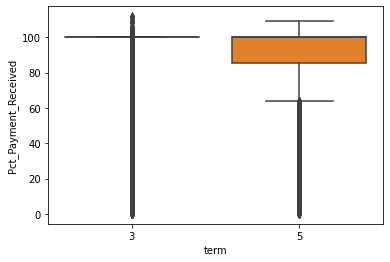

In [202]:
sns.boxplot(y="Pct_Payment_Received", x="term", data=df)

#### <font color="asparagus"> *Observation and comments*<font>
It makes sense that the amount of payment received is less for the 5 year loan since they default more often

We know that the worse your credit rating(grade), the more likely it is that you will default. But I can't see much of a pattern here

<AxesSubplot:xlabel='term', ylabel='grade'>

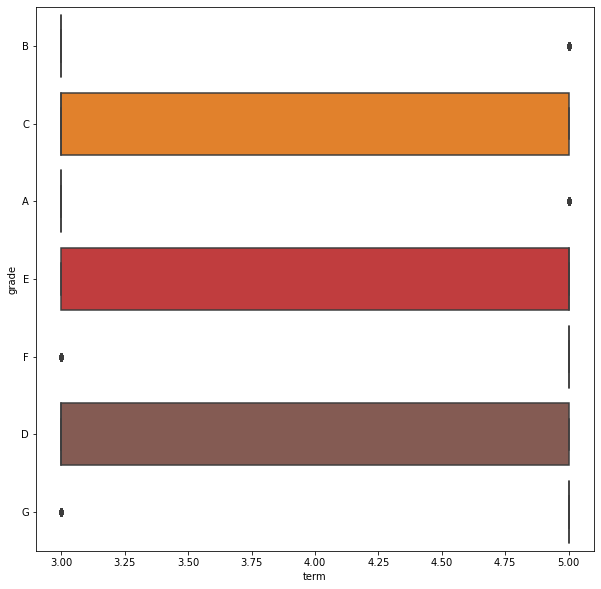

In [203]:
plt.figure(figsize=(10,10))
sns.boxplot(y="grade", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")

<AxesSubplot:xlabel='term', ylabel='annual_inc_bins'>

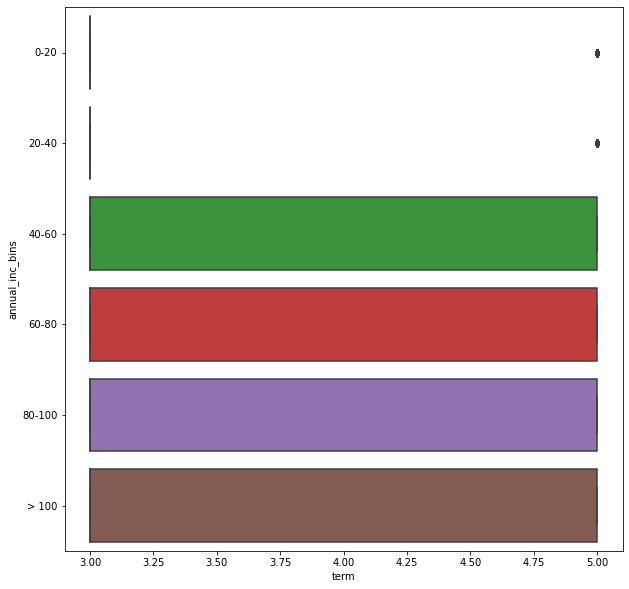

In [204]:
plt.figure(figsize=(10,10))
sns.boxplot(y="annual_inc_bins", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")

#### <font color="asparagus"> *Observation and comments*<font>
From our previous analysis, lower the income the more likely it is that the borrower will default. 
The above plot shows just that. Borrowers with income in the range \$0-\$40,000 opt for the 5 year loan, which explains the increase of defaults in the 5 year plan

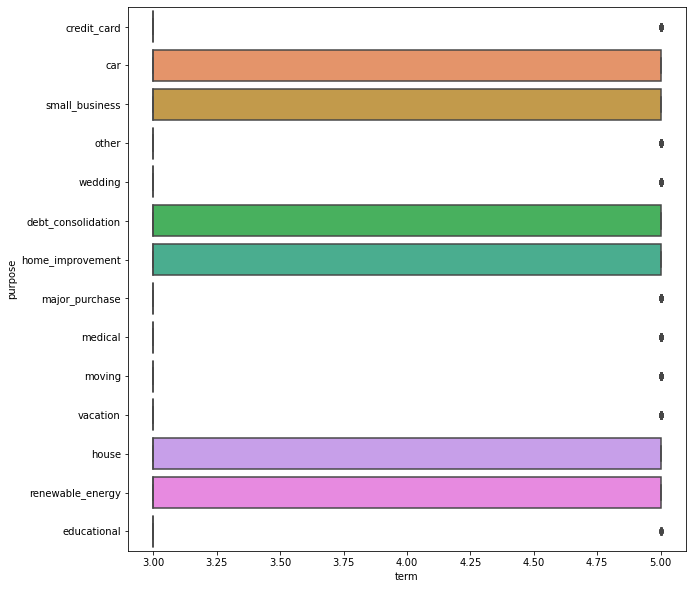

In [205]:
plt.figure(figsize=(10,10))
sns.boxplot(y="purpose", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")
plt.show()

#### <font color="asparagus"> *Observation and comments*<font>
We know loans for the purpose of small businesses tend to default more, but the boxplot says that they go for both 3 and 5 year terms. May be a percentage will help?

In [206]:
chargedOffSum = len(df[(df.purpose == "small_business") & (df["loan_status"] =="Charged Off")])
n5yrSum = len(df[(df.purpose == "small_business") & (df["loan_status"] =="Charged Off") & (df.term == 5)])
n3yrSum = len(df[(df.purpose == "small_business") & (df["loan_status"] =="Charged Off") & (df.term == 3)])


In [207]:
100* n5yrSum/chargedOffSum, 100* n3yrSum/chargedOffSum


(43.36842105263158, 56.63157894736842)

#### <font color="asparagus"> *Observation and comments*<font>
No, it seems small business borrowers have been given 3 year term

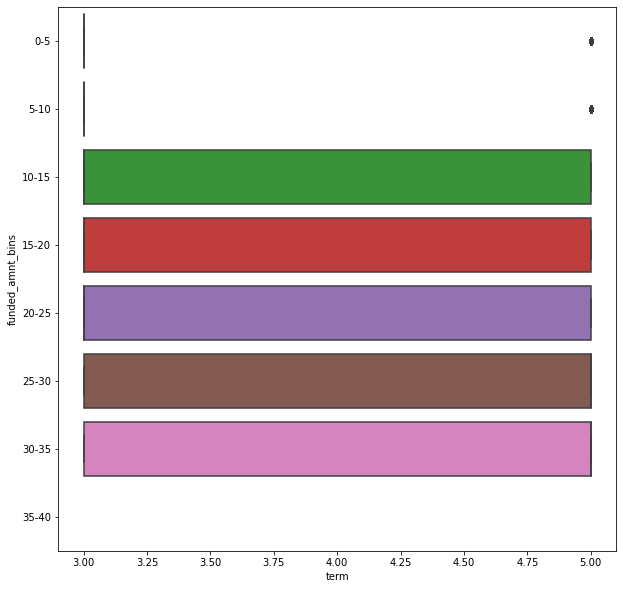

In [208]:
plt.figure(figsize=(10,10))
sns.boxplot(y="funded_amnt_bins", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")
plt.show()

#### <font color="asparagus"> *Observation and comments*<font>
From before, higher the funded amount, higher the charged off percentage. But it seems I cannot get any pattern here.<br> But we also know that higher the funded amount, higher is the interest given to them. <br>So there might be something when we do a boxplot of term with interest rate

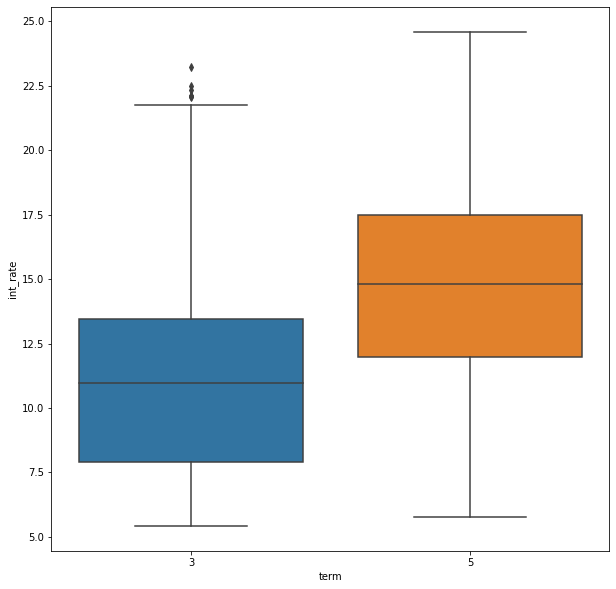

In [209]:
plt.figure(figsize=(10,10))
sns.boxplot(y="int_rate", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")
plt.show()

#### <font color="asparagus"> *Observation and comments*<font>
Bingo! As suspected, the interest rate is high for 5 year term! And we know that higher interest rates attract more defaults. Therefore, this is another contributing factor to the higher number of defaults in the 5 year loans(double that of 3 year loans)

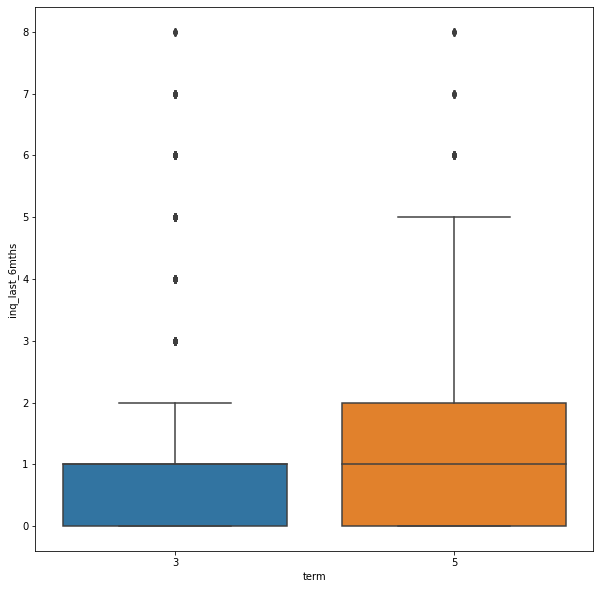

In [210]:
plt.figure(figsize=(10,10))
sns.boxplot(y="inq_last_6mths", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")
plt.show()

#### <font color="asparagus"> *Observation and comments*<font>
Median of inq_last_6mths is 1 for the 5 year loan. But there are outliers in the 3 year loan as well. Can't really conclude much. This is a contributing factor but not very strong, I guess.

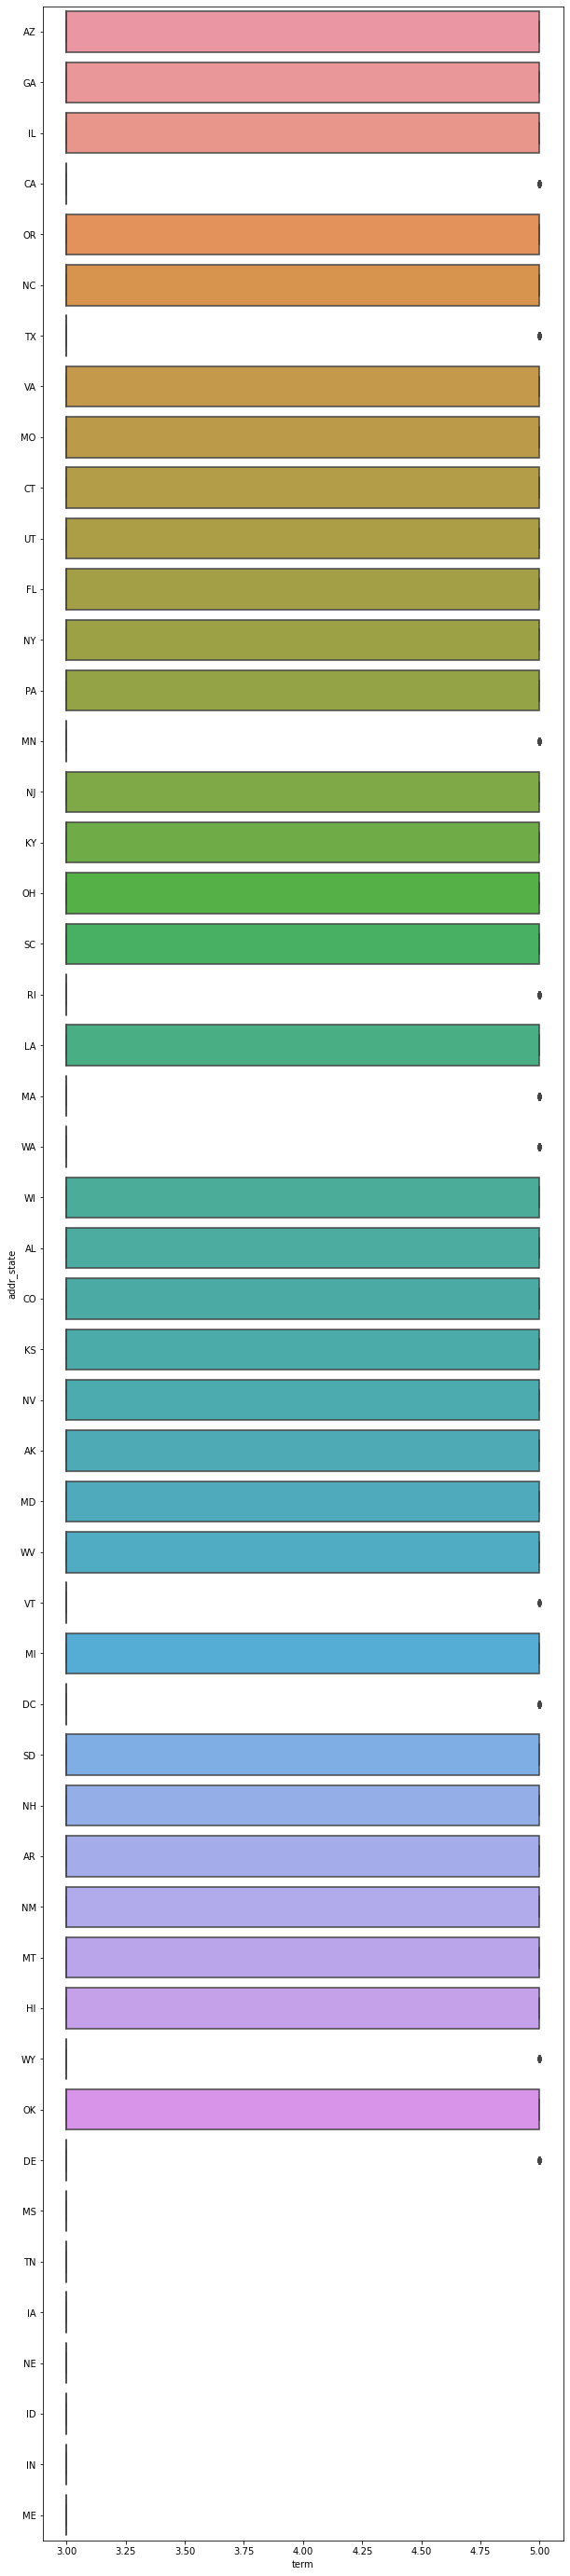

In [211]:
plt.figure(figsize=(10,50))
sns.boxplot(y="addr_state", x="term", data=df)
#plt.xticks(color="w")
#plt.yticks(color="w")
plt.show()

#### <font color="asparagus"> *Observation and comments*<font>
Can't conclude much here. The term is all over the place. I mainly wanted to see what's going on in NE, NA, AK, SD since they have the highest defaults. In fact, NE, the state with the highest defaults has purely 3 year loans

##### <font color="asparagus"> $\Rightarrow$ III.2.1.13. Delta_bins

In [212]:
delta_bins_group = get_grouped_df(df,"delta_bins")

In [213]:
delta_bins_group

loan_status,Charged Off,Current,Fully Paid,pct_chargedOff,pct_current,pct_fullyPaid
delta_bins,,,,,,
0-1,1903,0,4150,31.44,0.00,68.56
1-2,1968,0,6216,24.05,0.00,75.95
2-3,1227,0,13068,8.58,0.00,91.42
3-4,398,0,7108,5.30,0.00,94.70
4-5,129,1136,1814,4.19,36.90,58.92
5-6,2,4,594,0.33,0.67,99.00
6-7,0,0,0,NaN,NaN,NaN
7-8,0,0,0,NaN,NaN,NaN


#### <font color="asparagus"> *Observations and Comments* <font>
The LC club has two term plans: 3 and 5 years. The delta_bins are indicating the time passed from the issue date. <br>Directly analyzing the table won't make sense, because obviously the ones where more than 5 years have passed are the borrowers who have defaulted. <br> We should rather add another level of segregation. <br> We will choose the percentage of payment received for this purpose. $\Rightarrow$ We know that defaulters will have payment percentage below 100. So let's focus on that.

#### This is the list of all the borrowers who borrowed money within the past year, whose payments are not on time and have less than a 100% 

In [214]:
df_borrowed_within_a_yr = df[(df.Pct_Payment_Received < 100) & (df.delta_bins =="0-1")]

In [215]:
df_borrowed_within_a_yr

,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,annual_inc_bins,funded_amnt_bins,int_rate_bins,issue_year,issue_month,last_payment_year,last_payment_month,delta,delta_bins,Pct_Payment_Received
8,5600,5,21.28,F,F2,<NA>,4,OWN,"40,000.00",Source Verified,...,20-40,5-10,>16,12.00,12.00,12.33,4.00,0.33,0-1,6.27
9,5375,5,12.69,B,B5,Starbucks,1,RENT,"15,000.00",Verified,...,0-20,5-10,12-14,12.00,12.00,12.92,11.00,0.92,0-1,17.54
12,9000,3,13.49,C,C1,Va. Dept of Conservation/Recreation,1,RENT,"30,000.00",Source Verified,...,20-40,5-10,12-14,12.00,12.00,12.58,7.00,0.58,0-1,18.89
24,6000,3,11.71,B,B3,bmg-educational,1,RENT,"76,000.00",Not Verified,...,60-80,5-10,10-12,12.00,12.00,12.83,10.00,0.83,0-1,26.25
27,5000,5,16.77,D,D2,Frito Lay,2,RENT,"50,004.00",Not Verified,...,40-60,0-5,>16,12.00,12.00,13.00,12.00,1.00,0-1,17.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39584,25000,3,12.80,D,D4,"MGTS, Inc",2,MORTGAGE,"75,000.00",Not Verified,...,60-80,20-25,12-14,7.92,11.00,8.83,10.00,0.91,0-1,26.62
39593,4800,3,13.12,D,D5,Legal Services of New Jersey,8,MORTGAGE,"85,000.00",Not Verified,...,80-100,0-5,12-14,7.83,10.00,8.67,8.00,0.84,0-1,24.54
39598,2225,3,10.59,C,C2,Sanctuary,2,RENT,"60,000.00",Not Verified,...,40-60,0-5,10-12,7.83,10.00,8.42,5.00,0.59,0-1,18.40
39623,9000,3,12.49,D,D3,Maximus,8,MORTGAGE,"39,000.00",Not Verified,...,20-40,5-10,12-14,7.83,10.00,8.42,5.00,0.59,0-1,37.85


#### So now let's check the loan_status of these guys

In [216]:
df_borrowed_within_a_yr.loan_status.value_counts()

Charged Off    1869
Name: loan_status, dtype: Int64

#### Bingo! All of them end up defaulting on their loan

#### So is the case for the other bins.

In [217]:
df[(df.Pct_Payment_Received < 100) & (df.delta_bins =="1-2")]["loan_status"].value_counts()

Charged Off    1944
Name: loan_status, dtype: Int64

In [218]:
df[(df.Pct_Payment_Received < 100) & (df.delta_bins =="2-3")]["loan_status"].value_counts()

Charged Off    1204
Fully Paid        1
Name: loan_status, dtype: Int64

In [219]:
df[(df.Pct_Payment_Received < 100) & (df.delta_bins =="3-4")]["loan_status"].value_counts()

Charged Off    396
Name: loan_status, dtype: Int64

#### In the 4-5 bin, there are still people whose loan status is current. 

In [220]:
df[(df.Pct_Payment_Received < 100) & (df.delta_bins =="4-5")]["loan_status"].value_counts()

Current        1136
Charged Off     129
Fully Paid       10
Name: loan_status, dtype: Int64

#### $\Rightarrow$  But they are more likely to default in the future, in my opinion. It probably depends on the percentage of payment received. <br> $\Rightarrow$ Because by this time(4-5 year from loan issue date), this percent of amount payed should be very high, close to 100%, so let's check as well

In [221]:
df[df.delta_bins =="4-5"]["Pct_Payment_Received"].value_counts()

100.00    1804
89.66        7
97.33        7
84.25        7
87.64        6
          ... 
78.28        1
88.76        1
86.72        1
87.72        1
52.03        1
Name: Pct_Payment_Received, Length: 812, dtype: int64

#### <font color="asparagus"> Let's split percent payment received in to two categories: less than 80% and greater than 80%

In [222]:
Pct_Payment_categories_list = [0, 80, 100]
Pct_Payment_labels_list = ["0-80",">80"]
df["Pct_Payment_bins"] = pd.cut(df["Pct_Payment_Received"], bins=Pct_Payment_categories_list,
                              labels=Pct_Payment_labels_list)

In [223]:
df_payment_delta_bin_group = df.groupby(["delta_bins", "Pct_Payment_bins"]).Pct_Payment_bins.count().fillna(0).unstack()

In [224]:
df_payment_delta_bin_group

Pct_Payment_bins,0-80,>80
delta_bins,,
0-1,1850,4169
1-2,1903,6249
2-3,923,13348
3-4,366,7133
4-5,51,3028
5-6,0,600
6-7,0,0
7-8,0,0


#### <font color="asparagus"> *Observations and Comments*:<font><br>
$\Rightarrow$ <font color="asparagus">You can see that 4-5 bin has 71 borrowers who have payed less than 80% of their loan. Therefore, we can see pct_payment and delta_bin together are a great indicators of loan defaults

#### <font color="asparagus">Since the bank only has two terms, it is best to check at the term boundaries. i.e. For the 3 year loan, check bin = 2-3 and percent_payment_bin = 0-80. 

In [225]:
df[(df.Pct_Payment_bins == "0-80") & (df.term==3) & (df.delta_bins=="2-3")]["loan_status"].value_counts()

Charged Off    439
Name: loan_status, dtype: Int64

#### <font color="asparagus"> As you can see all, of them default

#### <font color="asparagus"> Similarly for the 5 year loan...

In [226]:
df[(df.Pct_Payment_bins == "0-80") & (df.term==5) & (df.delta_bins=="4-5")]["loan_status"].value_counts()

Charged Off    45
Current         2
Name: loan_status, dtype: Int64

#### <font color="asparagus"> Most of them default too! : )

In [227]:
indicators.append("delta_bins") # adding this to the list of indicators. delta_bins can be used along with
#pct_payment_received to gain insight on loan defaults

### <font color='skyblue'>  III.2.2. In between rest of the columns(minus loan_status) <font> 

#### <font color="asparagus"> *Comments:* <font>
Let's restrict ourselvs to the columns in the indicators, too see if there are any patterns.<br>$\Rightarrow$ grade vs int_rate<br>
$\Rightarrow$ purpose vs int_rate<br>
$\Rightarrow$ addr_state vs int_rate
$\Rightarrow$ fended_amnt vs int_rate    


In [228]:
indicators

['Pct_Payment_Received',
 'grade',
 'purpose',
 'annual_inc',
 'funded_amnt',
 'int_rate',
 'inq_last_6mnths',
 'addr_state',
 'delta_bins']

#### $\Rightarrow$ <font color='asparagus'>grade vs int_rate

<AxesSubplot:xlabel='int_rate', ylabel='grade'>

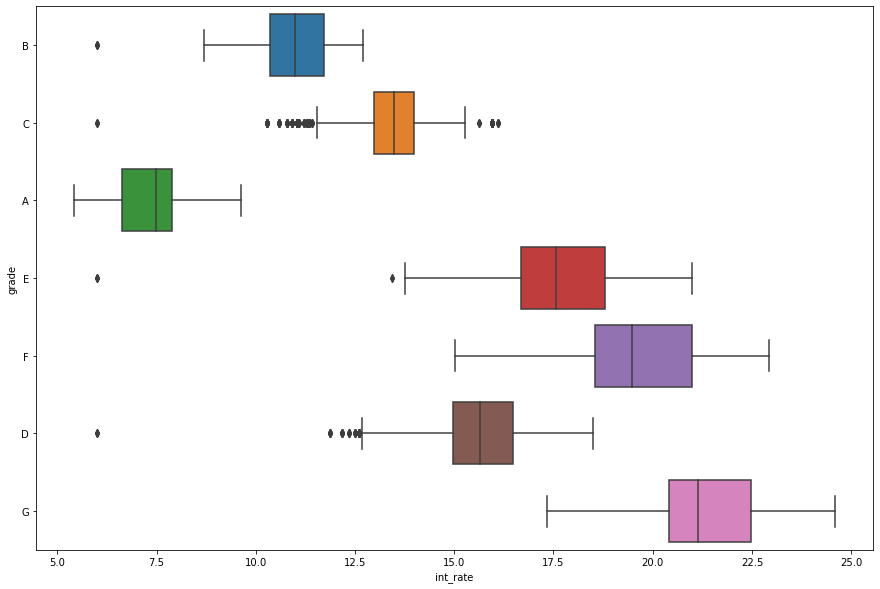

In [229]:
plt.figure(figsize=(15,10))
sns.boxplot(y="grade", x="int_rate", data=df)

#### <font color="asparagus"> *Observations and Comments:* <font>
Interest rate is really high for Grade G borrowers. Explains why they default a lot more.<br>We already know that high interest rates attract high defaults... Wonder what the process is to decide the interest rate for a particular borrower.

#### $\Rightarrow$ <font color='asparagus'>purpose vs int_rate

<AxesSubplot:xlabel='int_rate', ylabel='purpose'>

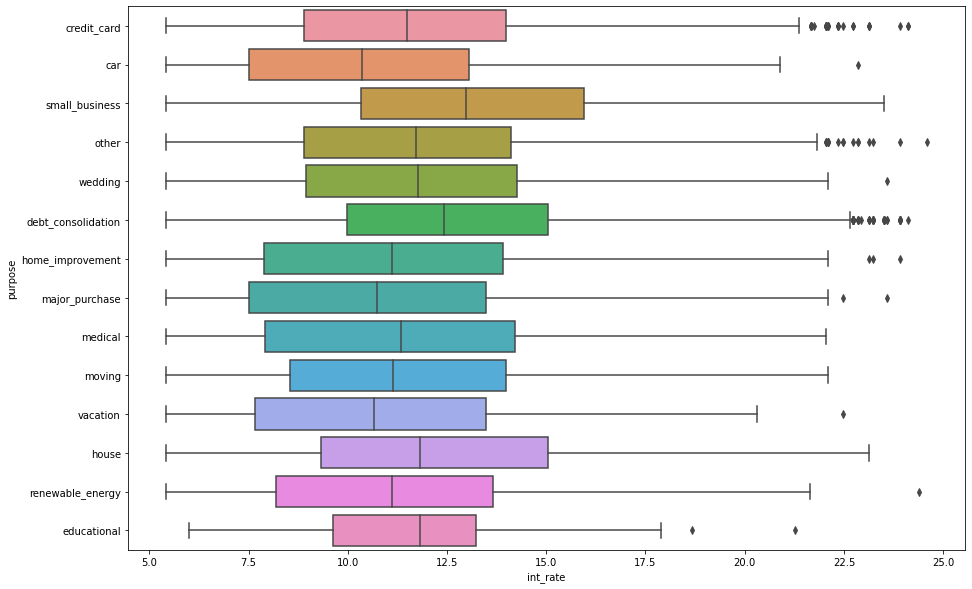

In [230]:
plt.figure(figsize=(15,10))
sns.boxplot(y="purpose", x="int_rate", data=df)

#### <font color="asparagus"> *Observations and Comments:* <font>
Small businesses end up defaulting more. We can see that the interest is also on the higher side for borrowers borrowing money for the purpose of small_business 

#### $\Rightarrow$ <font color='asparagus'> addr_state vs int_rate

<AxesSubplot:xlabel='int_rate', ylabel='addr_state'>

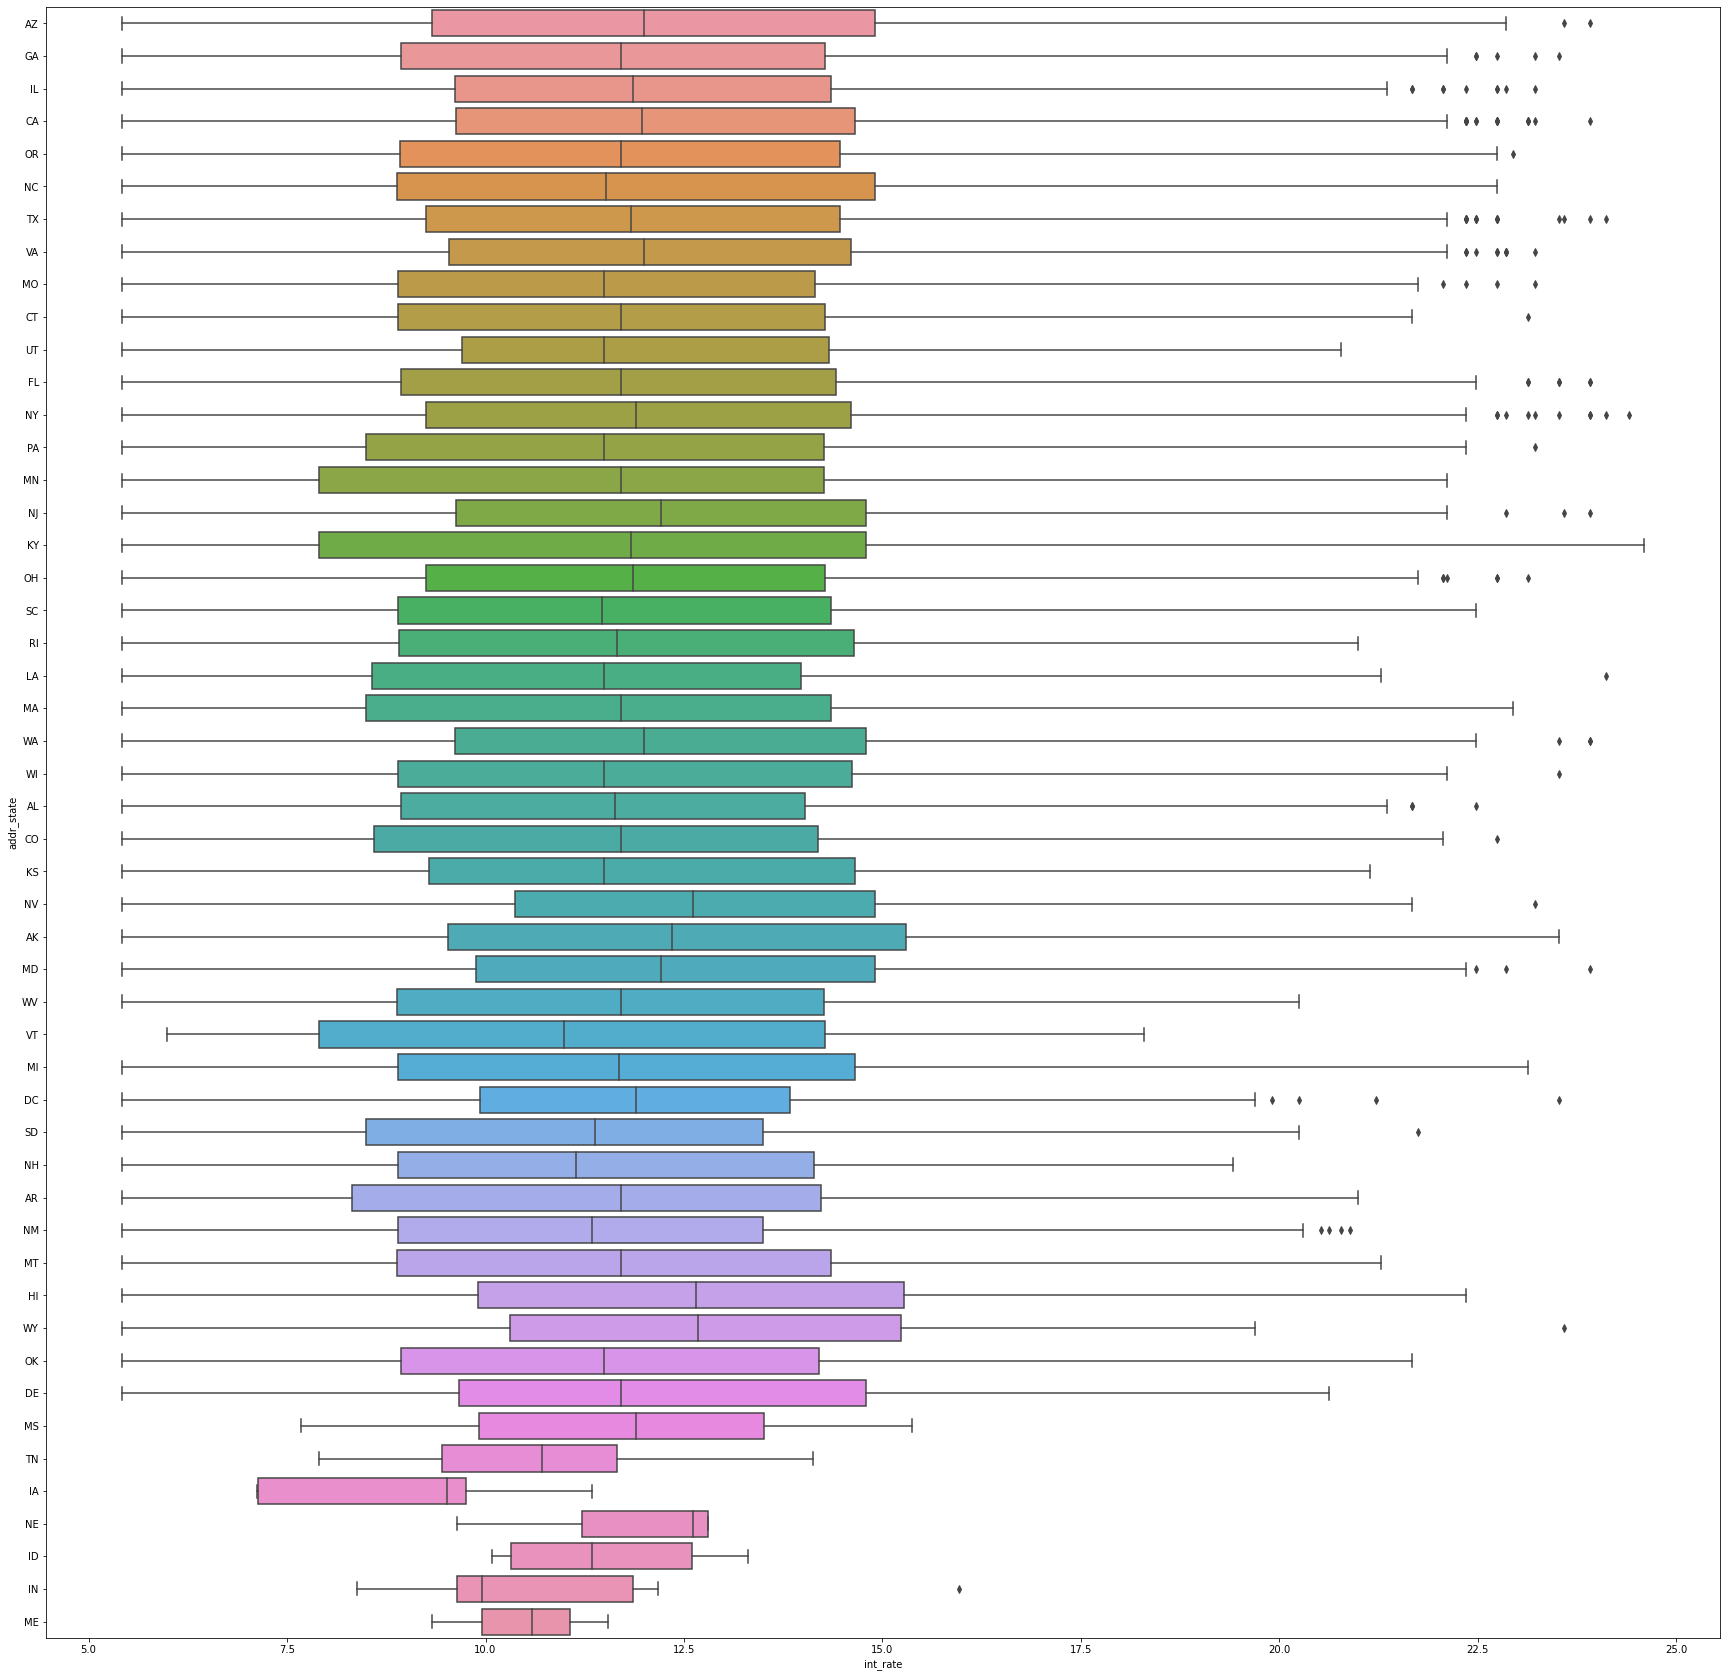

In [231]:
plt.figure(figsize=(30,30))
sns.boxplot(y="addr_state", x="int_rate", data=df)

#### <font color="asparagus"> *Observations and Comments:* <font>
It's a bit all over the place. Can't really conclude much

#### $\Rightarrow$ <font color='asparagus'> funded_amnt vs int_rate

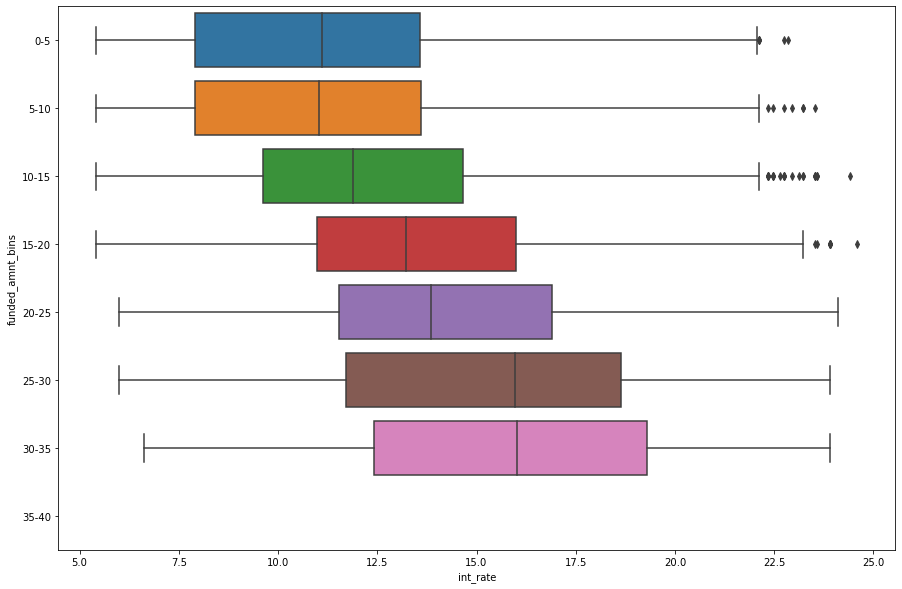

In [232]:
plt.figure(figsize=(15,10))
sns.boxplot(y="funded_amnt_bins", x="int_rate", data=df)
plt.show()

#### <font color="asparagus"> *Observations and Comments:* <font>
We know from our previous analysis, higher the funded amount, higher is the interest rate and therefore the defaults. The above box plot explains the same thing.

#### $\Rightarrow$ Now let's look at some other factors. When we want a loan, there are certain questions to be asked by both the LC and the borrower:
$\Rightarrow$ What is the loan amount? <br> 
$\Rightarrow$ What is the rate of interest.<br> 
$\Rightarrow$ How many years we intend to repay the loan in?

#### <font color="asparagus"> $\Rightarrow$ int_rate vs term <br> 

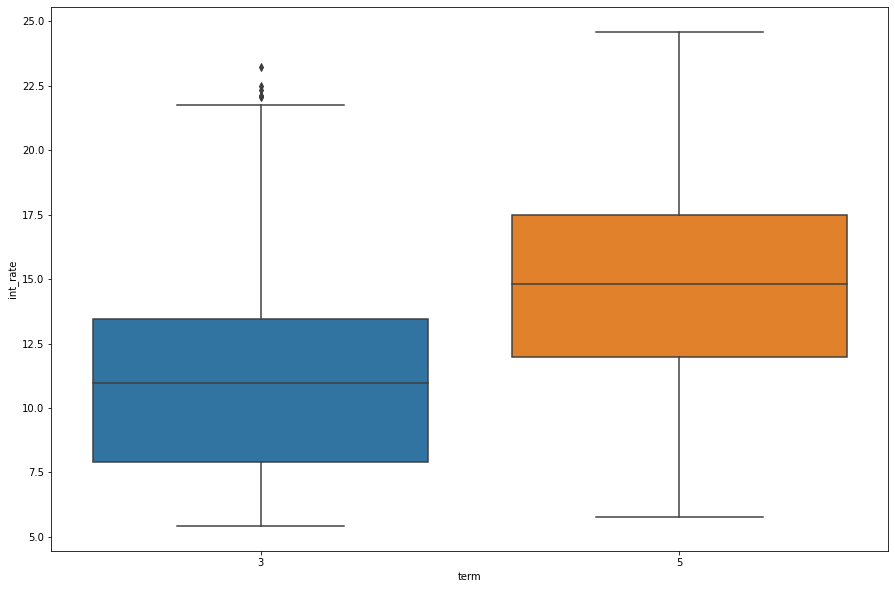

In [233]:
plt.figure(figsize=(15,10))
sns.boxplot(y="int_rate", x="term", data=df)
plt.show()

#### <font color="asparagus"> *Observations and Comments:* <font>
With the above plot, we can say that for 5 year loans, the LC has decided that the rate of interest should be around 15% and for the 3 year loan, it is around 11%

#### <font color="asparagus"> $\Rightarrow$ int_rate vs funded_amnt <br> 

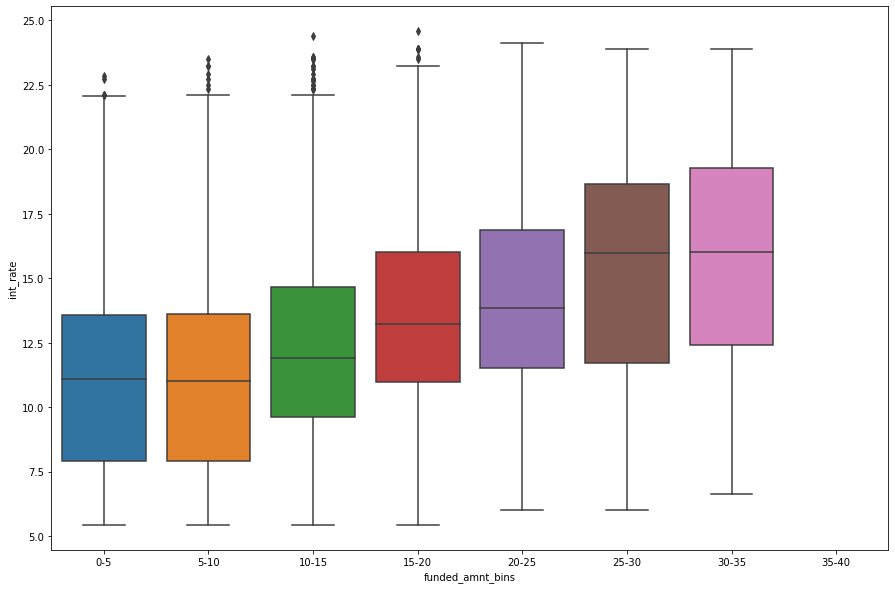

In [234]:
plt.figure(figsize=(15,10))
sns.boxplot(y="int_rate", x="funded_amnt_bins", data=df)
plt.show()

#### <font color="asparagus"> *Observations and Comments:* <font>
With the above plot, we can say that higher the funded_amnt(loan_amnt), higher is the interest rate

#### <font color="asparagus"> $\Rightarrow$ funded_amnt vs term <br> <font>

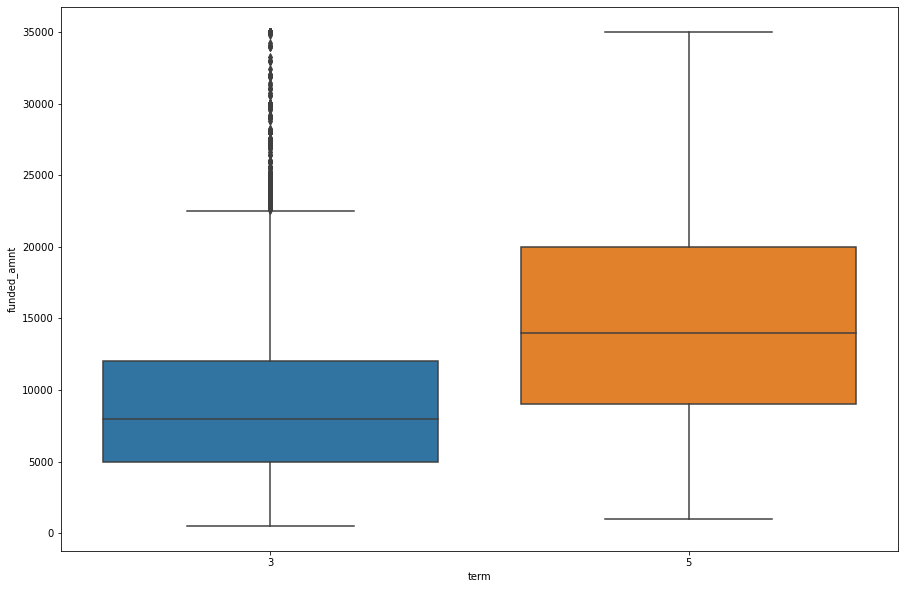

In [235]:
plt.figure(figsize=(15,10))
sns.boxplot(y="funded_amnt", x="term", data=df)
plt.show()

#### <font color="asparagus"> *Observations and Comments:* <font>
With the above plot, we can say that larger funded amounts go with 5 year loan repayment plan. But there are so many outliers in the 3 year boxplot! Can't really say for sure : )

# <font color='goldenrod'> IV. Conclusion </font>

In [236]:
indicators

['Pct_Payment_Received',
 'grade',
 'purpose',
 'annual_inc',
 'funded_amnt',
 'int_rate',
 'inq_last_6mnths',
 'addr_state',
 'delta_bins']

<font color="asparagus"> 1. Percent of payment received and *delta_bins*(amount of time elapsed from loan issue date to the last payment date): <font>

    The LC lends money with two term plans: 3 and 5 year plans. Checking the percentage of the amount payed at the edge i.e. 2-3 or 4-5 will give us a good indication of whether the loan is going to be defaulted or not.<br>
<font color="asparagus"> 2. Grade: <font>
    
    If we say grade A > B > C > D > E > F > G, then lower the loan grade, higher is the chance of defaulting.
<font color="asparagus"> 3. Annual income: <font> 
    
    Borrowers with lower income have a higher chance of defaulting on the loan.
<font color="asparagus">4. Funded amount: <font> 
    
    Higher the funded amount, higher is the chance of defaulting.
<font color="asparagus"> 5. Interest rate: <font>
    
    High interest rates attrack higher percentage of defaults.
<font color="asparagus"> 6. Inquiries in the last 6 months: <font>
    
    More the number of inquiries made the borrower in the last 6 months, more likely it is for the borrower to default.
<font color="asparagus"> 7. State address: <font>
    
    Certain states have higher chance of defaulting. Eg: Nebraska